In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os

import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import torch
from torch.utils.data import Dataset

from torch import Tensor

from numbers import Number
from typing import Union

from torch.nn import Sequential
import torchvision.transforms as tvts
from torch.utils.data import IterableDataset, IterDataPipe
from torchdata.datapipes.iter import Mapper, IterableWrapper
from torchdata.datapipes.iter import FileLister

from matplotlib import pyplot as plt
%matplotlib inline

from icecream import ic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from sklearn.metrics import mean_squared_error

DEVICE = 'cuda'

%run DDRM_sampling.ipynb
%run galaxy_ds.ipynb


In [2]:
ddrm_noise = torch.load('good_prior.pth')

In [3]:
ddrm_noise.shape

torch.Size([3, 64, 64])

In [3]:
ddrm_noise = ddrm_noise.to(device=DEVICE)



In [5]:
ddrm_noise.max()

tensor(1., device='cuda:0')

In [6]:
# Let's import the Hlens matrix that we will be using!

# lensing_Hb = torch.load('lensing_Hb.pth')
# lensed_image = torch.load('rgb_down_img.pth')

In [7]:
# print(lensing_Hb.shape)
# print(lensed_image.shape)

In [8]:
!nvidia-smi

Wed Jul 26 19:14:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:CA:00.0 Off |                  Off |
| N/A   30C    P0    67W / 400W |    853MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!nvidia-smi --query-gpu=name --format=csv,noheader

NVIDIA A100-SXM4-40GB


The aim is to use a DDPM generated image, noise it with some Gaussian noise in an obvious part, and then use DDRM to see how it extrapolates for the missing data. To do that, we need to account for our H matrix which will be an identity matrix with shape (3,64,64,3,64,64) since there will be no downgrade.

In [4]:
# Let's start by getting some DDPM prior samples'

probes_model_path = '/home/smarkesinis/astroddpm/logs/probes/03000000-model.pt'
ddpmds = DDPMDataset.from_pretrained_astroddpm(probes_model_path, map_location='cuda')

In [ ]:
plt.imshow(prior.movedim(-3,-1).cpu())
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for ax, img in zip(axs.flatten(), ddpmds):
    ax.imshow(img.movedim(-3, -1).cpu())
    ax.set_axis_off()

Now let's try to form a DDRM dataset: get some 'posterior' samples. To do that we need to account for the H matrix in our case. This will be the identity matrix in our case.

In [5]:
from tqdm.auto import tqdm
SRC_NPIX = 64
DOWNSAMPLE = 1

DEVICE = 'cuda'

In [6]:
probes_data_path = '/home/smarkesinis/astroddpm/data/probes/gals'
probes_dataset = GalaxyImageDataset(root_dir=probes_data_path,to_gray=False,n_pix=64)

In [7]:
src_multi = probes_dataset[100]
# src_multi = src_multi.numpy()
# src_multi = np.moveaxis(src_multi,0,-1)
# plt.imshow(src_multi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


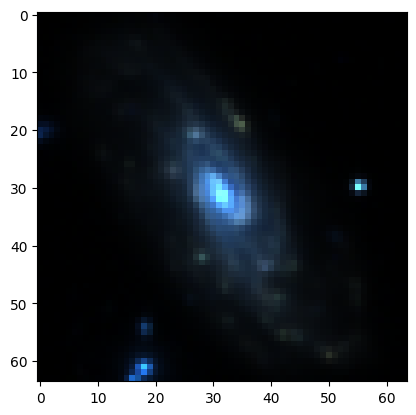

In [8]:
plt.imshow(src_multi.movedim(-3, -1).cpu())
plt.show()

In [9]:
src_multi = src_multi.to(device=DEVICE).requires_grad_(True)
#src_multi = src_multi.to(device=DEVICE)

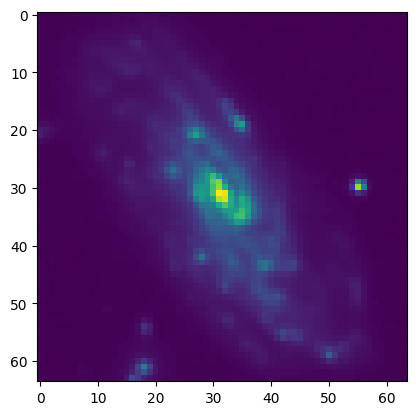

In [10]:
plt.imshow(src_multi[0].detach().cpu())

In [11]:
def get_H(img, src_img, chunk_size, device):
    """
    Function that computes the lensing matrix H (y_img = H x_src)
    """
    img = img.to(device=device).requires_grad_(True)
    src_img = src_img.to(device=device).requires_grad_(True)
    return torch.cat([
        torch.autograd.grad(_, src_img, torch.eye(chunk_size, device=device),
                            retain_graph=True, is_grads_batched=True)[0]
        for _ in tqdm(img.flatten(-3).split(chunk_size, dim=-1))
    ], dim=-4).unflatten(-4, img.shape[-3:])


In [12]:
Hb = get_H(src_multi,src_multi, int(SRC_NPIX/DOWNSAMPLE), device=DEVICE)
   # shape (..., SRC_NPIX/DONWSAMPLE, SRC_NPIX/DONWSAMPLE, SRC_NPIX, SRC_NPIX)
ic(Hb.shape);

  0%|          | 0/192 [00:00<?, ?it/s]

ic| Hb.shape: torch.Size([3, 64, 64, 3, 64, 64])


In [13]:
print(src_multi.shape)
print(src_multi[0].shape)

torch.Size([3, 64, 64])
torch.Size([64, 64])


We are only plotting one channel below! Makes sense not to have residuals since x = y = Hx in our case.

torch.Size([3, 64, 64])


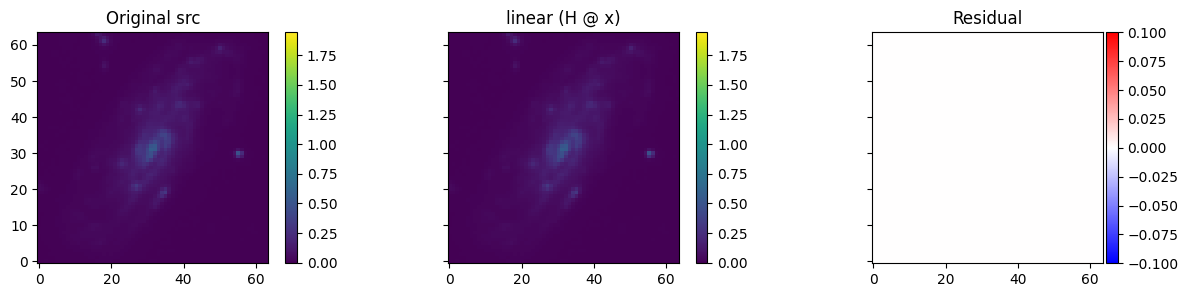

In [14]:
rimg = (Hb * src_multi.detach()).sum((-3, -2, -1))
print(rimg.shape)
err = rimg-src_multi
vm = err.abs().max()

fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(15, 3))

im = axs[0].imshow(src_multi[0].detach().cpu().numpy(), vmin=src_multi.min(), vmax=src_multi.max(), origin='lower')
plt.colorbar(im, ax=axs[0]);
axs[0].set_title('Original src')
im = axs[1].imshow(rimg[0].detach().cpu().numpy(), vmin=src_multi.min(), vmax=src_multi.max(), origin='lower')
plt.colorbar(im, ax=axs[1]);
axs[1].set_title('linear (H @ x)')
im = axs[2].imshow(err[0].detach().cpu().numpy(), cmap='bwr', vmin=-vm, vmax=vm, origin='lower')
plt.colorbar(im, ax= axs[2], pad=1e-2)
axs[2].set_title('Residual');

Let's get DDRM prior observations. Is the prior referring to just DDPM, or it also accounts for y=Hx which here y=x? Isn't that the same as the DDPM priors? YES


In [15]:
ddrmds = DDRMDataset.from_pretrained_astroddpm(probes_model_path, 
                                               Hb=Hb,
                                               multi_channel=True,
                                               map_location='cuda')

# multi_channel=False --> from 3 channels src to 1 channel img using mean of H

In [16]:
print(ddrmds.Hb.shape)
print(ddrmds.H.shape)

torch.Size([3, 64, 64, 3, 64, 64])
torch.Size([12288, 12288])


In [73]:
srcs = ddrmds.prior(20, clip=True).squeeze(0) / 2 + 0.5 # normalization

  0%|          | 0/100 [00:00<?, ?it/s]

In [74]:
srcs.shape

torch.Size([20, 3, 64, 64])

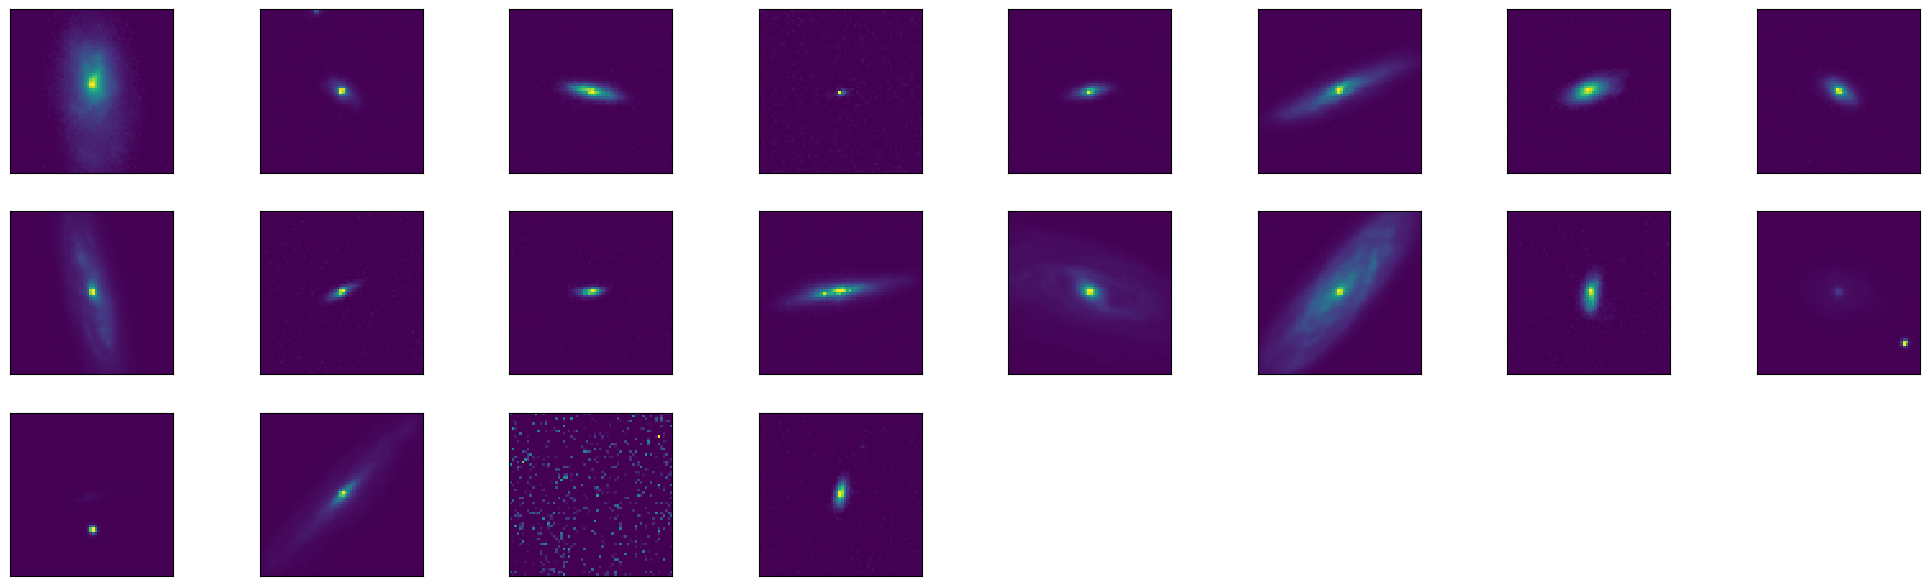

In [75]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(5,8,i+1)
    plt.tight_layout()
    #print(example_data[i].shape)
    plt.imshow(srcs[i][0].cpu(), interpolation='none')
   # plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

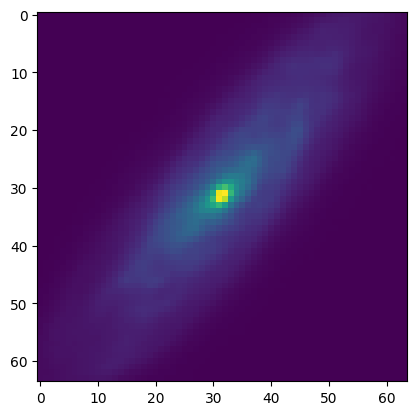

In [76]:
plt.imshow(srcs[13].mean(0).cpu())

In [77]:
srcs[13].max()

tensor(0.4802, device='cuda:0')

In [78]:
path_inp2 = '/home/smarkesinis/astroddpm/prior_inp2.pth'
torch.save(srcs[13],path_inp2)

In [32]:
path = '/home/smarkesinis/astroddpm/another_good_prior.pth'
torch.save(srcs,path)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64, 3, 64, 64])
torch.Size([12288, 12288])
torch.Size([3, 64, 64])


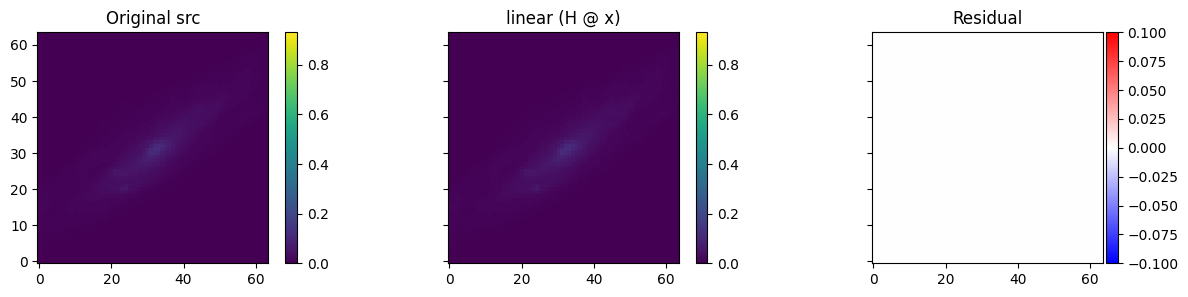

In [56]:
DEVICE = 'cuda'
i = 2
src = srcs
# src = src.to(device=DEVICE)
# Hb = Hb.to(device=DEVICE)
img = src
print(src.shape)
print(Hb.shape)
print(ddrmds.H.shape)
#rimg = (ddrmds.H.reshape(3, 64, -1) @ src.flatten(-2).unsqueeze(-1)).reshape(3, 64, 64)
#rimg = torch.einsum('ijklmn, ijk->ijl', Hb, src)
rimg = (Hb * src.detach()).sum((-3, -2, -1))
print(rimg.shape)
err = rimg-img
vm = err.abs().max()


fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(15, 3))

im = axs[0].imshow(src[0].cpu(), vmin=img.min(), vmax=img.max(), origin='lower')
plt.colorbar(im, ax=axs[0]);
axs[0].set_title('Original src')
im = axs[1].imshow(rimg[0].cpu(), vmin=img.min(), vmax=img.max(), origin='lower')
plt.colorbar(im, ax=axs[1]);
axs[1].set_title('linear (H @ x)')
im = axs[2].imshow(err[0].cpu(), cmap='bwr', vmin=-vm, vmax=vm, origin='lower')
plt.colorbar(im, ax= axs[2], pad=1e-2)
axs[2].set_title('Residual');

tensor(0.0931, device='cuda:0')
torch.Size([3, 64, 64])
torch.Size([12288])


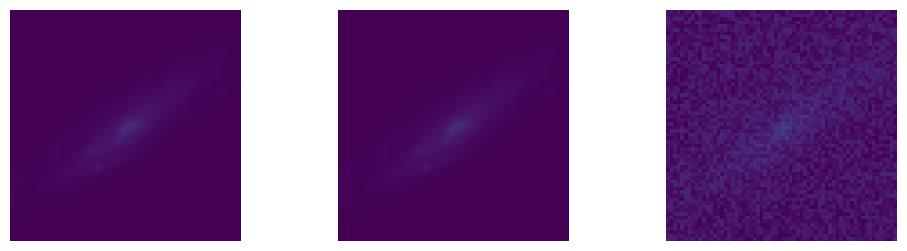

In [57]:
# SRC = IMG
src = src.to(device=DEVICE)
img = src
noise = img.max()/10
obs = img + torch.rand_like(img) * noise

print(noise)
print(obs.shape)
print(obs.flatten(-2).flatten(-2).shape)

imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower', vmin=0, vmax=img.max())
fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(12, 3))

for ax, im in zip(axs, (src.cpu(), img.cpu(), obs.cpu())):
    ax.imshow(im[0], **imkwargs)
    ax.set_axis_off()

In [58]:
ddrmds = DDRMDataset.from_pretrained_astroddpm(probes_model_path, 
                                               Hb=Hb,
                                               y=obs.flatten(-2).flatten(-2),
                                               sigma_y=noise,
                                               nbatch=6,
                                               eta=0.03, 
                                               eta_b=0.85,
                                               multi_channel=True,
                                               map_location='cuda')

In [59]:
samples = next(cycle(ddrmds))
print(samples.shape)
#samples = samples.mean(1).cpu()


SVD-ing


0it [00:00, ?it/s]

torch.Size([6, 3, 64, 64])


In [60]:
samples = samples.cpu()

In [61]:
samples.std(0).shape

torch.Size([3, 64, 64])

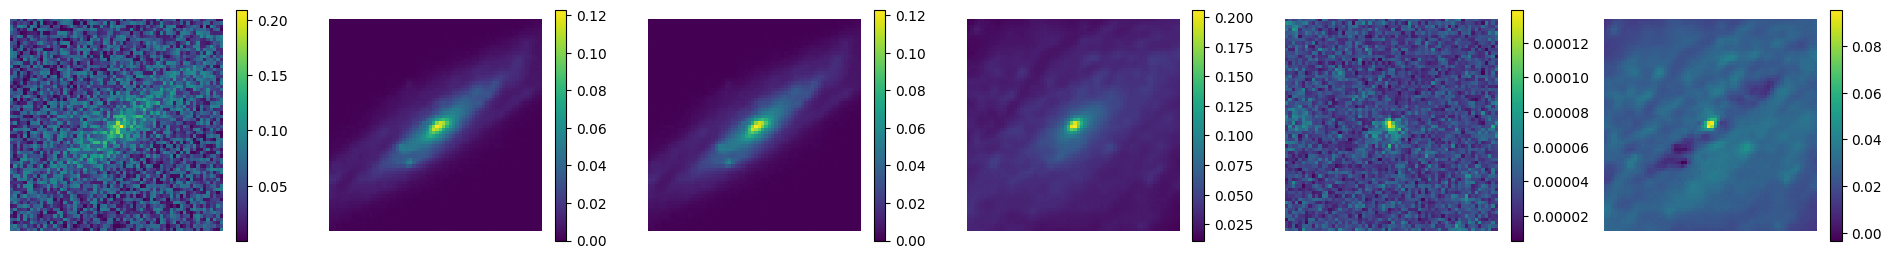

In [62]:
imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower')

fig, axs = plt.subplots(1, 6, sharex='all', sharey='all', figsize=(24, 3))

for ax, im in zip(axs, (obs[0].cpu(), img[0].cpu(), src[0].cpu(), samples.mean(0)[0].detach().numpy(), samples.std(0)[0].detach().numpy(), samples.mean(0)[0].detach().numpy() - src[0].cpu().numpy())):
    im = ax.imshow(im, **imkwargs)
    plt.colorbar(im, ax=ax);
    ax.set_axis_off()

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


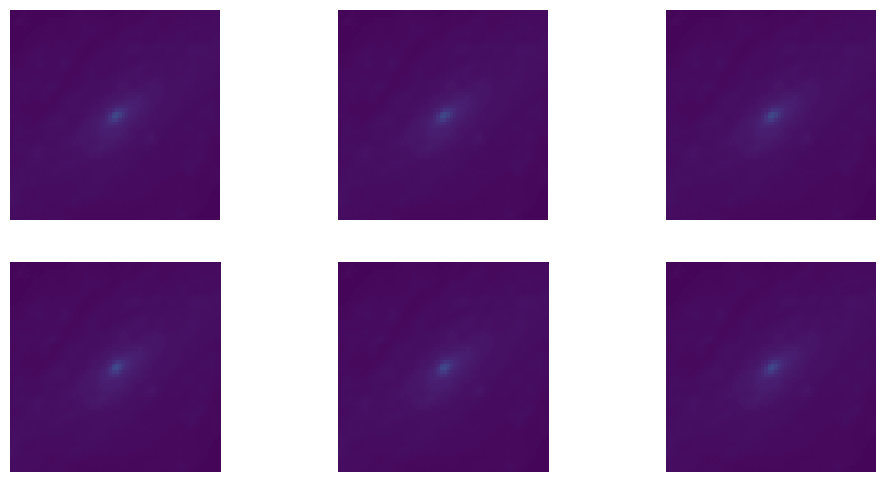

In [63]:
fig, axs = plt.subplots(2, 3, sharex='all', sharey='all', figsize=(12, 6))

for ax, im in zip(axs.flatten(), samples):
    print(im.shape)
    ax.imshow(im[0].detach().numpy(), vmin=0, vmax=src.max(), **imkwargs)
    ax.set_axis_off()

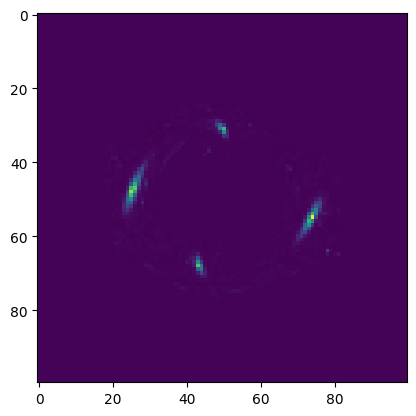

In [20]:
plt.imshow(lensed_image[0].detach().cpu())

In [21]:
ddrmds.H.shape

torch.Size([30000, 12288])

In [22]:
ddrm_noise.flatten().shape

torch.Size([12288])

In [23]:
obs = (ddrmds.H @ ddrm_noise.flatten()).reshape(3,100,100)

In [24]:
noise = ddrm_noise.max()/300
obs = obs + torch.rand_like(obs) * noise

In [25]:
obs.shape

torch.Size([3, 100, 100])

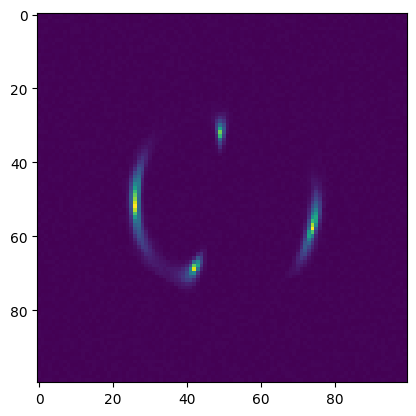

In [26]:
plt.imshow(obs[0].detach().cpu())

In [27]:
obs.flatten().shape

torch.Size([30000])

In [28]:

ddrmds = DDRMDataset.from_pretrained_astroddpm(probes_model_path, 
                                               Hb=lensing_Hb,
                                               y=obs.flatten(),
                                               sigma_y=noise,
                                               nbatch=5,
                                               eta=0.03, 
                                               eta_b=0.85,
                                               multi_channel=True,
                                               map_location='cuda')

In [29]:
samples = next(cycle(ddrmds))

SVD-ing


0it [00:00, ?it/s]

In [30]:
samples = samples.mean(1).cpu()

In [31]:
samples.shape

torch.Size([5, 64, 64])

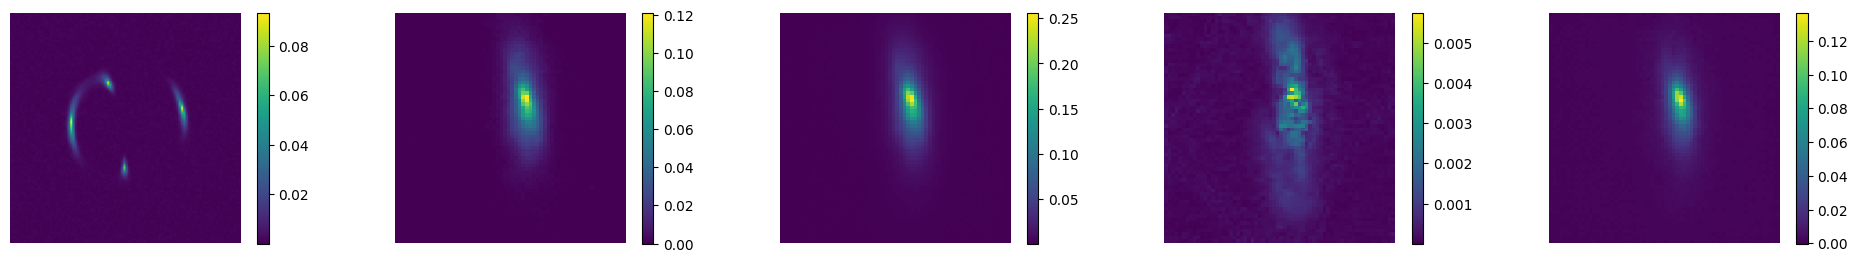

In [32]:
imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower')

fig, axs = plt.subplots(1, 5, sharex='all', sharey='all', figsize=(24, 3))

for ax, im in zip(axs, (obs[0].cpu(), ddrm_noise[0].cpu(), samples.mean(0), samples.std(0), samples.mean(0) - ddrm_noise[0].cpu())):
    im = ax.imshow(im.detach(), **imkwargs)
    plt.colorbar(im, ax=ax);
    ax.set_axis_off()


In [92]:
path = '/home/smarkesinis/astroddpm/good_prior.pth'
torch.save(ddrm_noise,path)

In [58]:
ddrm_noise[0].min()

tensor(0.0006, device='cuda:0')

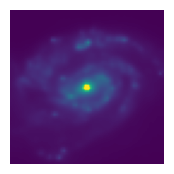

In [75]:
fig = plt.figure(figsize=(2,2), dpi=100)
plt.imshow(ddrm_noise[0].cpu(),vmin=0.0006,vmax=0.2544)
plt.axis('off')
plt.show()

In [16]:
ddrm_noise=ddrm_noise.mean(0)

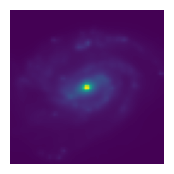

In [24]:
fig = plt.figure(figsize=(2,2), dpi=100)
plt.imshow(ddrm_noise.cpu(),vmin=0.0009,vmax=0.6774)
plt.axis('off')
plt.show()

In [22]:
ddrm_noise.max()

tensor(0.6774, device='cuda:0')

In [18]:

ddrm_noise.shape

torch.Size([256, 256])

In [85]:
ddrm_noise = srcs[13]

In [16]:
noisemask = (slice(None), slice(22,32), slice(27,37))
obs = ddrm_noise.clone()
obs[noisemask] = 0


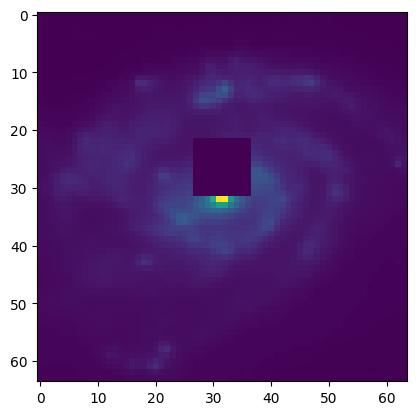

In [17]:
plt.imshow(obs[0].detach().cpu())

In [18]:
noise = torch.full_like(obs, obs.max() / 10)
noise[noisemask] *= 10
print(noise.shape)
#plt.imshow(noise[1].cpu())

torch.Size([3, 64, 64])


In [19]:
ic(noise.shape)

obs = obs + noise * torch.rand_like(noise)


ic| noise.shape: torch.Size([3, 64, 64])


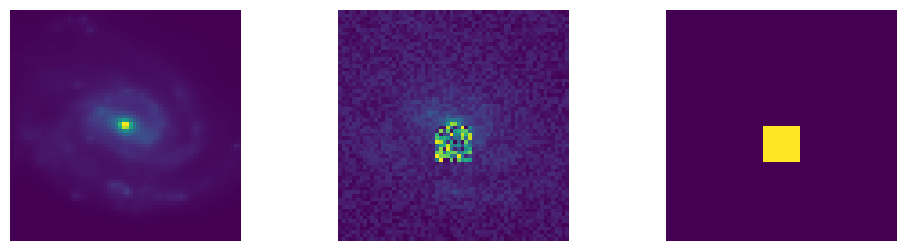

In [20]:
imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower')
fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(12, 3))

for ax, im in zip(axs, (ddrm_noise.mean(0).cpu(), obs[1].cpu(), noise[2].cpu())):
    ax.imshow(im, **imkwargs)
    ax.set_axis_off()

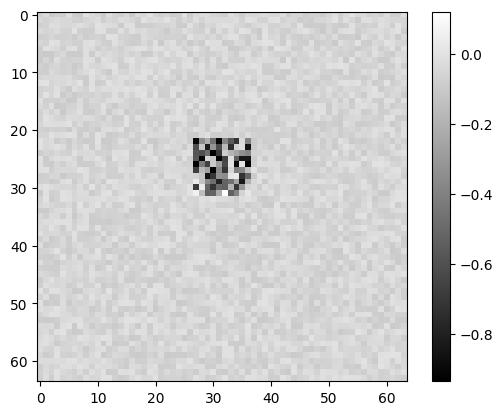

In [21]:
diff = ddrm_noise[0] - obs[0]
plt.imshow(diff.cpu(), cmap='gray')
plt.colorbar()


In [22]:
Sigma = noise.flatten(-2).flatten(-2).diag_embed()
Linv = torch.linalg.cholesky(Sigma).inverse()
ic(Linv.shape, Sigma.shape);


ic| Linv.shape: torch.Size([12288, 12288])
    Sigma.shape: torch.Size([12288, 12288])


In [23]:
Hb.shape

torch.Size([3, 64, 64, 3, 64, 64])

In [24]:
ddrm_noise.flatten().shape

torch.Size([12288])

In [25]:
Hb_solve = (Linv @ Hb.flatten(-2).flatten(-4,-3).flatten(0,1).flatten(1,2) ).reshape_as(Hb)
ic(Hb_solve.shape);

ic| Hb_solve.shape: torch.Size([3, 64, 64, 3, 64, 64])


In [26]:
ddrmds = DDRMDataset.from_pretrained_astroddpm(probes_model_path, 
                                               Hb=Hb_solve,
                                               multi_channel=True,
                                               map_location='cuda')

# multi_channel=False --> from 3 channels src to 1 channel img using mean of H

torch.Size([12288, 12288])


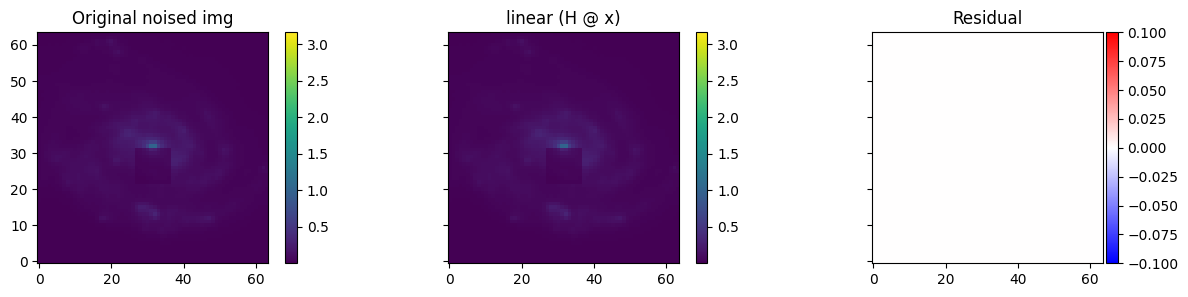

In [27]:
Linv_img = (Linv @ ddrm_noise.flatten()).reshape(ddrm_noise.shape)
print(ddrmds.H.shape)
rimg = (ddrmds.H * ddrm_noise.flatten()).sum(-1).reshape(ddrm_noise.shape)
err = rimg-Linv_img
vm = err.abs().max()

fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(15, 3))

im = axs[0].imshow(Linv_img[0].cpu(), vmin=Linv_img.min(), vmax=Linv_img.max(), origin='lower')
plt.colorbar(im, ax=axs[0]);
axs[0].set_title('Original noised img')
im = axs[1].imshow(rimg[0].cpu(), vmin=Linv_img.min(), vmax=Linv_img.max(), origin='lower')
plt.colorbar(im, ax=axs[1]);
axs[1].set_title('linear (H @ x)')
im = axs[2].imshow(err[0].cpu(), cmap='bwr', vmin=-vm, vmax=vm, origin='lower')
plt.colorbar(im, ax= axs[2], pad=1e-2)
axs[2].set_title('Residual');

# Check DDRM samples

In [28]:
def get_samples(eta, eta_b, y, noise, nsamples, clip=True):
    Y = 2*y - ddrmds.H.sum(-1) # normalization

    return (ddrmds.sample(
        Y.expand(nsamples, *Y.shape[-3 if ddrmds.multi_channel else -2:]),
        2 * noise, clip=clip, eta=eta, eta_b=eta_b
    ) + 1) / 2


In [29]:
y = (Linv @ obs.flatten(-2).flatten().unsqueeze(-1)).squeeze(-1)

In [33]:
y.shape

torch.Size([12288])

In [32]:
ddrmds.multi_channel

True

In [33]:
x = y.expand(5,*y.shape[-3 if ddrmds.multi_channel else -2:])

In [34]:
x.shape

torch.Size([5, 12288])

In [35]:
obs.max()

tensor(1.0604, device='cuda:0')

In [30]:
reconsamples =  get_samples(eta=1, eta_b=0.85,
    y=y, noise=1, nsamples=6, 
).unflatten(-1, ddrmds.src_shape)



SVD-ing


0it [00:00, ?it/s]

In [54]:
reconsamples.mean(0).shape

torch.Size([3, 64, 64])

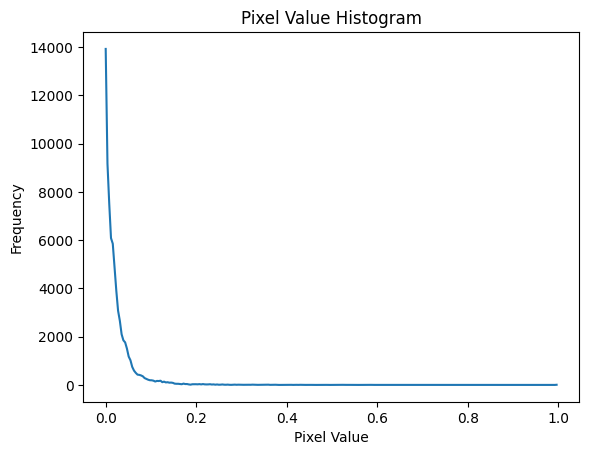

In [39]:
flattened_image = reconsamples.view(3, -1)

# Convert the tensor to a numpy array
flattened_image_np = flattened_image.detach().cpu().numpy()

# Calculate the histogram
hist, bins = np.histogram(flattened_image_np.flatten(), bins=256, range=[0, 1])

# Plot the histogram
plt.figure()
plt.title("Pixel Value Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.plot(bins[:-1], hist)
plt.show()

In [36]:
reconsamples.shape

torch.Size([3, 64, 64])

In [38]:
reconsamples = reconsamples.mean(0)

In [45]:
reconsamples.min()

tensor(0.0003, device='cuda:0', grad_fn=<MinBackward1>)

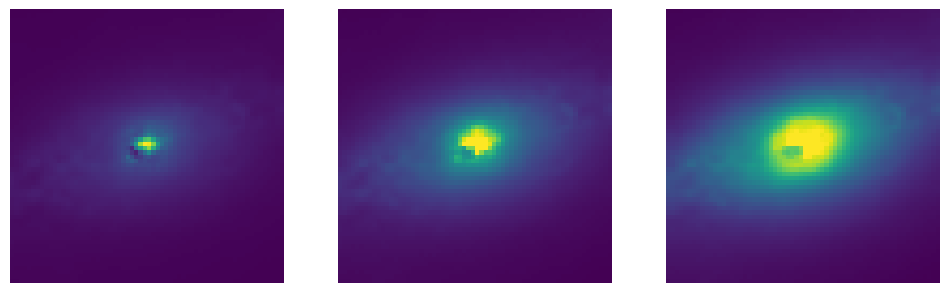

In [46]:
fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(12, 8))

for ax, src_img in zip(axs.flatten(), reconsamples):
    ax.imshow(src_img.cpu().detach().numpy(), **imkwargs)
    ax.set_axis_off()

In [46]:
reconsample2 =  get_samples(eta=0.9, eta_b=0.03,
    y=y, noise=1, nsamples=3, 
).unflatten(-1, ddrmds.src_shape)

0it [00:00, ?it/s]

In [47]:
reconsample2 = reconsample2.mean(1)

In [48]:
reconsample2.shape

torch.Size([3, 64, 64])

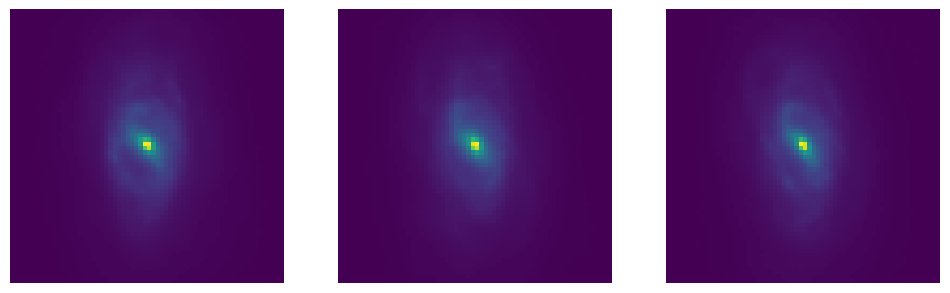

In [49]:
fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(12, 8))

for ax, src_img in zip(axs.flatten(), reconsample2):
    ax.imshow(src_img.cpu().detach().numpy(),  **imkwargs)
    ax.set_axis_off()

In [77]:
reconsamples.min()

tensor(0.0005, device='cuda:0', grad_fn=<MinBackward1>)

In [47]:
reconsamples.shape

torch.Size([64, 64])

In [76]:
reconsamples.max()

tensor(0.9733, device='cuda:0', grad_fn=<MaxBackward1>)

In [91]:
ddrm_noise.max()

tensor(1., device='cuda:0')

In [125]:
obs.shape

torch.Size([3, 64, 64])

In [85]:
reconsamples.std().shape

torch.Size([])

In [37]:
reconsamples.shape

torch.Size([6, 3, 64, 64])

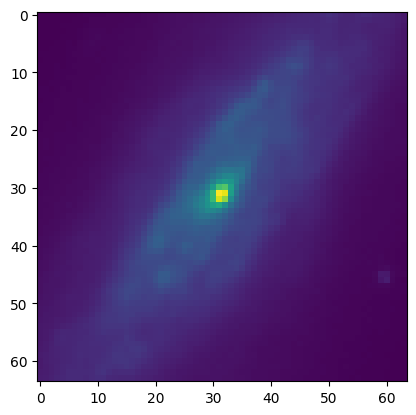

In [59]:
plt.imshow(reconsamples.mean(0)[0].cpu().detach().numpy())

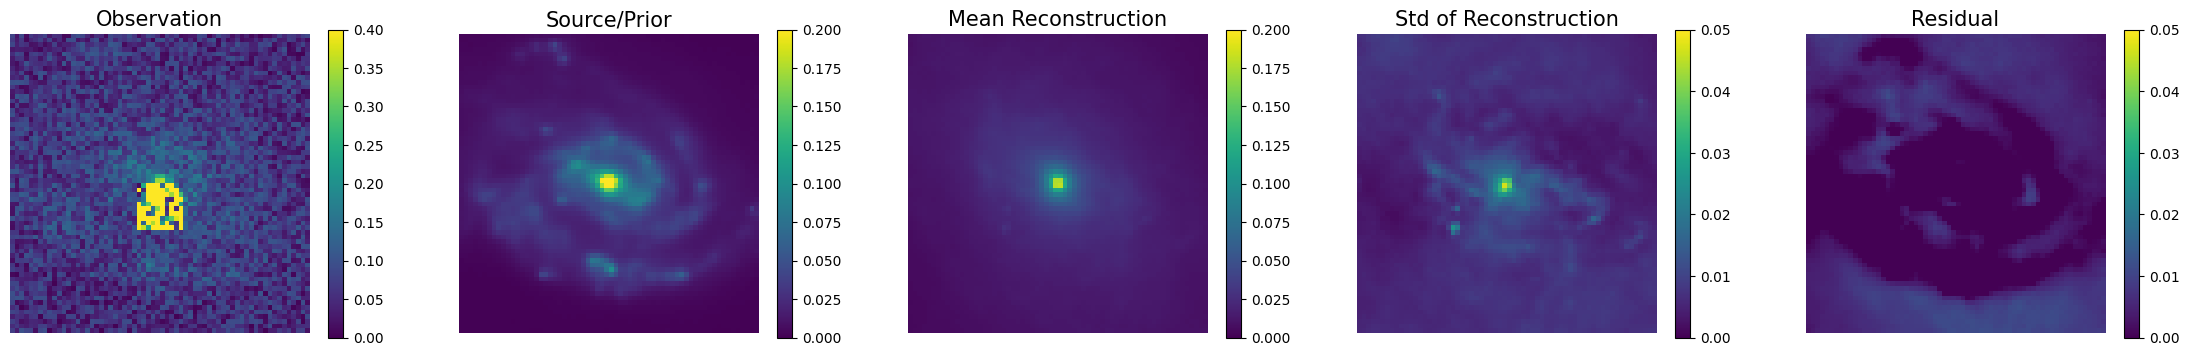

In [35]:
imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower')

fig, axs = plt.subplots(1, 5, sharex='all', sharey='all', figsize=(28, 4))

titles = ['Observation', 'Source/Prior', 'Mean Reconstruction', 'Std of Reconstruction','Residual']  # Titles for each image
vmaxs = [0.4,0.2,0.2,0.05,0.05]


for ax, im, title,vmax in zip(axs, (obs[0].cpu(), ddrm_noise[0].cpu(), reconsamples.mean(0)[0].cpu().detach().numpy(), reconsamples.std(0)[0].cpu().detach().numpy(),reconsamples.mean(0)[0].cpu().detach().numpy() - ddrm_noise[0].cpu().numpy()), titles,vmaxs):
    im = ax.imshow(im, vmin=0, vmax=vmax, **imkwargs)
    plt.colorbar(im, ax=ax)
    ax.set_axis_off()
    ax.set_title(title, fontsize=15)  # Add title above each image
    




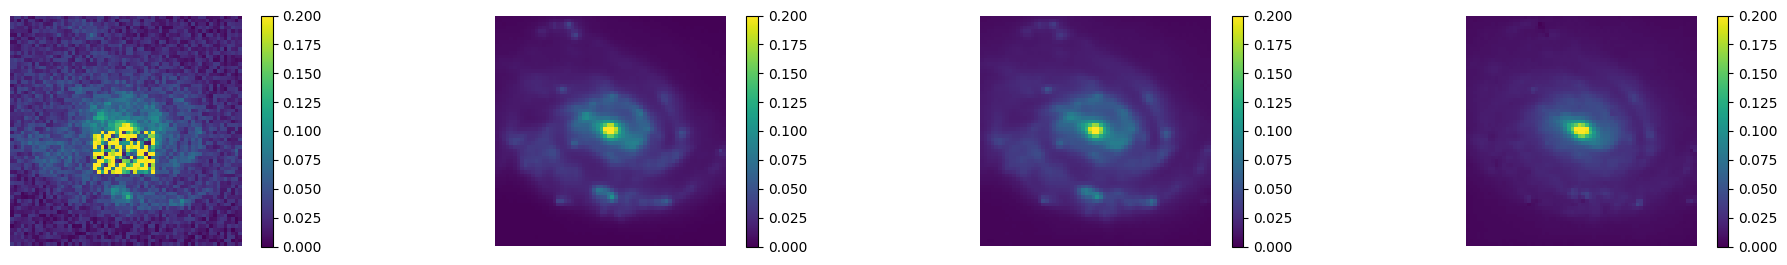

In [51]:
imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower')

fig, axs = plt.subplots(1, 4, sharex='all', sharey='all', figsize=(24, 3))

for ax, im in zip(axs, (obs[0].cpu(), ddrm_noise[0].cpu(), reconsamples[0].cpu().detach().numpy(), reconsamples[1].cpu().detach().numpy() - ddrm_noise[0].cpu().numpy())):
    im = ax.imshow(im,vmin=0,vmax=0.2,**imkwargs)
    plt.colorbar(im, ax=ax);
    ax.set_axis_off()

In [53]:
reconsamples.mean(1).shape

torch.Size([6, 64, 64])

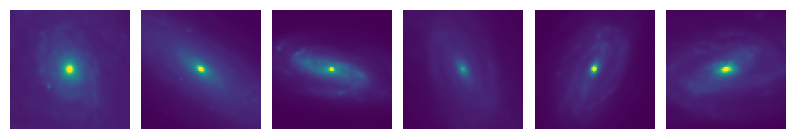

In [39]:
fig, axs = plt.subplots(1, 6, sharex='all', sharey='all', figsize=(10, 5))

for ax, src_img in zip(axs.flatten(), reconsamples.mean(1)):
    ax.imshow(src_img.detach().cpu(), vmin=0, vmax=0.4, **imkwargs)
    ax.set_axis_off()
    
plt.subplots_adjust(wspace=0.1)  # Adjust the spacing between subplots

plt.show()

# Hyperparameter Tuning

(3, 64, 64)
(64, 64)
(4096,)


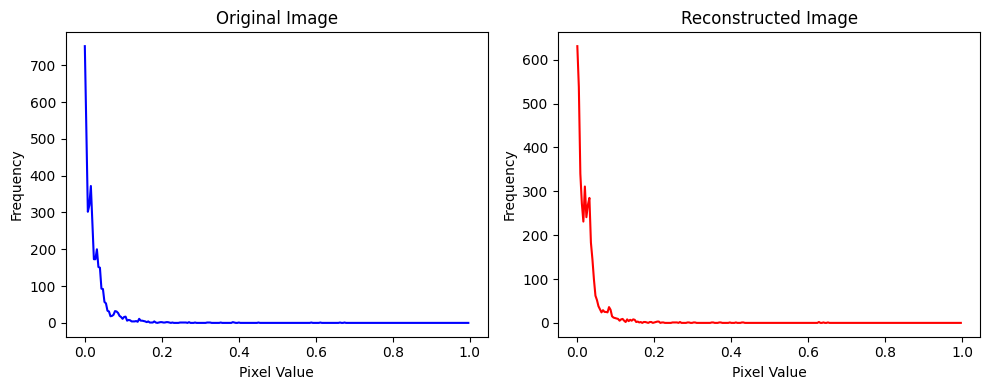

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'original_image' and 'reconstructed_image' are your two (3, 64, 64) images
original_image = ddrm_noise.cpu().detach().numpy()
reconstructed_image= reconsamples.cpu().detach().numpy()
print(original_image.shape)
# Reshape the images to (64, 64, 3)
#original_image = original_image.transpose(1, 2, 0)
#reconstructed_image = reconsamples.transpose(1, 2, 0)

# Convert the images to grayscale
original_gray = np.mean(original_image, axis=0)
print(original_gray.shape)
reconstructed_gray = np.mean(reconstructed_image, axis=0)
rere = reconstructed_gray.flatten()-original_gray.flatten()
print(rere.shape)

# Calculate the histograms
bins = np.linspace(0, 1, num=256)
original_hist, _ = np.histogram(original_gray.flatten(), bins=bins)
reconstructed_hist, _ = np.histogram(reconstructed_gray.flatten(), bins=bins)
no,_ = np.histogram(rere, bins=bins)

# Plot the histograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.plot(bins[:-1], original_hist, color='blue')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.plot(bins[:-1], reconstructed_hist, color='red')


plt.tight_layout()
plt.show()


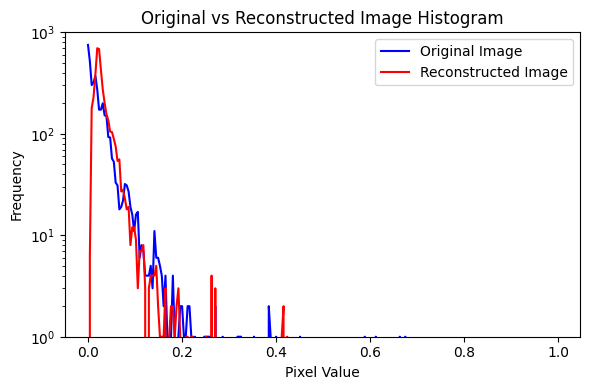

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'original_image' and 'reconstructed_image' are your two (3, 64, 64) images
original_image = ddrm_noise.cpu().detach().numpy()
reconstructed_image = reconsamples.cpu().detach().numpy()

# Reshape the images to (64, 64, 3)
original_image = original_image.transpose(1, 2, 0)
reconstructed_image = reconstructed_image.transpose(1, 2, 0)

# Convert the images to grayscale
original_gray = np.mean(original_image, axis=2)
reconstructed_gray = np.mean(reconstructed_image, axis=2)

# Calculate the histograms
bins = np.linspace(0, 1, num=256)
original_hist, _ = np.histogram(original_gray.flatten(), bins=bins)
reconstructed_hist, _ = np.histogram(reconstructed_gray.flatten(), bins=bins)

# Plot the histograms
plt.figure(figsize=(6, 4))
plt.title('Original vs Reconstructed Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(1,1000)
plt.plot(bins[:-1], original_hist, color='blue', label='Original Image')
plt.plot(bins[:-1], reconstructed_hist, color='red', label='Reconstructed Image')
plt.legend()

plt.tight_layout()
plt.show()


So let's assume that the reconstruction works relatively fine. The ultimate goal is to assess how much variability the DDRM process is capable of and hence checking how the hyperparameters η and ηb affect the reconstruction, as well as the noise level in z(σy) will provide us with which of them provide the best results.

# Bayesian Optimization

What I do here is get the image generated from the DDPM (prior) and then using $y = Hx + Σz$ I define my observation (y). Then assuming that with the DDRM we can sample frm $p(x|y)$ we expect the DDRM to fill out the missing data in y. This process depends on the hyperparameters that control the DDRM sampling. So i want to find the optimal $\eta$ and $\eta_b$ that give the best reconstruction (fill the missing data with the most adequate way when compared to x). So I use Bayesian optimization to search for the optimal hyperameters. The problem is that I use only one prior and hence the reconstructed samples only depend on this. This means that the process only learns the optimal hyperparams to reconstruct this specific image (prior x), if it even does.


In [29]:
import torchvision.models as models

# Define the perceptual loss function
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features[:23]
        for param in self.model.parameters():
            param.requires_grad = False
        self.loss_fn = nn.MSELoss()

    def forward(self, x, y):
        x_features = self.model(x)
        y_features = self.model(y)
        return self.loss_fn(x_features, y_features)

In [30]:
# Create an instance of the perceptual loss function
perceptual_loss = PerceptualLoss()
perceptual_loss.to(DEVICE)

PerceptualLoss(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [31]:
scale = (1,1.5)
my_trans = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(0.5),
    #transforms.RandomRotation((0,3)),
    transforms.RandomAffine(
                degrees=(0,3),
                translate=(0.01,0.02),
                scale=(1/scale, scale) if isinstance(scale, Number) else scale,
    )])
                   

In [32]:
augmented = [my_trans(ddrm_noise) for _ in range(100) ]

In [33]:
# Objective Function (measure of the quality of reconstructed images)

def objective(x):
    
    
    eta, eta_b = x
   
    reconstructed_images = get_samples(eta, eta_b,y, noise=1.,nsamples=5)
    reconstructed_image = reconstructed_images.mean(0)
    reconstructed_image = reconstructed_image.to(DEVICE)
    #print(reconstructed_image.shape)
    #print(reconstructed_images.shape)
   
    ground_truth_image = torch.stack(augmented)
    ground_truth_image = torch.mean(ground_truth_image,axis=0)
    reconstructed_image = reconstructed_image.reshape(3,64,64)
    
    # detach the tensors to save memory
    ground_truth_image = ground_truth_image.detach()
    reconstructed_image = reconstructed_image.detach()

    # Compute the mean squared error between the reconstructed image and the ground truth
    #mse = torch.nn.functional.mse_loss(reconstructed_image, ground_truth_image)
    
    pl = perceptual_loss(reconstructed_image, ground_truth_image)
    #total_loss = mse + pl
    return pl

    

In [34]:
# Define the search space for the hyperparameters
search_space = [
    Real(0.01, 1, name='eta'),
    Real(0.01, 1, name='eta_b'),
]

# Specify the Gaussian process prior over the objective function

kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)

In [35]:
# Define the optimization loop
@use_named_args(search_space)
def optimization_loop(**params):
    
    # Evaluate the objective function
    objective_values = []
    for i in range(2):
        objective_value = objective([params['eta'], params['eta_b']])
        objective_values.append(objective_value)
    
    # Compute the mean objective value over the evaluations
    objective_values = torch.Tensor(objective_values)
    objective_value = torch.mean(objective_values).item()
    print(objective_value)
    print(params['eta'])
    print(params['eta_b'])
    # Update the Gaussian process prior
    X = np.array([[params['eta'], params['eta_b']]])
    y = np.array([objective_value])
    gp.fit(X, y)
    
    # Return the objective value
    return objective_value


In [36]:
# Run the Bayesian optimization loop
result = gp_minimize(
    optimization_loop,       # optimization loop function to minimize
    search_space,            # search space for hyperparameters
    acq_func='EI',           # acquisition function to use (expected improvement)
    n_calls=1000,              # number of function evaluations (i.e., hyperparameter settings) to use
    n_random_starts=1000,       # number of random initializations before starting the optimization loop
    verbose=True,            # enable verbose output
    n_jobs=-1,               # number of parallel jobs to run (-1 for using all available processors)
    random_state=10,         #
)

Iteration No: 1 started. Evaluating function at random point.
SVD-ing


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13284087181091309
0.305773540366772
0.4996440302380306
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.5797
Function value obtained: 0.1328
Current minimum: 0.1328
Iteration No: 2 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12835004925727844
0.4485847982117224
0.8335922453814891
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.2116
Function value obtained: 0.1284
Current minimum: 0.1284
Iteration No: 3 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07664548605680466
0.587488519568359
0.03492001113356817
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.2088
Function value obtained: 0.0766
Current minimum: 0.0766
Iteration No: 4 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09269152581691742
0.712115929744582
0.2729104655043761
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.3151
Function value obtained: 0.0927
Current minimum: 0.0766
Iteration No: 5 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12192714959383011
0.27096681756866287
0.1588740885891483
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.2145
Function value obtained: 0.1219
Current minimum: 0.0766
Iteration No: 6 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1264868676662445
0.6869802450676219
0.8184358168684602
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.2266
Function value obtained: 0.1265
Current minimum: 0.0766
Iteration No: 7 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1330820620059967
0.3427108686199064
0.8919083653725294
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 2.2255
Function value obtained: 0.1331
Current minimum: 0.0766
Iteration No: 8 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13690203428268433
0.20614059490264064
0.040310487333966485
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.2190
Function value obtained: 0.1369
Current minimum: 0.0766
Iteration No: 9 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1122429370880127
0.878838790498356
0.7301611585810511
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.3464
Function value obtained: 0.1122
Current minimum: 0.0766
Iteration No: 10 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10422731190919876
0.5454721219646188
0.14014357087849771
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 2.2116
Function value obtained: 0.1042
Current minimum: 0.0766
Iteration No: 11 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11054885387420654
0.4195307006742683
0.7809415201813532
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 2.2115
Function value obtained: 0.1105
Current minimum: 0.0766
Iteration No: 12 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11572390794754028
0.5880623519971393
0.19080512193899482
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 2.2091
Function value obtained: 0.1157
Current minimum: 0.0766
Iteration No: 13 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07232610881328583
0.8278214252715848
0.11434781515292308
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 2.2109
Function value obtained: 0.0723
Current minimum: 0.0723
Iteration No: 14 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.110810786485672
0.29074091179674016
0.07490763369123049
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 2.3229
Function value obtained: 0.1108
Current minimum: 0.0723
Iteration No: 15 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16285377740859985
0.06587974559536994
0.7678012600330337
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 2.2192
Function value obtained: 0.1629
Current minimum: 0.0723
Iteration No: 16 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16285111010074615
0.021670149091114622
0.6158239076999009
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 2.2082
Function value obtained: 0.1629
Current minimum: 0.0723
Iteration No: 17 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12080332636833191
0.3385634331110398
0.564051881801745
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 2.2092
Function value obtained: 0.1208
Current minimum: 0.0723
Iteration No: 18 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12142446637153625
0.3421446500546713
0.4170707205149869
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 2.2094
Function value obtained: 0.1214
Current minimum: 0.0723
Iteration No: 19 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628442108631134
0.08608694672878466
0.8545125604154719
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.3227
Function value obtained: 0.1628
Current minimum: 0.0723
Iteration No: 20 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10960519313812256
0.44558758094924905
0.1307346056558958
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 2.2177
Function value obtained: 0.1096
Current minimum: 0.0723
Iteration No: 21 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06443032622337341
0.734417278402255
0.14739464079557407
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 2.2342
Function value obtained: 0.0644
Current minimum: 0.0644
Iteration No: 22 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1401146948337555
0.7692112487426536
0.8336698701093803
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 2.2157
Function value obtained: 0.1401
Current minimum: 0.0644
Iteration No: 23 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0998498722910881
0.3166802746586592
0.6016064673885859
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 2.3488
Function value obtained: 0.0998
Current minimum: 0.0644
Iteration No: 24 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07017539441585541
0.8736685352407182
0.9831906581838171
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 2.2109
Function value obtained: 0.0702
Current minimum: 0.0644
Iteration No: 25 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12148630619049072
0.4727292461944055
0.8769870497927366
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 2.2112
Function value obtained: 0.1215
Current minimum: 0.0644
Iteration No: 26 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13255324959754944
0.30310801187549363
0.139978142327775
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 2.2111
Function value obtained: 0.1326
Current minimum: 0.0644
Iteration No: 27 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07442198693752289
0.8443897541585603
0.6624459408989051
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 2.2096
Function value obtained: 0.0744
Current minimum: 0.0644
Iteration No: 28 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1309235692024231
0.5994852089495816
0.4419901612978371
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 2.3227
Function value obtained: 0.1309
Current minimum: 0.0644
Iteration No: 29 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14784196019172668
0.3626878234873824
0.5912596160014094
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 2.2122
Function value obtained: 0.1478
Current minimum: 0.0644
Iteration No: 30 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12193980067968369
0.15797662361607245
0.17952621222583895
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 2.2096
Function value obtained: 0.1219
Current minimum: 0.0644
Iteration No: 31 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12102717161178589
0.40319287764879647
0.6415720486582247
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 2.2118
Function value obtained: 0.1210
Current minimum: 0.0644
Iteration No: 32 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1619538515806198
0.37879475246592875
0.01238269372946723
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 2.2158
Function value obtained: 0.1620
Current minimum: 0.0644
Iteration No: 33 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.058433160185813904
0.5533281921864298
0.13570212303710702
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 2.3276
Function value obtained: 0.0584
Current minimum: 0.0584
Iteration No: 34 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16287025809288025
0.08899475382570414
0.24268820991674156
Iteration No: 34 ended. Evaluation done at random point.
Time taken: 2.2097
Function value obtained: 0.1629
Current minimum: 0.0584
Iteration No: 35 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04828021675348282
0.6633652977354229
0.2228036599573465
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 2.2245
Function value obtained: 0.0483
Current minimum: 0.0483
Iteration No: 36 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13328726589679718
0.21101614948509084
0.3890364597870231
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 2.2178
Function value obtained: 0.1333
Current minimum: 0.0483
Iteration No: 37 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12228073179721832
0.23262407444511526
0.12350231120648734
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 2.3512
Function value obtained: 0.1223
Current minimum: 0.0483
Iteration No: 38 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1316915899515152
0.5871868810256301
0.2403146521085204
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 2.2120
Function value obtained: 0.1317
Current minimum: 0.0483
Iteration No: 39 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08435295522212982
0.5609530059666051
0.5285727760889805
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 2.2104
Function value obtained: 0.0844
Current minimum: 0.0483
Iteration No: 40 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13633209466934204
0.3574486415336583
0.7082782970333233
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 2.2118
Function value obtained: 0.1363
Current minimum: 0.0483
Iteration No: 41 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05395154654979706
0.8224967038507163
0.14321737342967303
Iteration No: 41 ended. Evaluation done at random point.
Time taken: 2.2110
Function value obtained: 0.0540
Current minimum: 0.0483
Iteration No: 42 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09904887527227402
0.6086788984357828
0.29031679330663823
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 2.3263
Function value obtained: 0.0990
Current minimum: 0.0483
Iteration No: 43 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11188788712024689
0.5113437416787877
0.04807582400762985
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 2.2116
Function value obtained: 0.1119
Current minimum: 0.0483
Iteration No: 44 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1045626848936081
0.3391196549658114
0.010269806176441867
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 2.2115
Function value obtained: 0.1046
Current minimum: 0.0483
Iteration No: 45 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0981317088007927
0.668008911459535
0.38366625808463195
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 2.2102
Function value obtained: 0.0981
Current minimum: 0.0483
Iteration No: 46 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03773679584264755
0.7501061487188191
0.14917002412385155
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 2.3209
Function value obtained: 0.0377
Current minimum: 0.0377
Iteration No: 47 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1210748553276062
0.3941689588057321
0.8678267242484599
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 2.2188
Function value obtained: 0.1211
Current minimum: 0.0377
Iteration No: 48 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04252203553915024
0.9572847931094332
0.49168813211701756
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 2.2110
Function value obtained: 0.0425
Current minimum: 0.0377
Iteration No: 49 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14812102913856506
0.11487372798000335
0.34663691576637384
Iteration No: 49 ended. Evaluation done at random point.
Time taken: 2.2127
Function value obtained: 0.1481
Current minimum: 0.0377
Iteration No: 50 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09033609181642532
0.8372150858089257
0.47078720988597783
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 2.2165
Function value obtained: 0.0903
Current minimum: 0.0377
Iteration No: 51 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14801481366157532
0.10192754697348476
0.8561472020105744
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 2.3222
Function value obtained: 0.1480
Current minimum: 0.0377
Iteration No: 52 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1255190670490265
0.3438856040677838
0.6100852836976174
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 2.2398
Function value obtained: 0.1255
Current minimum: 0.0377
Iteration No: 53 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16274400055408478
0.12153795459431992
0.5484812423598898
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 2.2100
Function value obtained: 0.1627
Current minimum: 0.0377
Iteration No: 54 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11576013267040253
0.7235905962938329
0.8671572127725918
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 2.2172
Function value obtained: 0.1158
Current minimum: 0.0377
Iteration No: 55 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14811435341835022
0.1552341127958803
0.11234725905010531
Iteration No: 55 ended. Evaluation done at random point.
Time taken: 2.2101
Function value obtained: 0.1481
Current minimum: 0.0377
Iteration No: 56 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14659211039543152
0.4956491324842783
0.038887760167809225
Iteration No: 56 ended. Evaluation done at random point.
Time taken: 2.3479
Function value obtained: 0.1466
Current minimum: 0.0377
Iteration No: 57 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16149713099002838
0.5989123403102293
0.2137870208171971
Iteration No: 57 ended. Evaluation done at random point.
Time taken: 2.2099
Function value obtained: 0.1615
Current minimum: 0.0377
Iteration No: 58 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13636067509651184
0.21077494378714062
0.8456846163942155
Iteration No: 58 ended. Evaluation done at random point.
Time taken: 2.2114
Function value obtained: 0.1364
Current minimum: 0.0377
Iteration No: 59 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16280227899551392
0.07095071276362075
0.5042383825553122
Iteration No: 59 ended. Evaluation done at random point.
Time taken: 2.2180
Function value obtained: 0.1628
Current minimum: 0.0377
Iteration No: 60 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14816749095916748
0.2559823089220474
0.33387258810238285
Iteration No: 60 ended. Evaluation done at random point.
Time taken: 2.2238
Function value obtained: 0.1482
Current minimum: 0.0377
Iteration No: 61 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16287285089492798
0.012886927462899732
0.30248771358885457
Iteration No: 61 ended. Evaluation done at random point.
Time taken: 2.3224
Function value obtained: 0.1629
Current minimum: 0.0377
Iteration No: 62 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.018899794667959213
0.9870202307936343
0.24594938751375262
Iteration No: 62 ended. Evaluation done at random point.
Time taken: 2.2115
Function value obtained: 0.0189
Current minimum: 0.0189
Iteration No: 63 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09328489005565643
0.7360625102540338
0.9625749187629223
Iteration No: 63 ended. Evaluation done at random point.
Time taken: 2.2158
Function value obtained: 0.0933
Current minimum: 0.0189
Iteration No: 64 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11390518397092819
0.8173012303724475
0.6972847077892825
Iteration No: 64 ended. Evaluation done at random point.
Time taken: 2.2113
Function value obtained: 0.1139
Current minimum: 0.0189
Iteration No: 65 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16327720880508423
0.21858913315938214
0.5226656271973728
Iteration No: 65 ended. Evaluation done at random point.
Time taken: 2.3197
Function value obtained: 0.1633
Current minimum: 0.0189
Iteration No: 66 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.054005809128284454
0.9501732910944853
0.6990141287036659
Iteration No: 66 ended. Evaluation done at random point.
Time taken: 2.2148
Function value obtained: 0.0540
Current minimum: 0.0189
Iteration No: 67 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06255674362182617
0.9056180880039739
0.6514135055468266
Iteration No: 67 ended. Evaluation done at random point.
Time taken: 2.2136
Function value obtained: 0.0626
Current minimum: 0.0189
Iteration No: 68 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11023508012294769
0.35184912760632714
0.07484287851365222
Iteration No: 68 ended. Evaluation done at random point.
Time taken: 2.2125
Function value obtained: 0.1102
Current minimum: 0.0189
Iteration No: 69 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13275156915187836
0.22842158457738299
0.14599951389962004
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.1328
Current minimum: 0.0189
Iteration No: 70 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10759526491165161
0.746852965489926
0.35322375243379633
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 2.2109
Function value obtained: 0.1076
Current minimum: 0.0189
Iteration No: 71 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07551425695419312
0.5818876119989115
0.17666940656260985
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 2.3237
Function value obtained: 0.0755
Current minimum: 0.0189
Iteration No: 72 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16296498477458954
0.04759198724152062
0.8190049369510554
Iteration No: 72 ended. Evaluation done at random point.
Time taken: 2.2104
Function value obtained: 0.1630
Current minimum: 0.0189
Iteration No: 73 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08317529410123825
0.8143402049076658
0.19655130331999154
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 2.2488
Function value obtained: 0.0832
Current minimum: 0.0189
Iteration No: 74 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14779378473758698
0.3793317737740743
0.746750214673215
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 2.2104
Function value obtained: 0.1478
Current minimum: 0.0189
Iteration No: 75 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1214756965637207
0.19438529650549255
0.41965982843346294
Iteration No: 75 ended. Evaluation done at random point.
Time taken: 2.2157
Function value obtained: 0.1215
Current minimum: 0.0189
Iteration No: 76 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12134550511837006
0.23869526650413966
0.6570866997682218
Iteration No: 76 ended. Evaluation done at random point.
Time taken: 2.3557
Function value obtained: 0.1213
Current minimum: 0.0189
Iteration No: 77 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07196754217147827
0.7667310138109739
0.8365303394884295
Iteration No: 77 ended. Evaluation done at random point.
Time taken: 2.2170
Function value obtained: 0.0720
Current minimum: 0.0189
Iteration No: 78 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1480352133512497
0.22009072312763375
0.9623469347467655
Iteration No: 78 ended. Evaluation done at random point.
Time taken: 2.2125
Function value obtained: 0.1480
Current minimum: 0.0189
Iteration No: 79 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13337692618370056
0.2685289400328266
0.8651324938693619
Iteration No: 79 ended. Evaluation done at random point.
Time taken: 2.2107
Function value obtained: 0.1334
Current minimum: 0.0189
Iteration No: 80 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14791274070739746
0.13560567611274918
0.37719319055188244
Iteration No: 80 ended. Evaluation done at random point.
Time taken: 2.3261
Function value obtained: 0.1479
Current minimum: 0.0189
Iteration No: 81 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1342715322971344
0.6752137025235749
0.9345137182651312
Iteration No: 81 ended. Evaluation done at random point.
Time taken: 2.2152
Function value obtained: 0.1343
Current minimum: 0.0189
Iteration No: 82 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12727345526218414
0.5633105373276319
0.6757246189371903
Iteration No: 82 ended. Evaluation done at random point.
Time taken: 2.2128
Function value obtained: 0.1273
Current minimum: 0.0189
Iteration No: 83 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1627143770456314
0.08628471204431686
0.2573873701785689
Iteration No: 83 ended. Evaluation done at random point.
Time taken: 2.2111
Function value obtained: 0.1627
Current minimum: 0.0189
Iteration No: 84 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12096847593784332
0.36202557523840717
0.03319776877670507
Iteration No: 84 ended. Evaluation done at random point.
Time taken: 2.2103
Function value obtained: 0.1210
Current minimum: 0.0189
Iteration No: 85 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05185304582118988
0.9357777308900751
0.21750173550015445
Iteration No: 85 ended. Evaluation done at random point.
Time taken: 2.2118
Function value obtained: 0.0519
Current minimum: 0.0189
Iteration No: 86 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10768932104110718
0.5810052494706519
0.5852368575120819
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 2.3294
Function value obtained: 0.1077
Current minimum: 0.0189
Iteration No: 87 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12213334441184998
0.2415819495413453
0.48814939856215955
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 2.2192
Function value obtained: 0.1221
Current minimum: 0.0189
Iteration No: 88 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10841546952724457
0.5515728904377933
0.8730941888165473
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 2.2111
Function value obtained: 0.1084
Current minimum: 0.0189
Iteration No: 89 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.036762237548828125
0.9643956661543379
0.16999447117693023
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 2.2180
Function value obtained: 0.0368
Current minimum: 0.0189
Iteration No: 90 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16287051141262054
0.026721314549382633
0.02685967474565417
Iteration No: 90 ended. Evaluation done at random point.
Time taken: 2.2202
Function value obtained: 0.1629
Current minimum: 0.0189
Iteration No: 91 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14838044345378876
0.20684668612436904
0.89956058832307
Iteration No: 91 ended. Evaluation done at random point.
Time taken: 2.3263
Function value obtained: 0.1484
Current minimum: 0.0189
Iteration No: 92 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07630196213722229
0.7879972789025943
0.6890627536198232
Iteration No: 92 ended. Evaluation done at random point.
Time taken: 2.2107
Function value obtained: 0.0763
Current minimum: 0.0189
Iteration No: 93 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1477997899055481
0.33326711211538196
0.4144055185625744
Iteration No: 93 ended. Evaluation done at random point.
Time taken: 2.2125
Function value obtained: 0.1478
Current minimum: 0.0189
Iteration No: 94 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1048068180680275
0.5781345369870173
0.010976799693422041
Iteration No: 94 ended. Evaluation done at random point.
Time taken: 2.2332
Function value obtained: 0.1048
Current minimum: 0.0189
Iteration No: 95 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12186827510595322
0.7523540152258601
0.7533306352325713
Iteration No: 95 ended. Evaluation done at random point.
Time taken: 2.3256
Function value obtained: 0.1219
Current minimum: 0.0189
Iteration No: 96 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12172239273786545
0.38943982339406435
0.3792091218107532
Iteration No: 96 ended. Evaluation done at random point.
Time taken: 2.2194
Function value obtained: 0.1217
Current minimum: 0.0189
Iteration No: 97 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08615359663963318
0.8442550526849238
0.7617035163047797
Iteration No: 97 ended. Evaluation done at random point.
Time taken: 2.2104
Function value obtained: 0.0862
Current minimum: 0.0189
Iteration No: 98 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13708463311195374
0.17412468091318928
0.7566147629109732
Iteration No: 98 ended. Evaluation done at random point.
Time taken: 2.2118
Function value obtained: 0.1371
Current minimum: 0.0189
Iteration No: 99 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14670395851135254
0.600033995252346
0.9275407852061197
Iteration No: 99 ended. Evaluation done at random point.
Time taken: 2.2106
Function value obtained: 0.1467
Current minimum: 0.0189
Iteration No: 100 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09897486120462418
0.4209481901117115
0.10588744405793338
Iteration No: 100 ended. Evaluation done at random point.
Time taken: 2.3600
Function value obtained: 0.0990
Current minimum: 0.0189
Iteration No: 101 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10644933581352234
0.897191700019077
0.7128484081438551
Iteration No: 101 ended. Evaluation done at random point.
Time taken: 2.2138
Function value obtained: 0.1064
Current minimum: 0.0189
Iteration No: 102 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1209428459405899
0.4287755904781402
0.3024161603315954
Iteration No: 102 ended. Evaluation done at random point.
Time taken: 2.2121
Function value obtained: 0.1209
Current minimum: 0.0189
Iteration No: 103 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1220809742808342
0.18680256735332204
0.9292109312199647
Iteration No: 103 ended. Evaluation done at random point.
Time taken: 2.2163
Function value obtained: 0.1221
Current minimum: 0.0189
Iteration No: 104 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13251318037509918
0.28526926002665515
0.45323177518341623
Iteration No: 104 ended. Evaluation done at random point.
Time taken: 2.2142
Function value obtained: 0.1325
Current minimum: 0.0189
Iteration No: 105 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14580991864204407
0.6137748247972381
0.36718171738873945
Iteration No: 105 ended. Evaluation done at random point.
Time taken: 2.2129
Function value obtained: 0.1458
Current minimum: 0.0189
Iteration No: 106 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12099400162696838
0.4507931665834179
0.05381752041195915
Iteration No: 106 ended. Evaluation done at random point.
Time taken: 2.3280
Function value obtained: 0.1210
Current minimum: 0.0189
Iteration No: 107 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13320660591125488
0.25502056430154696
0.4704819974072061
Iteration No: 107 ended. Evaluation done at random point.
Time taken: 2.2137
Function value obtained: 0.1332
Current minimum: 0.0189
Iteration No: 108 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.037679851055145264
0.8840881660370595
0.18911139506855085
Iteration No: 108 ended. Evaluation done at random point.
Time taken: 2.2149
Function value obtained: 0.0377
Current minimum: 0.0189
Iteration No: 109 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12193828821182251
0.3626127320431412
0.3119414817003948
Iteration No: 109 ended. Evaluation done at random point.
Time taken: 2.2119
Function value obtained: 0.1219
Current minimum: 0.0189
Iteration No: 110 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07486440241336823
0.7288377664859818
0.2754345368214002
Iteration No: 110 ended. Evaluation done at random point.
Time taken: 2.3253
Function value obtained: 0.0749
Current minimum: 0.0189
Iteration No: 111 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1330523043870926
0.3517438488039815
0.3601846049969719
Iteration No: 111 ended. Evaluation done at random point.
Time taken: 2.2155
Function value obtained: 0.1331
Current minimum: 0.0189
Iteration No: 112 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1483352780342102
0.27048302850804984
0.5473378860338982
Iteration No: 112 ended. Evaluation done at random point.
Time taken: 2.2121
Function value obtained: 0.1483
Current minimum: 0.0189
Iteration No: 113 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1328355222940445
0.2635867177652951
0.312779048563453
Iteration No: 113 ended. Evaluation done at random point.
Time taken: 2.2210
Function value obtained: 0.1328
Current minimum: 0.0189
Iteration No: 114 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14805996417999268
0.10768418981330634
0.8231544266756765
Iteration No: 114 ended. Evaluation done at random point.
Time taken: 2.2190
Function value obtained: 0.1481
Current minimum: 0.0189
Iteration No: 115 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10986629128456116
0.4163135118187585
0.41490228170316384
Iteration No: 115 ended. Evaluation done at random point.
Time taken: 2.2425
Function value obtained: 0.1099
Current minimum: 0.0189
Iteration No: 116 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12488944828510284
0.5436389098045675
0.612087261499261
Iteration No: 116 ended. Evaluation done at random point.
Time taken: 2.3300
Function value obtained: 0.1249
Current minimum: 0.0189
Iteration No: 117 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09811711311340332
0.5729883537647579
0.08857262293618648
Iteration No: 117 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.0981
Current minimum: 0.0189
Iteration No: 118 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.01862839236855507
0.98720927500192
0.372194152354192
Iteration No: 118 ended. Evaluation done at random point.
Time taken: 2.2124
Function value obtained: 0.0186
Current minimum: 0.0186
Iteration No: 119 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11043106764554977
0.31548831332072513
0.40775065463853305
Iteration No: 119 ended. Evaluation done at random point.
Time taken: 2.2124
Function value obtained: 0.1104
Current minimum: 0.0186
Iteration No: 120 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16284072399139404
0.04800690630707849
0.061687890568438965
Iteration No: 120 ended. Evaluation done at random point.
Time taken: 2.2117
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 121 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1479095071554184
0.21754250759242078
0.27444565255448594
Iteration No: 121 ended. Evaluation done at random point.
Time taken: 2.3566
Function value obtained: 0.1479
Current minimum: 0.0186
Iteration No: 122 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629887968301773
0.029979119510600817
0.4170144342110968
Iteration No: 122 ended. Evaluation done at random point.
Time taken: 2.2196
Function value obtained: 0.1630
Current minimum: 0.0186
Iteration No: 123 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12038768082857132
0.5452996260065202
0.7262468206404051
Iteration No: 123 ended. Evaluation done at random point.
Time taken: 2.2155
Function value obtained: 0.1204
Current minimum: 0.0186
Iteration No: 124 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05036400258541107
0.8844539511162768
0.1634143672811076
Iteration No: 124 ended. Evaluation done at random point.
Time taken: 2.2127
Function value obtained: 0.0504
Current minimum: 0.0186
Iteration No: 125 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1097877249121666
0.462676268938888
0.9692176897716128
Iteration No: 125 ended. Evaluation done at random point.
Time taken: 2.3304
Function value obtained: 0.1098
Current minimum: 0.0186
Iteration No: 126 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14829637110233307
0.3207674212332548
0.9456653532739595
Iteration No: 126 ended. Evaluation done at random point.
Time taken: 2.2147
Function value obtained: 0.1483
Current minimum: 0.0186
Iteration No: 127 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14756685495376587
0.27703691803877234
0.05912397081408129
Iteration No: 127 ended. Evaluation done at random point.
Time taken: 2.2255
Function value obtained: 0.1476
Current minimum: 0.0186
Iteration No: 128 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11238281428813934
0.6351816147965983
0.3837843475643336
Iteration No: 128 ended. Evaluation done at random point.
Time taken: 2.2136
Function value obtained: 0.1124
Current minimum: 0.0186
Iteration No: 129 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14778664708137512
0.2355640153217418
0.2455297660762746
Iteration No: 129 ended. Evaluation done at random point.
Time taken: 2.2151
Function value obtained: 0.1478
Current minimum: 0.0186
Iteration No: 130 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1330283284187317
0.2527294108288239
0.6659669609425153
Iteration No: 130 ended. Evaluation done at random point.
Time taken: 2.3426
Function value obtained: 0.1330
Current minimum: 0.0186
Iteration No: 131 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09905391186475754
0.355020162620489
0.39099477920038245
Iteration No: 131 ended. Evaluation done at random point.
Time taken: 2.2155
Function value obtained: 0.0991
Current minimum: 0.0186
Iteration No: 132 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09505899250507355
0.8222106483210951
0.89607208485729
Iteration No: 132 ended. Evaluation done at random point.
Time taken: 2.2198
Function value obtained: 0.0951
Current minimum: 0.0186
Iteration No: 133 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13708847761154175
0.280225090394327
0.8762589548995484
Iteration No: 133 ended. Evaluation done at random point.
Time taken: 2.2131
Function value obtained: 0.1371
Current minimum: 0.0186
Iteration No: 134 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09295408427715302
0.8792975577199275
0.7884655109797608
Iteration No: 134 ended. Evaluation done at random point.
Time taken: 2.2132
Function value obtained: 0.0930
Current minimum: 0.0186
Iteration No: 135 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290216147899628
0.015552988124073557
0.2604283604343349
Iteration No: 135 ended. Evaluation done at random point.
Time taken: 2.3274
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 136 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1257299780845642
0.20143278556277663
0.4168129105985663
Iteration No: 136 ended. Evaluation done at random point.
Time taken: 2.2420
Function value obtained: 0.1257
Current minimum: 0.0186
Iteration No: 137 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12079620361328125
0.45223910037652504
0.7958072225214595
Iteration No: 137 ended. Evaluation done at random point.
Time taken: 2.2135
Function value obtained: 0.1208
Current minimum: 0.0186
Iteration No: 138 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06886407732963562
0.7260009672366725
0.010105262241471716
Iteration No: 138 ended. Evaluation done at random point.
Time taken: 2.2205
Function value obtained: 0.0689
Current minimum: 0.0186
Iteration No: 139 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06734387576580048
0.5681021451795892
0.8302460605774429
Iteration No: 139 ended. Evaluation done at random point.
Time taken: 2.2196
Function value obtained: 0.0673
Current minimum: 0.0186
Iteration No: 140 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16288819909095764
0.012347280972666151
0.322630279720056
Iteration No: 140 ended. Evaluation done at random point.
Time taken: 2.3639
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 141 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06852415949106216
0.7144204558013164
0.3331079080629652
Iteration No: 141 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: 0.0685
Current minimum: 0.0186
Iteration No: 142 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14733636379241943
0.42832673476114846
0.4246385309866118
Iteration No: 142 ended. Evaluation done at random point.
Time taken: 2.2166
Function value obtained: 0.1473
Current minimum: 0.0186
Iteration No: 143 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04361738637089729
0.8698653094631184
0.11724742597570371
Iteration No: 143 ended. Evaluation done at random point.
Time taken: 2.2209
Function value obtained: 0.0436
Current minimum: 0.0186
Iteration No: 144 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14392733573913574
0.5778820881861013
0.6061874900857024
Iteration No: 144 ended. Evaluation done at random point.
Time taken: 2.2135
Function value obtained: 0.1439
Current minimum: 0.0186
Iteration No: 145 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16289323568344116
0.08056071258242262
0.3116062236286679
Iteration No: 145 ended. Evaluation done at random point.
Time taken: 2.2122
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 146 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12132078409194946
0.47665144902560597
0.43448761866634805
Iteration No: 146 ended. Evaluation done at random point.
Time taken: 2.3327
Function value obtained: 0.1213
Current minimum: 0.0186
Iteration No: 147 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08205977827310562
0.7663204081223558
0.24703151970864476
Iteration No: 147 ended. Evaluation done at random point.
Time taken: 2.2179
Function value obtained: 0.0821
Current minimum: 0.0186
Iteration No: 148 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09025560319423676
0.5973366537837993
0.2238278320800116
Iteration No: 148 ended. Evaluation done at random point.
Time taken: 2.2254
Function value obtained: 0.0903
Current minimum: 0.0186
Iteration No: 149 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1480308473110199
0.3352702762840351
0.0775900200460994
Iteration No: 149 ended. Evaluation done at random point.
Time taken: 2.2322
Function value obtained: 0.1480
Current minimum: 0.0186
Iteration No: 150 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10774886608123779
0.7283972394802366
0.6161175107572741
Iteration No: 150 ended. Evaluation done at random point.
Time taken: 2.2392
Function value obtained: 0.1077
Current minimum: 0.0186
Iteration No: 151 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629285365343094
0.12583489043369256
0.6904928340388646
Iteration No: 151 ended. Evaluation done at random point.
Time taken: 2.3437
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 152 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16275447607040405
0.15356843247723662
0.9629030405708641
Iteration No: 152 ended. Evaluation done at random point.
Time taken: 2.2409
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 153 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16175147891044617
0.779505433857522
0.9043165331467546
Iteration No: 153 ended. Evaluation done at random point.
Time taken: 2.2504
Function value obtained: 0.1618
Current minimum: 0.0186
Iteration No: 154 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1100456714630127
0.7865354328397757
0.5135999981579583
Iteration No: 154 ended. Evaluation done at random point.
Time taken: 2.2470
Function value obtained: 0.1100
Current minimum: 0.0186
Iteration No: 155 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628657877445221
0.14065095744539197
0.23751193048591912
Iteration No: 155 ended. Evaluation done at random point.
Time taken: 2.2354
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 156 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1268746703863144
0.6205784131188588
0.7712542292128254
Iteration No: 156 ended. Evaluation done at random point.
Time taken: 2.3399
Function value obtained: 0.1269
Current minimum: 0.0186
Iteration No: 157 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12795168161392212
0.5420309863337908
0.37403932603988
Iteration No: 157 ended. Evaluation done at random point.
Time taken: 2.2767
Function value obtained: 0.1280
Current minimum: 0.0186
Iteration No: 158 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08732214570045471
0.6729886648479014
0.41268379587794973
Iteration No: 158 ended. Evaluation done at random point.
Time taken: 2.2357
Function value obtained: 0.0873
Current minimum: 0.0186
Iteration No: 159 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1480589509010315
0.3633807733227157
0.7128516163809927
Iteration No: 159 ended. Evaluation done at random point.
Time taken: 2.2212
Function value obtained: 0.1481
Current minimum: 0.0186
Iteration No: 160 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16305813193321228
0.5616992232220297
0.9970198651615032
Iteration No: 160 ended. Evaluation done at random point.
Time taken: 2.2429
Function value obtained: 0.1631
Current minimum: 0.0186
Iteration No: 161 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13267964124679565
0.38010667306071394
0.7039210987226665
Iteration No: 161 ended. Evaluation done at random point.
Time taken: 2.3892
Function value obtained: 0.1327
Current minimum: 0.0186
Iteration No: 162 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.120993971824646
0.5485488744295766
0.44993962315745883
Iteration No: 162 ended. Evaluation done at random point.
Time taken: 2.2401
Function value obtained: 0.1210
Current minimum: 0.0186
Iteration No: 163 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12630926072597504
0.3077031896564476
0.6139796352776027
Iteration No: 163 ended. Evaluation done at random point.
Time taken: 2.2438
Function value obtained: 0.1263
Current minimum: 0.0186
Iteration No: 164 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10121336579322815
0.651848170796828
0.8719094908613751
Iteration No: 164 ended. Evaluation done at random point.
Time taken: 2.2348
Function value obtained: 0.1012
Current minimum: 0.0186
Iteration No: 165 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07320410013198853
0.5983349433170232
0.1602024526553301
Iteration No: 165 ended. Evaluation done at random point.
Time taken: 2.2461
Function value obtained: 0.0732
Current minimum: 0.0186
Iteration No: 166 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03194098174571991
0.820534355091302
0.16874454979484918
Iteration No: 166 ended. Evaluation done at random point.
Time taken: 2.3459
Function value obtained: 0.0319
Current minimum: 0.0186
Iteration No: 167 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09683350473642349
0.6640883887081735
0.18486869547738138
Iteration No: 167 ended. Evaluation done at random point.
Time taken: 2.2273
Function value obtained: 0.0968
Current minimum: 0.0186
Iteration No: 168 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14732758700847626
0.4893566718711797
0.7164190124312643
Iteration No: 168 ended. Evaluation done at random point.
Time taken: 2.2154
Function value obtained: 0.1473
Current minimum: 0.0186
Iteration No: 169 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11545179784297943
0.48638927215878686
0.14935086741557038
Iteration No: 169 ended. Evaluation done at random point.
Time taken: 2.2126
Function value obtained: 0.1155
Current minimum: 0.0186
Iteration No: 170 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13079726696014404
0.7334795142567571
0.8141729362429784
Iteration No: 170 ended. Evaluation done at random point.
Time taken: 2.2227
Function value obtained: 0.1308
Current minimum: 0.0186
Iteration No: 171 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09916221350431442
0.7265823144456911
0.6750149723888079
Iteration No: 171 ended. Evaluation done at random point.
Time taken: 2.3317
Function value obtained: 0.0992
Current minimum: 0.0186
Iteration No: 172 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0886709988117218
0.2714720109892335
0.28331259153166116
Iteration No: 172 ended. Evaluation done at random point.
Time taken: 2.2134
Function value obtained: 0.0887
Current minimum: 0.0186
Iteration No: 173 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06567846238613129
0.8432822024830733
0.5205941384227327
Iteration No: 173 ended. Evaluation done at random point.
Time taken: 2.2110
Function value obtained: 0.0657
Current minimum: 0.0186
Iteration No: 174 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06329236924648285
0.8298085818311649
0.6334334066971655
Iteration No: 174 ended. Evaluation done at random point.
Time taken: 2.2132
Function value obtained: 0.0633
Current minimum: 0.0186
Iteration No: 175 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13598719239234924
0.5464684468978145
0.8273554430648827
Iteration No: 175 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.1360
Current minimum: 0.0186
Iteration No: 176 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1408931314945221
0.6810381374084288
0.6973338588008982
Iteration No: 176 ended. Evaluation done at random point.
Time taken: 2.2223
Function value obtained: 0.1409
Current minimum: 0.0186
Iteration No: 177 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12156018614768982
0.22698671947523968
0.9013538215284966
Iteration No: 177 ended. Evaluation done at random point.
Time taken: 2.3337
Function value obtained: 0.1216
Current minimum: 0.0186
Iteration No: 178 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14774379134178162
0.1403000445928767
0.1349887242222918
Iteration No: 178 ended. Evaluation done at random point.
Time taken: 2.2344
Function value obtained: 0.1477
Current minimum: 0.0186
Iteration No: 179 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16308045387268066
0.16166496089449167
0.350371795603099
Iteration No: 179 ended. Evaluation done at random point.
Time taken: 2.2138
Function value obtained: 0.1631
Current minimum: 0.0186
Iteration No: 180 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16287988424301147
0.01838224206304049
0.14076110725565344
Iteration No: 180 ended. Evaluation done at random point.
Time taken: 2.2306
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 181 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14086750149726868
0.7282878140785594
0.8312931248796028
Iteration No: 181 ended. Evaluation done at random point.
Time taken: 2.2128
Function value obtained: 0.1409
Current minimum: 0.0186
Iteration No: 182 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16287986934185028
0.02339289930065957
0.0763482949603876
Iteration No: 182 ended. Evaluation done at random point.
Time taken: 2.3590
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 183 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16281768679618835
0.12073629799402183
0.3023121531715952
Iteration No: 183 ended. Evaluation done at random point.
Time taken: 2.2167
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 184 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13305625319480896
0.1434360853594309
0.6682025332186677
Iteration No: 184 ended. Evaluation done at random point.
Time taken: 2.2139
Function value obtained: 0.1331
Current minimum: 0.0186
Iteration No: 185 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13342243432998657
0.3234247877983476
0.3337682686731288
Iteration No: 185 ended. Evaluation done at random point.
Time taken: 2.2173
Function value obtained: 0.1334
Current minimum: 0.0186
Iteration No: 186 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12590962648391724
0.17043772981205457
0.07342624367712519
Iteration No: 186 ended. Evaluation done at random point.
Time taken: 2.2151
Function value obtained: 0.1259
Current minimum: 0.0186
Iteration No: 187 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08850353956222534
0.7439235321510919
0.7136447221512325
Iteration No: 187 ended. Evaluation done at random point.
Time taken: 2.3396
Function value obtained: 0.0885
Current minimum: 0.0186
Iteration No: 188 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14712893962860107
0.4965710841625929
0.8613427737433823
Iteration No: 188 ended. Evaluation done at random point.
Time taken: 2.2171
Function value obtained: 0.1471
Current minimum: 0.0186
Iteration No: 189 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08248279988765717
0.512553084036846
0.5802697898220182
Iteration No: 189 ended. Evaluation done at random point.
Time taken: 2.2141
Function value obtained: 0.0825
Current minimum: 0.0186
Iteration No: 190 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11070265620946884
0.26135849611496215
0.6603846753571078
Iteration No: 190 ended. Evaluation done at random point.
Time taken: 2.2124
Function value obtained: 0.1107
Current minimum: 0.0186
Iteration No: 191 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0882803350687027
0.6556812594769127
0.07316173127334018
Iteration No: 191 ended. Evaluation done at random point.
Time taken: 2.2130
Function value obtained: 0.0883
Current minimum: 0.0186
Iteration No: 192 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628367006778717
0.04498932420861239
0.6551616934430234
Iteration No: 192 ended. Evaluation done at random point.
Time taken: 2.3334
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 193 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14787991344928741
0.33404192140959144
0.9154423977224289
Iteration No: 193 ended. Evaluation done at random point.
Time taken: 2.2244
Function value obtained: 0.1479
Current minimum: 0.0186
Iteration No: 194 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1445598006248474
0.6899488133710394
0.6084233712668273
Iteration No: 194 ended. Evaluation done at random point.
Time taken: 2.2212
Function value obtained: 0.1446
Current minimum: 0.0186
Iteration No: 195 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.045451946556568146
0.9652364648077204
0.840106844568322
Iteration No: 195 ended. Evaluation done at random point.
Time taken: 2.2144
Function value obtained: 0.0455
Current minimum: 0.0186
Iteration No: 196 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06665193289518356
0.6465470835071417
0.26272174476946886
Iteration No: 196 ended. Evaluation done at random point.
Time taken: 2.2216
Function value obtained: 0.0667
Current minimum: 0.0186
Iteration No: 197 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12099261581897736
0.3475028657180783
0.25823050456913926
Iteration No: 197 ended. Evaluation done at random point.
Time taken: 2.3381
Function value obtained: 0.1210
Current minimum: 0.0186
Iteration No: 198 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14799708127975464
0.2932811911554374
0.9245198695874249
Iteration No: 198 ended. Evaluation done at random point.
Time taken: 2.2186
Function value obtained: 0.1480
Current minimum: 0.0186
Iteration No: 199 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13328436017036438
0.31319056568451137
0.5725031693884362
Iteration No: 199 ended. Evaluation done at random point.
Time taken: 2.2286
Function value obtained: 0.1333
Current minimum: 0.0186
Iteration No: 200 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1478419005870819
0.3741424899596523
0.7967527181978806
Iteration No: 200 ended. Evaluation done at random point.
Time taken: 2.2156
Function value obtained: 0.1478
Current minimum: 0.0186
Iteration No: 201 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628325879573822
0.043715217451635265
0.22411618549037232
Iteration No: 201 ended. Evaluation done at random point.
Time taken: 2.2195
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 202 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06130482256412506
0.7131711063479452
0.6315837319539775
Iteration No: 202 ended. Evaluation done at random point.
Time taken: 2.3644
Function value obtained: 0.0613
Current minimum: 0.0186
Iteration No: 203 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16289767622947693
0.19742383671424593
0.7664720001693217
Iteration No: 203 ended. Evaluation done at random point.
Time taken: 2.2182
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 204 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05260485038161278
0.8971913147584422
0.6721666284313419
Iteration No: 204 ended. Evaluation done at random point.
Time taken: 2.2155
Function value obtained: 0.0526
Current minimum: 0.0186
Iteration No: 205 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14764130115509033
0.22856478557488571
0.44328730973114644
Iteration No: 205 ended. Evaluation done at random point.
Time taken: 2.2156
Function value obtained: 0.1476
Current minimum: 0.0186
Iteration No: 206 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08717339485883713
0.5742983503342727
0.11987226295660187
Iteration No: 206 ended. Evaluation done at random point.
Time taken: 2.2157
Function value obtained: 0.0872
Current minimum: 0.0186
Iteration No: 207 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08746650069952011
0.5330006180958256
0.11412209184143612
Iteration No: 207 ended. Evaluation done at random point.
Time taken: 2.2285
Function value obtained: 0.0875
Current minimum: 0.0186
Iteration No: 208 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628890037536621
0.03933071640797843
0.38977920186241605
Iteration No: 208 ended. Evaluation done at random point.
Time taken: 2.3403
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 209 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1038942039012909
0.7359704217348854
0.13874001444861656
Iteration No: 209 ended. Evaluation done at random point.
Time taken: 2.2131
Function value obtained: 0.1039
Current minimum: 0.0186
Iteration No: 210 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12054087221622467
0.42977366475701106
0.35079787565995063
Iteration No: 210 ended. Evaluation done at random point.
Time taken: 2.2263
Function value obtained: 0.1205
Current minimum: 0.0186
Iteration No: 211 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12080147862434387
0.41430279665462527
0.12041386628492133
Iteration No: 211 ended. Evaluation done at random point.
Time taken: 2.2172
Function value obtained: 0.1208
Current minimum: 0.0186
Iteration No: 212 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1470426768064499
0.5903123776231841
0.9519018098177381
Iteration No: 212 ended. Evaluation done at random point.
Time taken: 2.2136
Function value obtained: 0.1470
Current minimum: 0.0186
Iteration No: 213 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16297535598278046
0.25455113315059325
0.6008492342407242
Iteration No: 213 ended. Evaluation done at random point.
Time taken: 2.3384
Function value obtained: 0.1630
Current minimum: 0.0186
Iteration No: 214 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13592009246349335
0.49326978615107314
0.07163148369840157
Iteration No: 214 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: 0.1359
Current minimum: 0.0186
Iteration No: 215 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0898202657699585
0.9622196906174832
0.10858442975982267
Iteration No: 215 ended. Evaluation done at random point.
Time taken: 2.2149
Function value obtained: 0.0898
Current minimum: 0.0186
Iteration No: 216 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13688240945339203
0.44862097208125284
0.7574377348171492
Iteration No: 216 ended. Evaluation done at random point.
Time taken: 2.2141
Function value obtained: 0.1369
Current minimum: 0.0186
Iteration No: 217 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1218702495098114
0.3054438143911523
0.42631060032394363
Iteration No: 217 ended. Evaluation done at random point.
Time taken: 2.2147
Function value obtained: 0.1219
Current minimum: 0.0186
Iteration No: 218 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1433880478143692
0.8418901634379022
0.5432863992291547
Iteration No: 218 ended. Evaluation done at random point.
Time taken: 2.3363
Function value obtained: 0.1434
Current minimum: 0.0186
Iteration No: 219 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03607950732111931
0.9811147628618233
0.7384065065180073
Iteration No: 219 ended. Evaluation done at random point.
Time taken: 2.2144
Function value obtained: 0.0361
Current minimum: 0.0186
Iteration No: 220 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16259461641311646
0.22208702857035903
0.16062315328974505
Iteration No: 220 ended. Evaluation done at random point.
Time taken: 2.2281
Function value obtained: 0.1626
Current minimum: 0.0186
Iteration No: 221 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12722383439540863
0.7252441509911361
0.7188974291338165
Iteration No: 221 ended. Evaluation done at random point.
Time taken: 2.2405
Function value obtained: 0.1272
Current minimum: 0.0186
Iteration No: 222 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06540025770664215
0.7994360277049378
0.8151228797615776
Iteration No: 222 ended. Evaluation done at random point.
Time taken: 2.2152
Function value obtained: 0.0654
Current minimum: 0.0186
Iteration No: 223 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16309663653373718
0.12338094641811048
0.9053382095156894
Iteration No: 223 ended. Evaluation done at random point.
Time taken: 2.3363
Function value obtained: 0.1631
Current minimum: 0.0186
Iteration No: 224 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06379073113203049
0.7766244309420056
0.5311230870683379
Iteration No: 224 ended. Evaluation done at random point.
Time taken: 2.2235
Function value obtained: 0.0638
Current minimum: 0.0186
Iteration No: 225 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13558632135391235
0.664007560343617
0.4625970759574037
Iteration No: 225 ended. Evaluation done at random point.
Time taken: 2.2176
Function value obtained: 0.1356
Current minimum: 0.0186
Iteration No: 226 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.052534520626068115
0.7485051978490398
0.5012219310097981
Iteration No: 226 ended. Evaluation done at random point.
Time taken: 2.2165
Function value obtained: 0.0525
Current minimum: 0.0186
Iteration No: 227 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12134118378162384
0.3845277470016853
0.06133769921238545
Iteration No: 227 ended. Evaluation done at random point.
Time taken: 2.2138
Function value obtained: 0.1213
Current minimum: 0.0186
Iteration No: 228 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05249510705471039
0.76564870269251
0.05077803203271369
Iteration No: 228 ended. Evaluation done at random point.
Time taken: 2.3655
Function value obtained: 0.0525
Current minimum: 0.0186
Iteration No: 229 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14787232875823975
0.11381577407848302
0.8718801537140302
Iteration No: 229 ended. Evaluation done at random point.
Time taken: 2.2285
Function value obtained: 0.1479
Current minimum: 0.0186
Iteration No: 230 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08735035359859467
0.6258563457528272
0.17117409599049918
Iteration No: 230 ended. Evaluation done at random point.
Time taken: 2.2156
Function value obtained: 0.0874
Current minimum: 0.0186
Iteration No: 231 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03925643861293793
0.969937141086704
0.29463748533935386
Iteration No: 231 ended. Evaluation done at random point.
Time taken: 2.2152
Function value obtained: 0.0393
Current minimum: 0.0186
Iteration No: 232 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08507012575864792
0.8053014317376835
0.4054212489409608
Iteration No: 232 ended. Evaluation done at random point.
Time taken: 2.2166
Function value obtained: 0.0851
Current minimum: 0.0186
Iteration No: 233 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12153386324644089
0.3777906079697336
0.3046787566014358
Iteration No: 233 ended. Evaluation done at random point.
Time taken: 2.2209
Function value obtained: 0.1215
Current minimum: 0.0186
Iteration No: 234 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11350788921117783
0.43262025222582473
0.3691721147512156
Iteration No: 234 ended. Evaluation done at random point.
Time taken: 2.3413
Function value obtained: 0.1135
Current minimum: 0.0186
Iteration No: 235 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.162909597158432
0.024344421837262348
0.16756881439180699
Iteration No: 235 ended. Evaluation done at random point.
Time taken: 2.2154
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 236 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14603552222251892
0.52487354923689
0.2443687271497766
Iteration No: 236 ended. Evaluation done at random point.
Time taken: 2.2155
Function value obtained: 0.1460
Current minimum: 0.0186
Iteration No: 237 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08414015173912048
0.8554065192863812
0.3717497247554131
Iteration No: 237 ended. Evaluation done at random point.
Time taken: 2.2315
Function value obtained: 0.0841
Current minimum: 0.0186
Iteration No: 238 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16284075379371643
0.08760710470475275
0.07047701135120421
Iteration No: 238 ended. Evaluation done at random point.
Time taken: 2.2155
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 239 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0918952077627182
0.7033019256957687
0.11100916537870183
Iteration No: 239 ended. Evaluation done at random point.
Time taken: 2.3340
Function value obtained: 0.0919
Current minimum: 0.0186
Iteration No: 240 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12220753729343414
0.19815897196715107
0.15142522338025163
Iteration No: 240 ended. Evaluation done at random point.
Time taken: 2.2187
Function value obtained: 0.1222
Current minimum: 0.0186
Iteration No: 241 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05551683530211449
0.714901359296691
0.15159196661810123
Iteration No: 241 ended. Evaluation done at random point.
Time taken: 2.2147
Function value obtained: 0.0555
Current minimum: 0.0186
Iteration No: 242 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1125049814581871
0.7060609973940983
0.917118771990857
Iteration No: 242 ended. Evaluation done at random point.
Time taken: 2.2155
Function value obtained: 0.1125
Current minimum: 0.0186
Iteration No: 243 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14748680591583252
0.24783570963273277
0.6011835399807883
Iteration No: 243 ended. Evaluation done at random point.
Time taken: 2.2165
Function value obtained: 0.1475
Current minimum: 0.0186
Iteration No: 244 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09500887244939804
0.8219536311262716
0.6110332033177869
Iteration No: 244 ended. Evaluation done at random point.
Time taken: 2.2378
Function value obtained: 0.0950
Current minimum: 0.0186
Iteration No: 245 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11235900968313217
0.6779201744224064
0.2617283886829402
Iteration No: 245 ended. Evaluation done at random point.
Time taken: 2.3396
Function value obtained: 0.1124
Current minimum: 0.0186
Iteration No: 246 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14779648184776306
0.07695587032664682
0.7138002435828383
Iteration No: 246 ended. Evaluation done at random point.
Time taken: 2.2255
Function value obtained: 0.1478
Current minimum: 0.0186
Iteration No: 247 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12798267602920532
0.8840023190966848
0.9302214107506759
Iteration No: 247 ended. Evaluation done at random point.
Time taken: 2.2244
Function value obtained: 0.1280
Current minimum: 0.0186
Iteration No: 248 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11372159421443939
0.7101366019200003
0.8509674328846033
Iteration No: 248 ended. Evaluation done at random point.
Time taken: 2.2239
Function value obtained: 0.1137
Current minimum: 0.0186
Iteration No: 249 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14798599481582642
0.17515122930201865
0.1525526510495099
Iteration No: 249 ended. Evaluation done at random point.
Time taken: 2.2223
Function value obtained: 0.1480
Current minimum: 0.0186
Iteration No: 250 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16296371817588806
0.04862799089218085
0.9983291201245666
Iteration No: 250 ended. Evaluation done at random point.
Time taken: 2.3753
Function value obtained: 0.1630
Current minimum: 0.0186
Iteration No: 251 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13573241233825684
0.7800671428539921
0.9056660985091745
Iteration No: 251 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.1357
Current minimum: 0.0186
Iteration No: 252 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09259848296642303
0.7642862451137363
0.8010021881922468
Iteration No: 252 ended. Evaluation done at random point.
Time taken: 2.2179
Function value obtained: 0.0926
Current minimum: 0.0186
Iteration No: 253 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13682851195335388
0.20911839944914765
0.6208205972463819
Iteration No: 253 ended. Evaluation done at random point.
Time taken: 2.2170
Function value obtained: 0.1368
Current minimum: 0.0186
Iteration No: 254 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08891354501247406
0.9617963880143277
0.5863946318628935
Iteration No: 254 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: 0.0889
Current minimum: 0.0186
Iteration No: 255 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14432530105113983
0.7652319170616225
0.760334879988981
Iteration No: 255 ended. Evaluation done at random point.
Time taken: 2.3400
Function value obtained: 0.1443
Current minimum: 0.0186
Iteration No: 256 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13390561938285828
0.6663145403019121
0.8915453681106921
Iteration No: 256 ended. Evaluation done at random point.
Time taken: 2.2269
Function value obtained: 0.1339
Current minimum: 0.0186
Iteration No: 257 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10981957614421844
0.46632810184867224
0.4770291418745162
Iteration No: 257 ended. Evaluation done at random point.
Time taken: 2.2168
Function value obtained: 0.1098
Current minimum: 0.0186
Iteration No: 258 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12259046733379364
0.64209114631167
0.8217049321831897
Iteration No: 258 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: 0.1226
Current minimum: 0.0186
Iteration No: 259 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08557108789682388
0.7180683120683912
0.11111177623923195
Iteration No: 259 ended. Evaluation done at random point.
Time taken: 2.2145
Function value obtained: 0.0856
Current minimum: 0.0186
Iteration No: 260 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.02929401956498623
0.9756504274844584
0.672140078816325
Iteration No: 260 ended. Evaluation done at random point.
Time taken: 2.2203
Function value obtained: 0.0293
Current minimum: 0.0186
Iteration No: 261 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09048793464899063
0.7427939252785071
0.8096668650650598
Iteration No: 261 ended. Evaluation done at random point.
Time taken: 2.3460
Function value obtained: 0.0905
Current minimum: 0.0186
Iteration No: 262 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.060949504375457764
0.9325003610398215
0.06925384404529822
Iteration No: 262 ended. Evaluation done at random point.
Time taken: 2.2157
Function value obtained: 0.0609
Current minimum: 0.0186
Iteration No: 263 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14804598689079285
0.11178950414504103
0.6358464227938962
Iteration No: 263 ended. Evaluation done at random point.
Time taken: 2.2178
Function value obtained: 0.1480
Current minimum: 0.0186
Iteration No: 264 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09806457161903381
0.533696246658498
0.4860267266871994
Iteration No: 264 ended. Evaluation done at random point.
Time taken: 2.2246
Function value obtained: 0.0981
Current minimum: 0.0186
Iteration No: 265 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1627662181854248
0.0829125436030684
0.3247107199169054
Iteration No: 265 ended. Evaluation done at random point.
Time taken: 2.2151
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 266 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14767727255821228
0.3104932595277288
0.7001562102129839
Iteration No: 266 ended. Evaluation done at random point.
Time taken: 2.3422
Function value obtained: 0.1477
Current minimum: 0.0186
Iteration No: 267 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14752249419689178
0.23403685135387906
0.41788085082481036
Iteration No: 267 ended. Evaluation done at random point.
Time taken: 2.2390
Function value obtained: 0.1475
Current minimum: 0.0186
Iteration No: 268 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11956033855676651
0.8137948426198578
0.4917995448142341
Iteration No: 268 ended. Evaluation done at random point.
Time taken: 2.2172
Function value obtained: 0.1196
Current minimum: 0.0186
Iteration No: 269 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16274890303611755
0.18291291261360446
0.3856926048516332
Iteration No: 269 ended. Evaluation done at random point.
Time taken: 2.2176
Function value obtained: 0.1627
Current minimum: 0.0186
Iteration No: 270 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14807482063770294
0.2858707953789793
0.6416283403559425
Iteration No: 270 ended. Evaluation done at random point.
Time taken: 2.2151
Function value obtained: 0.1481
Current minimum: 0.0186
Iteration No: 271 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0766582041978836
0.8174712427252722
0.6394267878902996
Iteration No: 271 ended. Evaluation done at random point.
Time taken: 2.3732
Function value obtained: 0.0767
Current minimum: 0.0186
Iteration No: 272 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07467486709356308
0.5042114194315973
0.3968495137387452
Iteration No: 272 ended. Evaluation done at random point.
Time taken: 2.2167
Function value obtained: 0.0747
Current minimum: 0.0186
Iteration No: 273 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.023506933823227882
0.9740289181455627
0.7011793866393331
Iteration No: 273 ended. Evaluation done at random point.
Time taken: 2.2268
Function value obtained: 0.0235
Current minimum: 0.0186
Iteration No: 274 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16294801235198975
0.09260528858928088
0.12947096265300775
Iteration No: 274 ended. Evaluation done at random point.
Time taken: 2.2259
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 275 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11081884801387787
0.2438410515012007
0.2753160448035777
Iteration No: 275 ended. Evaluation done at random point.
Time taken: 2.2193
Function value obtained: 0.1108
Current minimum: 0.0186
Iteration No: 276 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12172000110149384
0.3556441849151999
0.4345905017478239
Iteration No: 276 ended. Evaluation done at random point.
Time taken: 2.2171
Function value obtained: 0.1217
Current minimum: 0.0186
Iteration No: 277 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13201308250427246
0.47335675862754334
0.5916170392484579
Iteration No: 277 ended. Evaluation done at random point.
Time taken: 2.3492
Function value obtained: 0.1320
Current minimum: 0.0186
Iteration No: 278 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14743642508983612
0.423115816101821
0.6094090009769338
Iteration No: 278 ended. Evaluation done at random point.
Time taken: 2.2166
Function value obtained: 0.1474
Current minimum: 0.0186
Iteration No: 279 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13637980818748474
0.359447573245343
0.9021855165833964
Iteration No: 279 ended. Evaluation done at random point.
Time taken: 2.2158
Function value obtained: 0.1364
Current minimum: 0.0186
Iteration No: 280 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12161383777856827
0.38394226976818424
0.6705540596106694
Iteration No: 280 ended. Evaluation done at random point.
Time taken: 2.2177
Function value obtained: 0.1216
Current minimum: 0.0186
Iteration No: 281 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11021008342504501
0.3964768583012063
0.22354109014706078
Iteration No: 281 ended. Evaluation done at random point.
Time taken: 2.2164
Function value obtained: 0.1102
Current minimum: 0.0186
Iteration No: 282 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16307875514030457
0.08362323628938816
0.8556804223430788
Iteration No: 282 ended. Evaluation done at random point.
Time taken: 2.3510
Function value obtained: 0.1631
Current minimum: 0.0186
Iteration No: 283 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1478995829820633
0.31106874274260116
0.6044293207667798
Iteration No: 283 ended. Evaluation done at random point.
Time taken: 2.2189
Function value obtained: 0.1479
Current minimum: 0.0186
Iteration No: 284 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14773038029670715
0.23892526023968996
0.09134633461464883
Iteration No: 284 ended. Evaluation done at random point.
Time taken: 2.2171
Function value obtained: 0.1477
Current minimum: 0.0186
Iteration No: 285 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.067939393222332
0.9339814095568723
0.44040242737367685
Iteration No: 285 ended. Evaluation done at random point.
Time taken: 2.2158
Function value obtained: 0.0679
Current minimum: 0.0186
Iteration No: 286 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03105945885181427
0.9716351106294795
0.9938056730607737
Iteration No: 286 ended. Evaluation done at random point.
Time taken: 2.2180
Function value obtained: 0.0311
Current minimum: 0.0186
Iteration No: 287 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12545110285282135
0.7774019253875102
0.9390649938968163
Iteration No: 287 ended. Evaluation done at random point.
Time taken: 2.2288
Function value obtained: 0.1255
Current minimum: 0.0186
Iteration No: 288 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1102742850780487
0.29650785886390507
0.28536450822738796
Iteration No: 288 ended. Evaluation done at random point.
Time taken: 2.3460
Function value obtained: 0.1103
Current minimum: 0.0186
Iteration No: 289 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16274142265319824
0.10465080691667733
0.35778834914376995
Iteration No: 289 ended. Evaluation done at random point.
Time taken: 2.2171
Function value obtained: 0.1627
Current minimum: 0.0186
Iteration No: 290 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09803849458694458
0.7775314653869866
0.5921837686464934
Iteration No: 290 ended. Evaluation done at random point.
Time taken: 2.2462
Function value obtained: 0.0980
Current minimum: 0.0186
Iteration No: 291 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13580909371376038
0.47581198487942783
0.19994809805337263
Iteration No: 291 ended. Evaluation done at random point.
Time taken: 2.2252
Function value obtained: 0.1358
Current minimum: 0.0186
Iteration No: 292 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06567740440368652
0.7102353610625272
0.1460943559531791
Iteration No: 292 ended. Evaluation done at random point.
Time taken: 2.2195
Function value obtained: 0.0657
Current minimum: 0.0186
Iteration No: 293 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.029714150354266167
0.9092601666475298
0.4283224001386185
Iteration No: 293 ended. Evaluation done at random point.
Time taken: 2.3434
Function value obtained: 0.0297
Current minimum: 0.0186
Iteration No: 294 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16284474730491638
0.04782017987238698
0.20226074036835823
Iteration No: 294 ended. Evaluation done at random point.
Time taken: 2.2252
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 295 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13593707978725433
0.4053390192982653
0.629845813468818
Iteration No: 295 ended. Evaluation done at random point.
Time taken: 2.2198
Function value obtained: 0.1359
Current minimum: 0.0186
Iteration No: 296 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1329214721918106
0.44030858601900624
0.09653105049120238
Iteration No: 296 ended. Evaluation done at random point.
Time taken: 2.2199
Function value obtained: 0.1329
Current minimum: 0.0186
Iteration No: 297 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06460899114608765
0.7359700046688771
0.14814726593820654
Iteration No: 297 ended. Evaluation done at random point.
Time taken: 2.2172
Function value obtained: 0.0646
Current minimum: 0.0186
Iteration No: 298 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13142448663711548
0.6317457820727918
0.06869010834315595
Iteration No: 298 ended. Evaluation done at random point.
Time taken: 2.2193
Function value obtained: 0.1314
Current minimum: 0.0186
Iteration No: 299 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03433091193437576
0.967602773165012
0.3669905610370122
Iteration No: 299 ended. Evaluation done at random point.
Time taken: 2.3761
Function value obtained: 0.0343
Current minimum: 0.0186
Iteration No: 300 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14792874455451965
0.3996586073409542
0.930647380024339
Iteration No: 300 ended. Evaluation done at random point.
Time taken: 2.2278
Function value obtained: 0.1479
Current minimum: 0.0186
Iteration No: 301 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1108737364411354
0.3840992222386285
0.20877510830884097
Iteration No: 301 ended. Evaluation done at random point.
Time taken: 2.2260
Function value obtained: 0.1109
Current minimum: 0.0186
Iteration No: 302 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09915608912706375
0.4808570683245769
0.20677105096278545
Iteration No: 302 ended. Evaluation done at random point.
Time taken: 2.2184
Function value obtained: 0.0992
Current minimum: 0.0186
Iteration No: 303 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16176064312458038
0.48275128882039964
0.7236877671731109
Iteration No: 303 ended. Evaluation done at random point.
Time taken: 2.2332
Function value obtained: 0.1618
Current minimum: 0.0186
Iteration No: 304 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04073099046945572
0.9495963172217858
0.7083217742419814
Iteration No: 304 ended. Evaluation done at random point.
Time taken: 2.3500
Function value obtained: 0.0407
Current minimum: 0.0186
Iteration No: 305 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13155314326286316
0.735723741517377
0.6954287588643654
Iteration No: 305 ended. Evaluation done at random point.
Time taken: 2.2179
Function value obtained: 0.1316
Current minimum: 0.0186
Iteration No: 306 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16287800669670105
0.02037065208404821
0.09490991824647839
Iteration No: 306 ended. Evaluation done at random point.
Time taken: 2.2164
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 307 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11323843896389008
0.5302863913546754
0.2586297292280662
Iteration No: 307 ended. Evaluation done at random point.
Time taken: 2.2176
Function value obtained: 0.1132
Current minimum: 0.0186
Iteration No: 308 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.121043361723423
0.3411903151735967
0.8144274469827576
Iteration No: 308 ended. Evaluation done at random point.
Time taken: 2.2180
Function value obtained: 0.1210
Current minimum: 0.0186
Iteration No: 309 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1101500615477562
0.4654720342585422
0.9585012831729877
Iteration No: 309 ended. Evaluation done at random point.
Time taken: 2.3484
Function value obtained: 0.1102
Current minimum: 0.0186
Iteration No: 310 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06726859509944916
0.627595740061933
0.43481391089843424
Iteration No: 310 ended. Evaluation done at random point.
Time taken: 2.2194
Function value obtained: 0.0673
Current minimum: 0.0186
Iteration No: 311 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1104404479265213
0.5344225018027376
0.34332900451146564
Iteration No: 311 ended. Evaluation done at random point.
Time taken: 2.2167
Function value obtained: 0.1104
Current minimum: 0.0186
Iteration No: 312 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04435400664806366
0.9189283451393918
0.08276211582889688
Iteration No: 312 ended. Evaluation done at random point.
Time taken: 2.2178
Function value obtained: 0.0444
Current minimum: 0.0186
Iteration No: 313 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.022619929164648056
0.995498711125106
0.11438686093141591
Iteration No: 313 ended. Evaluation done at random point.
Time taken: 2.2349
Function value obtained: 0.0226
Current minimum: 0.0186
Iteration No: 314 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16294708847999573
0.021308142577075098
0.3169218946472417
Iteration No: 314 ended. Evaluation done at random point.
Time taken: 2.2302
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 315 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0402396023273468
0.9262524896501938
0.3370003085318001
Iteration No: 315 ended. Evaluation done at random point.
Time taken: 2.3510
Function value obtained: 0.0402
Current minimum: 0.0186
Iteration No: 316 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08733374625444412
0.6407496072862899
0.13248154606571771
Iteration No: 316 ended. Evaluation done at random point.
Time taken: 2.2186
Function value obtained: 0.0873
Current minimum: 0.0186
Iteration No: 317 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05675612762570381
0.8548587348781341
0.3059573147256829
Iteration No: 317 ended. Evaluation done at random point.
Time taken: 2.2357
Function value obtained: 0.0568
Current minimum: 0.0186
Iteration No: 318 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06627048552036285
0.8722077485741426
0.8882042930680103
Iteration No: 318 ended. Evaluation done at random point.
Time taken: 2.2184
Function value obtained: 0.0663
Current minimum: 0.0186
Iteration No: 319 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1367439329624176
0.5357696190343675
0.7424984856305654
Iteration No: 319 ended. Evaluation done at random point.
Time taken: 2.2194
Function value obtained: 0.1367
Current minimum: 0.0186
Iteration No: 320 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12167026847600937
0.48685442611476965
0.27685343691223363
Iteration No: 320 ended. Evaluation done at random point.
Time taken: 2.3766
Function value obtained: 0.1217
Current minimum: 0.0186
Iteration No: 321 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.15098509192466736
0.6639144345370597
0.7834082807619349
Iteration No: 321 ended. Evaluation done at random point.
Time taken: 2.2211
Function value obtained: 0.1510
Current minimum: 0.0186
Iteration No: 322 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1366174817085266
0.24862944415913688
0.8185649627148038
Iteration No: 322 ended. Evaluation done at random point.
Time taken: 2.2199
Function value obtained: 0.1366
Current minimum: 0.0186
Iteration No: 323 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10971035063266754
0.5137880833509239
0.555457337873252
Iteration No: 323 ended. Evaluation done at random point.
Time taken: 2.2208
Function value obtained: 0.1097
Current minimum: 0.0186
Iteration No: 324 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1477886289358139
0.295447281331968
0.15399411544357366
Iteration No: 324 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.1478
Current minimum: 0.0186
Iteration No: 325 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04678025469183922
0.966020880501506
0.2472376451972781
Iteration No: 325 ended. Evaluation done at random point.
Time taken: 2.2192
Function value obtained: 0.0468
Current minimum: 0.0186
Iteration No: 326 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0978001207113266
0.8357212189302595
0.43967773427379303
Iteration No: 326 ended. Evaluation done at random point.
Time taken: 2.3532
Function value obtained: 0.0978
Current minimum: 0.0186
Iteration No: 327 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16275456547737122
0.1008114538841294
0.8917701181520108
Iteration No: 327 ended. Evaluation done at random point.
Time taken: 2.2316
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 328 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.056353311985731125
0.7921741085745053
0.22407295990305579
Iteration No: 328 ended. Evaluation done at random point.
Time taken: 2.2205
Function value obtained: 0.0564
Current minimum: 0.0186
Iteration No: 329 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12096808105707169
0.5574626510280192
0.5911757540201961
Iteration No: 329 ended. Evaluation done at random point.
Time taken: 2.2193
Function value obtained: 0.1210
Current minimum: 0.0186
Iteration No: 330 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14809559285640717
0.29484626416714965
0.9334666129179704
Iteration No: 330 ended. Evaluation done at random point.
Time taken: 2.2252
Function value obtained: 0.1481
Current minimum: 0.0186
Iteration No: 331 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0490880161523819
0.7950746985549745
0.04476018996518859
Iteration No: 331 ended. Evaluation done at random point.
Time taken: 2.3550
Function value obtained: 0.0491
Current minimum: 0.0186
Iteration No: 332 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16319546103477478
0.38459985373558797
0.36436192282506585
Iteration No: 332 ended. Evaluation done at random point.
Time taken: 2.2223
Function value obtained: 0.1632
Current minimum: 0.0186
Iteration No: 333 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12203614413738251
0.2669780272044574
0.604694672060993
Iteration No: 333 ended. Evaluation done at random point.
Time taken: 2.2199
Function value obtained: 0.1220
Current minimum: 0.0186
Iteration No: 334 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08682235330343246
0.7278478331084746
0.4006987298413845
Iteration No: 334 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.0868
Current minimum: 0.0186
Iteration No: 335 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14641621708869934
0.5224751552814797
0.8766509620239764
Iteration No: 335 ended. Evaluation done at random point.
Time taken: 2.2177
Function value obtained: 0.1464
Current minimum: 0.0186
Iteration No: 336 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11018221825361252
0.27068228339199096
0.7547136249130483
Iteration No: 336 ended. Evaluation done at random point.
Time taken: 2.2455
Function value obtained: 0.1102
Current minimum: 0.0186
Iteration No: 337 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14818593859672546
0.26378049984813345
0.7195453855654759
Iteration No: 337 ended. Evaluation done at random point.
Time taken: 2.3483
Function value obtained: 0.1482
Current minimum: 0.0186
Iteration No: 338 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10466562211513519
0.8886043409389022
0.7460816339122456
Iteration No: 338 ended. Evaluation done at random point.
Time taken: 2.2247
Function value obtained: 0.1047
Current minimum: 0.0186
Iteration No: 339 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10979868471622467
0.5199418129712109
0.04474094425211678
Iteration No: 339 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.1098
Current minimum: 0.0186
Iteration No: 340 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06259150803089142
0.7705969794067539
0.07046244238360594
Iteration No: 340 ended. Evaluation done at random point.
Time taken: 2.2301
Function value obtained: 0.0626
Current minimum: 0.0186
Iteration No: 341 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04438001662492752
0.8662837037966283
0.14611652959035226
Iteration No: 341 ended. Evaluation done at random point.
Time taken: 2.2241
Function value obtained: 0.0444
Current minimum: 0.0186
Iteration No: 342 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1290663182735443
0.7306607835565523
0.6114405573093395
Iteration No: 342 ended. Evaluation done at random point.
Time taken: 2.2189
Function value obtained: 0.1291
Current minimum: 0.0186
Iteration No: 343 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0558827742934227
0.6709232828376862
0.14726663490441944
Iteration No: 343 ended. Evaluation done at random point.
Time taken: 2.3809
Function value obtained: 0.0559
Current minimum: 0.0186
Iteration No: 344 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12961208820343018
0.518393731197452
0.8227323191842697
Iteration No: 344 ended. Evaluation done at random point.
Time taken: 2.2334
Function value obtained: 0.1296
Current minimum: 0.0186
Iteration No: 345 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14806586503982544
0.31793882717038086
0.8696992924968161
Iteration No: 345 ended. Evaluation done at random point.
Time taken: 2.2185
Function value obtained: 0.1481
Current minimum: 0.0186
Iteration No: 346 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14738494157791138
0.30752060640936213
0.4412049144914083
Iteration No: 346 ended. Evaluation done at random point.
Time taken: 2.2174
Function value obtained: 0.1474
Current minimum: 0.0186
Iteration No: 347 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12168217450380325
0.37063740667661055
0.795791063548075
Iteration No: 347 ended. Evaluation done at random point.
Time taken: 2.2192
Function value obtained: 0.1217
Current minimum: 0.0186
Iteration No: 348 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.02897937409579754
0.9786328317675539
0.7676463787890057
Iteration No: 348 ended. Evaluation done at random point.
Time taken: 2.3488
Function value obtained: 0.0290
Current minimum: 0.0186
Iteration No: 349 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.024674290791153908
0.9707952472470565
0.2327756808602426
Iteration No: 349 ended. Evaluation done at random point.
Time taken: 2.2195
Function value obtained: 0.0247
Current minimum: 0.0186
Iteration No: 350 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05352328345179558
0.8719112676042554
0.4056157298730424
Iteration No: 350 ended. Evaluation done at random point.
Time taken: 2.2209
Function value obtained: 0.0535
Current minimum: 0.0186
Iteration No: 351 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1365445852279663
0.16465458367852343
0.6075713966142381
Iteration No: 351 ended. Evaluation done at random point.
Time taken: 2.2185
Function value obtained: 0.1365
Current minimum: 0.0186
Iteration No: 352 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08952011168003082
0.6054524317241974
0.5215264655285227
Iteration No: 352 ended. Evaluation done at random point.
Time taken: 2.2199
Function value obtained: 0.0895
Current minimum: 0.0186
Iteration No: 353 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05874646082520485
0.926105305795292
0.7022379162723597
Iteration No: 353 ended. Evaluation done at random point.
Time taken: 2.2270
Function value obtained: 0.0587
Current minimum: 0.0186
Iteration No: 354 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08058656007051468
0.8939453138356941
0.9757240514003558
Iteration No: 354 ended. Evaluation done at random point.
Time taken: 2.3543
Function value obtained: 0.0806
Current minimum: 0.0186
Iteration No: 355 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12430879473686218
0.5110506657298249
0.9372607943671742
Iteration No: 355 ended. Evaluation done at random point.
Time taken: 2.2235
Function value obtained: 0.1243
Current minimum: 0.0186
Iteration No: 356 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10205714404582977
0.493383137716748
0.4485234302763726
Iteration No: 356 ended. Evaluation done at random point.
Time taken: 2.2275
Function value obtained: 0.1021
Current minimum: 0.0186
Iteration No: 357 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16295841336250305
0.03307732053490132
0.1371441910096546
Iteration No: 357 ended. Evaluation done at random point.
Time taken: 2.2230
Function value obtained: 0.1630
Current minimum: 0.0186
Iteration No: 358 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10662616044282913
0.7115744583056517
0.8842330611035417
Iteration No: 358 ended. Evaluation done at random point.
Time taken: 2.2192
Function value obtained: 0.1066
Current minimum: 0.0186
Iteration No: 359 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16287536919116974
0.05696794348714081
0.4436438601267259
Iteration No: 359 ended. Evaluation done at random point.
Time taken: 2.2346
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 360 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12206051498651505
0.12262314868630597
0.16943175579648898
Iteration No: 360 ended. Evaluation done at random point.
Time taken: 2.3513
Function value obtained: 0.1221
Current minimum: 0.0186
Iteration No: 361 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14669355750083923
0.6063085234138963
0.9811298495729692
Iteration No: 361 ended. Evaluation done at random point.
Time taken: 2.2265
Function value obtained: 0.1467
Current minimum: 0.0186
Iteration No: 362 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11566555500030518
0.5707388209850172
0.12291827665006028
Iteration No: 362 ended. Evaluation done at random point.
Time taken: 2.2225
Function value obtained: 0.1157
Current minimum: 0.0186
Iteration No: 363 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10899708420038223
0.5289283061707563
0.08837030415983432
Iteration No: 363 ended. Evaluation done at random point.
Time taken: 2.2339
Function value obtained: 0.1090
Current minimum: 0.0186
Iteration No: 364 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07308728247880936
0.7244476117044149
0.1288655873681223
Iteration No: 364 ended. Evaluation done at random point.
Time taken: 2.2201
Function value obtained: 0.0731
Current minimum: 0.0186
Iteration No: 365 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.127095565199852
0.744350939964564
0.7736294703386606
Iteration No: 365 ended. Evaluation done at random point.
Time taken: 2.3825
Function value obtained: 0.1271
Current minimum: 0.0186
Iteration No: 366 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16283640265464783
0.07743526699937171
0.48205702548952517
Iteration No: 366 ended. Evaluation done at random point.
Time taken: 2.2220
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 367 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.146933913230896
0.44800665175229043
0.23186816014788145
Iteration No: 367 ended. Evaluation done at random point.
Time taken: 2.2320
Function value obtained: 0.1469
Current minimum: 0.0186
Iteration No: 368 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06499090790748596
0.6454066816884074
0.21400683544197258
Iteration No: 368 ended. Evaluation done at random point.
Time taken: 2.2204
Function value obtained: 0.0650
Current minimum: 0.0186
Iteration No: 369 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08887709677219391
0.5951948754534813
0.2133364072850757
Iteration No: 369 ended. Evaluation done at random point.
Time taken: 2.2218
Function value obtained: 0.0889
Current minimum: 0.0186
Iteration No: 370 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13261085748672485
0.2441286852651899
0.47526377199259245
Iteration No: 370 ended. Evaluation done at random point.
Time taken: 2.2223
Function value obtained: 0.1326
Current minimum: 0.0186
Iteration No: 371 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16285476088523865
0.1074476122735069
0.20890283391137146
Iteration No: 371 ended. Evaluation done at random point.
Time taken: 2.3624
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 372 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09721966087818146
0.5469932639855571
0.12023796544563159
Iteration No: 372 ended. Evaluation done at random point.
Time taken: 2.2233
Function value obtained: 0.0972
Current minimum: 0.0186
Iteration No: 373 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1329365223646164
0.24263495498491613
0.795665189544959
Iteration No: 373 ended. Evaluation done at random point.
Time taken: 2.2170
Function value obtained: 0.1329
Current minimum: 0.0186
Iteration No: 374 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14749810099601746
0.38642301695631026
0.6627767779933564
Iteration No: 374 ended. Evaluation done at random point.
Time taken: 2.2194
Function value obtained: 0.1475
Current minimum: 0.0186
Iteration No: 375 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07328446954488754
0.7690597730526343
0.8170499002056564
Iteration No: 375 ended. Evaluation done at random point.
Time taken: 2.2206
Function value obtained: 0.0733
Current minimum: 0.0186
Iteration No: 376 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14820483326911926
0.22808208167711388
0.7543844288900994
Iteration No: 376 ended. Evaluation done at random point.
Time taken: 2.2192
Function value obtained: 0.1482
Current minimum: 0.0186
Iteration No: 377 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.053527139127254486
0.8759603675393908
0.30550949055588966
Iteration No: 377 ended. Evaluation done at random point.
Time taken: 2.3533
Function value obtained: 0.0535
Current minimum: 0.0186
Iteration No: 378 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09838257730007172
0.47805872932269106
0.22834750515176697
Iteration No: 378 ended. Evaluation done at random point.
Time taken: 2.2226
Function value obtained: 0.0984
Current minimum: 0.0186
Iteration No: 379 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07291574776172638
0.900285456108636
0.9536518892327285
Iteration No: 379 ended. Evaluation done at random point.
Time taken: 2.2200
Function value obtained: 0.0729
Current minimum: 0.0186
Iteration No: 380 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12183547765016556
0.2211256525860335
0.04763348471176585
Iteration No: 380 ended. Evaluation done at random point.
Time taken: 2.2294
Function value obtained: 0.1218
Current minimum: 0.0186
Iteration No: 381 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08184318244457245
0.5711801837238137
0.16027920789868122
Iteration No: 381 ended. Evaluation done at random point.
Time taken: 2.2309
Function value obtained: 0.0818
Current minimum: 0.0186
Iteration No: 382 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14797714352607727
0.1035763066214593
0.7091471551897481
Iteration No: 382 ended. Evaluation done at random point.
Time taken: 2.3695
Function value obtained: 0.1480
Current minimum: 0.0186
Iteration No: 383 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09702101349830627
0.7790373946508843
0.6602994686388671
Iteration No: 383 ended. Evaluation done at random point.
Time taken: 2.2234
Function value obtained: 0.0970
Current minimum: 0.0186
Iteration No: 384 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13018730282783508
0.8355399579776766
0.9360033312789355
Iteration No: 384 ended. Evaluation done at random point.
Time taken: 2.2263
Function value obtained: 0.1302
Current minimum: 0.0186
Iteration No: 385 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11844661831855774
0.7075380430001269
0.39848700716261
Iteration No: 385 ended. Evaluation done at random point.
Time taken: 2.2193
Function value obtained: 0.1184
Current minimum: 0.0186
Iteration No: 386 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13319894671440125
0.14668768967091037
0.1292675120417608
Iteration No: 386 ended. Evaluation done at random point.
Time taken: 2.2255
Function value obtained: 0.1332
Current minimum: 0.0186
Iteration No: 387 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629798412322998
0.09412174488599045
0.46732175595122516
Iteration No: 387 ended. Evaluation done at random point.
Time taken: 2.2195
Function value obtained: 0.1630
Current minimum: 0.0186
Iteration No: 388 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04799152910709381
0.8750452405429969
0.6848231654397183
Iteration No: 388 ended. Evaluation done at random point.
Time taken: 2.3845
Function value obtained: 0.0480
Current minimum: 0.0186
Iteration No: 389 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14718225598335266
0.36105460956890933
0.7525112621826708
Iteration No: 389 ended. Evaluation done at random point.
Time taken: 2.2319
Function value obtained: 0.1472
Current minimum: 0.0186
Iteration No: 390 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05945652723312378
0.8213152545741189
0.3112497347628372
Iteration No: 390 ended. Evaluation done at random point.
Time taken: 2.2224
Function value obtained: 0.0595
Current minimum: 0.0186
Iteration No: 391 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13221530616283417
0.3812909588495626
0.98216962675367
Iteration No: 391 ended. Evaluation done at random point.
Time taken: 2.2212
Function value obtained: 0.1322
Current minimum: 0.0186
Iteration No: 392 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1161908209323883
0.5289159312913867
0.4331368171743998
Iteration No: 392 ended. Evaluation done at random point.
Time taken: 2.2213
Function value obtained: 0.1162
Current minimum: 0.0186
Iteration No: 393 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13732904195785522
0.5225929341083875
0.9692866953025684
Iteration No: 393 ended. Evaluation done at random point.
Time taken: 2.2218
Function value obtained: 0.1373
Current minimum: 0.0186
Iteration No: 394 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14865368604660034
0.4046235715446835
0.26190416905216135
Iteration No: 394 ended. Evaluation done at random point.
Time taken: 2.3618
Function value obtained: 0.1487
Current minimum: 0.0186
Iteration No: 395 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13145968317985535
0.6467824031902564
0.46540580700490425
Iteration No: 395 ended. Evaluation done at random point.
Time taken: 2.2216
Function value obtained: 0.1315
Current minimum: 0.0186
Iteration No: 396 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1478225737810135
0.09395360032236755
0.08815701916871728
Iteration No: 396 ended. Evaluation done at random point.
Time taken: 2.2211
Function value obtained: 0.1478
Current minimum: 0.0186
Iteration No: 397 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13213172554969788
0.46035271877154293
0.4605452625096955
Iteration No: 397 ended. Evaluation done at random point.
Time taken: 2.2242
Function value obtained: 0.1321
Current minimum: 0.0186
Iteration No: 398 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05625607818365097
0.8329652009960208
0.16592670044896346
Iteration No: 398 ended. Evaluation done at random point.
Time taken: 2.2221
Function value obtained: 0.0563
Current minimum: 0.0186
Iteration No: 399 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12211444228887558
0.2677910057004709
0.9368713091702936
Iteration No: 399 ended. Evaluation done at random point.
Time taken: 2.3548
Function value obtained: 0.1221
Current minimum: 0.0186
Iteration No: 400 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13629752397537231
0.6348064876247401
0.7162749586050021
Iteration No: 400 ended. Evaluation done at random point.
Time taken: 2.2238
Function value obtained: 0.1363
Current minimum: 0.0186
Iteration No: 401 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10928597301244736
0.5785596427327457
0.45769150702289285
Iteration No: 401 ended. Evaluation done at random point.
Time taken: 2.2235
Function value obtained: 0.1093
Current minimum: 0.0186
Iteration No: 402 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14716866612434387
0.5275155681161662
0.5621990080094827
Iteration No: 402 ended. Evaluation done at random point.
Time taken: 2.2212
Function value obtained: 0.1472
Current minimum: 0.0186
Iteration No: 403 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06499674916267395
0.8429752871883489
0.6743768271301732
Iteration No: 403 ended. Evaluation done at random point.
Time taken: 2.2197
Function value obtained: 0.0650
Current minimum: 0.0186
Iteration No: 404 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04789675027132034
0.8388815038902511
0.3495597437565241
Iteration No: 404 ended. Evaluation done at random point.
Time taken: 2.2201
Function value obtained: 0.0479
Current minimum: 0.0186
Iteration No: 405 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16289259493350983
0.08209825069011237
0.10576611221804039
Iteration No: 405 ended. Evaluation done at random point.
Time taken: 2.3840
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 406 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.02423025481402874
0.9920160505746367
0.26049501536572406
Iteration No: 406 ended. Evaluation done at random point.
Time taken: 2.2227
Function value obtained: 0.0242
Current minimum: 0.0186
Iteration No: 407 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1367146372795105
0.28295726890667916
0.9925893912807109
Iteration No: 407 ended. Evaluation done at random point.
Time taken: 2.2404
Function value obtained: 0.1367
Current minimum: 0.0186
Iteration No: 408 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16288894414901733
0.018999054431851528
0.8091734064621166
Iteration No: 408 ended. Evaluation done at random point.
Time taken: 2.2196
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 409 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09023638814687729
0.36173875813336226
0.4999769667364672
Iteration No: 409 ended. Evaluation done at random point.
Time taken: 2.2278
Function value obtained: 0.0902
Current minimum: 0.0186
Iteration No: 410 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07449491322040558
0.8878903659511235
0.3706054236366555
Iteration No: 410 ended. Evaluation done at random point.
Time taken: 2.2259
Function value obtained: 0.0745
Current minimum: 0.0186
Iteration No: 411 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16277551651000977
0.08167944333319684
0.6202402434809466
Iteration No: 411 ended. Evaluation done at random point.
Time taken: 2.3939
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 412 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16213026642799377
0.735640584073016
0.9234427596881678
Iteration No: 412 ended. Evaluation done at random point.
Time taken: 2.2211
Function value obtained: 0.1621
Current minimum: 0.0186
Iteration No: 413 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.147761732339859
0.12237195534228201
0.06236673323057518
Iteration No: 413 ended. Evaluation done at random point.
Time taken: 2.2211
Function value obtained: 0.1478
Current minimum: 0.0186
Iteration No: 414 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0405985563993454
0.9834498689689043
0.5902681017266349
Iteration No: 414 ended. Evaluation done at random point.
Time taken: 2.2199
Function value obtained: 0.0406
Current minimum: 0.0186
Iteration No: 415 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16289576888084412
0.012676985857256157
0.5198331167794686
Iteration No: 415 ended. Evaluation done at random point.
Time taken: 2.2182
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 416 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08533447235822678
0.6903141750750674
0.6169662036178799
Iteration No: 416 ended. Evaluation done at random point.
Time taken: 2.3657
Function value obtained: 0.0853
Current minimum: 0.0186
Iteration No: 417 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13309136033058167
0.31758025460763
0.850974528063048
Iteration No: 417 ended. Evaluation done at random point.
Time taken: 2.2243
Function value obtained: 0.1331
Current minimum: 0.0186
Iteration No: 418 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10990926623344421
0.3894138023108899
0.6696691529323849
Iteration No: 418 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.1099
Current minimum: 0.0186
Iteration No: 419 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14785879850387573
0.27120466698605467
0.7083009470226227
Iteration No: 419 ended. Evaluation done at random point.
Time taken: 2.2194
Function value obtained: 0.1479
Current minimum: 0.0186
Iteration No: 420 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11371339112520218
0.7407601898863714
0.9731732769884845
Iteration No: 420 ended. Evaluation done at random point.
Time taken: 2.2255
Function value obtained: 0.1137
Current minimum: 0.0186
Iteration No: 421 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629890501499176
0.21368361875223182
0.6939882139341367
Iteration No: 421 ended. Evaluation done at random point.
Time taken: 2.2293
Function value obtained: 0.1630
Current minimum: 0.0186
Iteration No: 422 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1328861564397812
0.4139529266676605
0.8093295866625244
Iteration No: 422 ended. Evaluation done at random point.
Time taken: 2.2196
Function value obtained: 0.1329
Current minimum: 0.0186
Iteration No: 423 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0940447598695755
0.7718809989442945
0.7394235748411538
Iteration No: 423 ended. Evaluation done at random point.
Time taken: 2.3553
Function value obtained: 0.0940
Current minimum: 0.0186
Iteration No: 424 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290882229804993
0.011611223009322102
0.06220940460356726
Iteration No: 424 ended. Evaluation done at random point.
Time taken: 2.2258
Function value obtained: 0.1629
Current minimum: 0.0186
Iteration No: 425 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11077684164047241
0.7419146346282904
0.8277726606229576
Iteration No: 425 ended. Evaluation done at random point.
Time taken: 2.2219
Function value obtained: 0.1108
Current minimum: 0.0186
Iteration No: 426 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12208151817321777
0.3722121527868452
0.7390529513751042
Iteration No: 426 ended. Evaluation done at random point.
Time taken: 2.2208
Function value obtained: 0.1221
Current minimum: 0.0186
Iteration No: 427 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1335086077451706
0.43539993691657397
0.01682387159628703
Iteration No: 427 ended. Evaluation done at random point.
Time taken: 2.2192
Function value obtained: 0.1335
Current minimum: 0.0186
Iteration No: 428 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09084643423557281
0.5061601304874747
0.017539414049628874
Iteration No: 428 ended. Evaluation done at random point.
Time taken: 2.3833
Function value obtained: 0.0908
Current minimum: 0.0186
Iteration No: 429 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04816413298249245
0.874081698303927
0.1639457373411396
Iteration No: 429 ended. Evaluation done at random point.
Time taken: 2.2244
Function value obtained: 0.0482
Current minimum: 0.0186
Iteration No: 430 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1141233816742897
0.5388420600376793
0.2657992300687941
Iteration No: 430 ended. Evaluation done at random point.
Time taken: 2.2254
Function value obtained: 0.1141
Current minimum: 0.0186
Iteration No: 431 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07526545971632004
0.8415654977287563
0.48834520580828367
Iteration No: 431 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.0753
Current minimum: 0.0186
Iteration No: 432 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16297072172164917
0.05030821262338536
0.46203663780527815
Iteration No: 432 ended. Evaluation done at random point.
Time taken: 2.2289
Function value obtained: 0.1630
Current minimum: 0.0186
Iteration No: 433 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09378662705421448
0.7994993244063004
0.24404300154738834
Iteration No: 433 ended. Evaluation done at random point.
Time taken: 2.2274
Function value obtained: 0.0938
Current minimum: 0.0186
Iteration No: 434 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16146746277809143
0.5040906884013733
0.926397810092926
Iteration No: 434 ended. Evaluation done at random point.
Time taken: 2.3957
Function value obtained: 0.1615
Current minimum: 0.0186
Iteration No: 435 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1480456292629242
0.1673902704341517
0.41386061866606055
Iteration No: 435 ended. Evaluation done at random point.
Time taken: 2.2212
Function value obtained: 0.1480
Current minimum: 0.0186
Iteration No: 436 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07470126450061798
0.8449446604675228
0.623444544272646
Iteration No: 436 ended. Evaluation done at random point.
Time taken: 2.2206
Function value obtained: 0.0747
Current minimum: 0.0186
Iteration No: 437 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12122642993927002
0.31960977629560516
0.499573643216861
Iteration No: 437 ended. Evaluation done at random point.
Time taken: 2.2255
Function value obtained: 0.1212
Current minimum: 0.0186
Iteration No: 438 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1280072033405304
0.38116114053838374
0.8374794439746398
Iteration No: 438 ended. Evaluation done at random point.
Time taken: 2.2206
Function value obtained: 0.1280
Current minimum: 0.0186
Iteration No: 439 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10615447163581848
0.7196696195129995
0.7985231153256601
Iteration No: 439 ended. Evaluation done at random point.
Time taken: 2.2195
Function value obtained: 0.1062
Current minimum: 0.0186
Iteration No: 440 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16257470846176147
0.5219165792127027
0.9614689028083393
Iteration No: 440 ended. Evaluation done at random point.
Time taken: 2.3588
Function value obtained: 0.1626
Current minimum: 0.0186
Iteration No: 441 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.141370952129364
0.6626690179556354
0.8563479189633101
Iteration No: 441 ended. Evaluation done at random point.
Time taken: 2.2216
Function value obtained: 0.1414
Current minimum: 0.0186
Iteration No: 442 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13330258429050446
0.35881851370646567
0.4088745569560376
Iteration No: 442 ended. Evaluation done at random point.
Time taken: 2.2196
Function value obtained: 0.1333
Current minimum: 0.0186
Iteration No: 443 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06213594228029251
0.9159744452559517
0.774224876129422
Iteration No: 443 ended. Evaluation done at random point.
Time taken: 2.2221
Function value obtained: 0.0621
Current minimum: 0.0186
Iteration No: 444 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11581654846668243
0.686082862643205
0.7515345616180644
Iteration No: 444 ended. Evaluation done at random point.
Time taken: 2.2013
Function value obtained: 0.1158
Current minimum: 0.0186
Iteration No: 445 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11034275591373444
0.3922874873732801
0.32862710121861194
Iteration No: 445 ended. Evaluation done at random point.
Time taken: 2.2017
Function value obtained: 0.1103
Current minimum: 0.0186
Iteration No: 446 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14847968518733978
0.3191125768666778
0.9481615452129162
Iteration No: 446 ended. Evaluation done at random point.
Time taken: 2.3422
Function value obtained: 0.1485
Current minimum: 0.0186
Iteration No: 447 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04426931217312813
0.890158366629115
0.6609003829255597
Iteration No: 447 ended. Evaluation done at random point.
Time taken: 2.2172
Function value obtained: 0.0443
Current minimum: 0.0186
Iteration No: 448 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10977362096309662
0.4706213913874249
0.1069092609595354
Iteration No: 448 ended. Evaluation done at random point.
Time taken: 2.2068
Function value obtained: 0.1098
Current minimum: 0.0186
Iteration No: 449 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14794042706489563
0.19705801534594142
0.41219960255102867
Iteration No: 449 ended. Evaluation done at random point.
Time taken: 2.2049
Function value obtained: 0.1479
Current minimum: 0.0186
Iteration No: 450 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05313769727945328
0.9251600621234114
0.17295993234637694
Iteration No: 450 ended. Evaluation done at random point.
Time taken: 2.2045
Function value obtained: 0.0531
Current minimum: 0.0186
Iteration No: 451 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12154250591993332
0.28204263849899613
0.3558018957746189
Iteration No: 451 ended. Evaluation done at random point.
Time taken: 2.2448
Function value obtained: 0.1215
Current minimum: 0.0186
Iteration No: 452 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13355432450771332
0.7987677339516398
0.9676254656703206
Iteration No: 452 ended. Evaluation done at random point.
Time taken: 2.3417
Function value obtained: 0.1336
Current minimum: 0.0186
Iteration No: 453 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1480238437652588
0.19707996833078767
0.44232528231639023
Iteration No: 453 ended. Evaluation done at random point.
Time taken: 2.2087
Function value obtained: 0.1480
Current minimum: 0.0186
Iteration No: 454 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06722181290388107
0.7291432474254753
0.32212013333372724
Iteration No: 454 ended. Evaluation done at random point.
Time taken: 2.2061
Function value obtained: 0.0672
Current minimum: 0.0186
Iteration No: 455 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14786362648010254
0.1890330144820583
0.8962490088964917
Iteration No: 455 ended. Evaluation done at random point.
Time taken: 2.2114
Function value obtained: 0.1479
Current minimum: 0.0186
Iteration No: 456 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16279077529907227
0.09213711356709395
0.9442955645825742
Iteration No: 456 ended. Evaluation done at random point.
Time taken: 2.2045
Function value obtained: 0.1628
Current minimum: 0.0186
Iteration No: 457 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06188023090362549
0.7473003377703358
0.22293494502769248
Iteration No: 457 ended. Evaluation done at random point.
Time taken: 2.2030
Function value obtained: 0.0619
Current minimum: 0.0186
Iteration No: 458 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12176498770713806
0.1735489489981266
0.5740948024736912
Iteration No: 458 ended. Evaluation done at random point.
Time taken: 2.3698
Function value obtained: 0.1218
Current minimum: 0.0186
Iteration No: 459 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05865040048956871
0.8208117920143552
0.43684571693926755
Iteration No: 459 ended. Evaluation done at random point.
Time taken: 2.2071
Function value obtained: 0.0587
Current minimum: 0.0186
Iteration No: 460 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11449838429689407
0.7662339190263961
0.7328055945043819
Iteration No: 460 ended. Evaluation done at random point.
Time taken: 2.2146
Function value obtained: 0.1145
Current minimum: 0.0186
Iteration No: 461 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13255836069583893
0.4515831897313842
0.7150607683670337
Iteration No: 461 ended. Evaluation done at random point.
Time taken: 2.2120
Function value obtained: 0.1326
Current minimum: 0.0186
Iteration No: 462 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.044753722846508026
0.6428598698816049
0.23712610010075327
Iteration No: 462 ended. Evaluation done at random point.
Time taken: 2.2038
Function value obtained: 0.0448
Current minimum: 0.0186
Iteration No: 463 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04884030297398567
0.959707970268562
0.5991039579851352
Iteration No: 463 ended. Evaluation done at random point.
Time taken: 2.2108
Function value obtained: 0.0488
Current minimum: 0.0186
Iteration No: 464 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14732955396175385
0.4714781623441693
0.9271179006039971
Iteration No: 464 ended. Evaluation done at random point.
Time taken: 2.3427
Function value obtained: 0.1473
Current minimum: 0.0186
Iteration No: 465 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14804071187973022
0.2169856784405793
0.6867068936945954
Iteration No: 465 ended. Evaluation done at random point.
Time taken: 2.2064
Function value obtained: 0.1480
Current minimum: 0.0186
Iteration No: 466 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.015599359758198261
0.9992939819807838
0.556979004410723
Iteration No: 466 ended. Evaluation done at random point.
Time taken: 2.2048
Function value obtained: 0.0156
Current minimum: 0.0156
Iteration No: 467 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.049617279320955276
0.7141291568400042
0.16315844497281454
Iteration No: 467 ended. Evaluation done at random point.
Time taken: 2.2074
Function value obtained: 0.0496
Current minimum: 0.0156
Iteration No: 468 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0917576402425766
0.8782008192676507
0.9607960578641616
Iteration No: 468 ended. Evaluation done at random point.
Time taken: 2.2048
Function value obtained: 0.0918
Current minimum: 0.0156
Iteration No: 469 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12160953134298325
0.2863732386943702
0.6631639706323387
Iteration No: 469 ended. Evaluation done at random point.
Time taken: 2.2103
Function value obtained: 0.1216
Current minimum: 0.0156
Iteration No: 470 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10010462254285812
0.41372440497345286
0.46089737029036265
Iteration No: 470 ended. Evaluation done at random point.
Time taken: 2.3479
Function value obtained: 0.1001
Current minimum: 0.0156
Iteration No: 471 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16265270113945007
0.4849295556116708
0.9714765444770995
Iteration No: 471 ended. Evaluation done at random point.
Time taken: 2.2058
Function value obtained: 0.1627
Current minimum: 0.0156
Iteration No: 472 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10151832550764084
0.6131345450443116
0.9188349900212555
Iteration No: 472 ended. Evaluation done at random point.
Time taken: 2.2073
Function value obtained: 0.1015
Current minimum: 0.0156
Iteration No: 473 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1257735788822174
0.3068195312210779
0.7603801572563053
Iteration No: 473 ended. Evaluation done at random point.
Time taken: 2.2047
Function value obtained: 0.1258
Current minimum: 0.0156
Iteration No: 474 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16296248137950897
0.12183644165660956
0.6079092878934538
Iteration No: 474 ended. Evaluation done at random point.
Time taken: 2.2366
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 475 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290999948978424
0.023587782013181298
0.14896778859256735
Iteration No: 475 ended. Evaluation done at random point.
Time taken: 2.2040
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 476 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08575207740068436
0.577206846027454
0.31085299915357467
Iteration No: 476 ended. Evaluation done at random point.
Time taken: 2.3519
Function value obtained: 0.0858
Current minimum: 0.0156
Iteration No: 477 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16295920312404633
0.07415461362925434
0.1095027260546649
Iteration No: 477 ended. Evaluation done at random point.
Time taken: 2.2067
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 478 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04459438472986221
0.8916658374244235
0.30823008597504165
Iteration No: 478 ended. Evaluation done at random point.
Time taken: 2.2218
Function value obtained: 0.0446
Current minimum: 0.0156
Iteration No: 479 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05356277897953987
0.9644025905875288
0.839707254156582
Iteration No: 479 ended. Evaluation done at random point.
Time taken: 2.2043
Function value obtained: 0.0536
Current minimum: 0.0156
Iteration No: 480 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12279631942510605
0.6139420011829676
0.8614048773665017
Iteration No: 480 ended. Evaluation done at random point.
Time taken: 2.2041
Function value obtained: 0.1228
Current minimum: 0.0156
Iteration No: 481 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14810404181480408
0.10332025607469268
0.8033442404980707
Iteration No: 481 ended. Evaluation done at random point.
Time taken: 2.2037
Function value obtained: 0.1481
Current minimum: 0.0156
Iteration No: 482 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11301024258136749
0.5916719917115169
0.2545553134520548
Iteration No: 482 ended. Evaluation done at random point.
Time taken: 2.3761
Function value obtained: 0.1130
Current minimum: 0.0156
Iteration No: 483 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11591245234012604
0.7359924041061022
0.9631227552726196
Iteration No: 483 ended. Evaluation done at random point.
Time taken: 2.2066
Function value obtained: 0.1159
Current minimum: 0.0156
Iteration No: 484 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10652048885822296
0.6757053035463554
0.6321506195020321
Iteration No: 484 ended. Evaluation done at random point.
Time taken: 2.2057
Function value obtained: 0.1065
Current minimum: 0.0156
Iteration No: 485 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16294914484024048
0.05093987944106532
0.3565145004816712
Iteration No: 485 ended. Evaluation done at random point.
Time taken: 2.2063
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 486 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.133592888712883
0.2911051199594047
0.4699829252921624
Iteration No: 486 ended. Evaluation done at random point.
Time taken: 2.2055
Function value obtained: 0.1336
Current minimum: 0.0156
Iteration No: 487 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1475907564163208
0.31024799374035994
0.8159321298183606
Iteration No: 487 ended. Evaluation done at random point.
Time taken: 2.3427
Function value obtained: 0.1476
Current minimum: 0.0156
Iteration No: 488 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07783769816160202
0.7684863372160657
0.6043334013573313
Iteration No: 488 ended. Evaluation done at random point.
Time taken: 2.1996
Function value obtained: 0.0778
Current minimum: 0.0156
Iteration No: 489 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04679834842681885
0.9019932612992205
0.44845266759807895
Iteration No: 489 ended. Evaluation done at random point.
Time taken: 2.1869
Function value obtained: 0.0468
Current minimum: 0.0156
Iteration No: 490 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13299378752708435
0.3686636258678351
0.4861335812126289
Iteration No: 490 ended. Evaluation done at random point.
Time taken: 2.1876
Function value obtained: 0.1330
Current minimum: 0.0156
Iteration No: 491 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.029006022959947586
0.9736131199997852
0.05450494173106833
Iteration No: 491 ended. Evaluation done at random point.
Time taken: 2.1940
Function value obtained: 0.0290
Current minimum: 0.0156
Iteration No: 492 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09589354693889618
0.7563260828670622
0.3920734814307774
Iteration No: 492 ended. Evaluation done at random point.
Time taken: 2.1906
Function value obtained: 0.0959
Current minimum: 0.0156
Iteration No: 493 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0743364691734314
0.5847795111102462
0.05118566319625352
Iteration No: 493 ended. Evaluation done at random point.
Time taken: 2.1893
Function value obtained: 0.0743
Current minimum: 0.0156
Iteration No: 494 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.045814238488674164
0.957521035485053
0.46386493005879775
Iteration No: 494 ended. Evaluation done at random point.
Time taken: 2.3338
Function value obtained: 0.0458
Current minimum: 0.0156
Iteration No: 495 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13398730754852295
0.7352345942613747
0.7270641990530938
Iteration No: 495 ended. Evaluation done at random point.
Time taken: 2.1906
Function value obtained: 0.1340
Current minimum: 0.0156
Iteration No: 496 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14824068546295166
0.3677712424927604
0.5803870177025576
Iteration No: 496 ended. Evaluation done at random point.
Time taken: 2.1978
Function value obtained: 0.1482
Current minimum: 0.0156
Iteration No: 497 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16282646358013153
0.10025723022818855
0.7959710767711629
Iteration No: 497 ended. Evaluation done at random point.
Time taken: 2.1899
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 498 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1139143854379654
0.432796898487455
0.6054542478028814
Iteration No: 498 ended. Evaluation done at random point.
Time taken: 2.2194
Function value obtained: 0.1139
Current minimum: 0.0156
Iteration No: 499 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628260314464569
0.06603899921075587
0.09369865658170357
Iteration No: 499 ended. Evaluation done at random point.
Time taken: 2.1968
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 500 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16292554140090942
0.02797301660654978
0.6545802788797515
Iteration No: 500 ended. Evaluation done at random point.
Time taken: 2.3359
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 501 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11473779380321503
0.44256484471912116
0.12103167366266855
Iteration No: 501 ended. Evaluation done at random point.
Time taken: 2.2124
Function value obtained: 0.1147
Current minimum: 0.0156
Iteration No: 502 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16284161806106567
0.0636954023678828
0.6420251363635836
Iteration No: 502 ended. Evaluation done at random point.
Time taken: 2.2044
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 503 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.060829974710941315
0.9517807336355646
0.998446627972802
Iteration No: 503 ended. Evaluation done at random point.
Time taken: 2.2028
Function value obtained: 0.0608
Current minimum: 0.0156
Iteration No: 504 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0616176500916481
0.9321488774096252
0.043642111722537305
Iteration No: 504 ended. Evaluation done at random point.
Time taken: 2.2043
Function value obtained: 0.0616
Current minimum: 0.0156
Iteration No: 505 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09036596119403839
0.8615541833152828
0.40917823107938556
Iteration No: 505 ended. Evaluation done at random point.
Time taken: 2.2029
Function value obtained: 0.0904
Current minimum: 0.0156
Iteration No: 506 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14798693358898163
0.15105505750036552
0.27667862438871405
Iteration No: 506 ended. Evaluation done at random point.
Time taken: 2.3760
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 507 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12046107649803162
0.5840697875069055
0.5676636573805978
Iteration No: 507 ended. Evaluation done at random point.
Time taken: 2.2031
Function value obtained: 0.1205
Current minimum: 0.0156
Iteration No: 508 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06223815679550171
0.895274193085289
0.4986299282729022
Iteration No: 508 ended. Evaluation done at random point.
Time taken: 2.2035
Function value obtained: 0.0622
Current minimum: 0.0156
Iteration No: 509 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11688577383756638
0.7709447280578507
0.37707989057204794
Iteration No: 509 ended. Evaluation done at random point.
Time taken: 2.2049
Function value obtained: 0.1169
Current minimum: 0.0156
Iteration No: 510 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14802169799804688
0.34114104017537555
0.39551867854051526
Iteration No: 510 ended. Evaluation done at random point.
Time taken: 2.2043
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 511 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09871900081634521
0.4931688680692487
0.7954227462165641
Iteration No: 511 ended. Evaluation done at random point.
Time taken: 2.2026
Function value obtained: 0.0987
Current minimum: 0.0156
Iteration No: 512 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13278192281723022
0.17466643108528845
0.2223140255501698
Iteration No: 512 ended. Evaluation done at random point.
Time taken: 2.3445
Function value obtained: 0.1328
Current minimum: 0.0156
Iteration No: 513 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03438679128885269
0.8831589569288112
0.0879479057255865
Iteration No: 513 ended. Evaluation done at random point.
Time taken: 2.2017
Function value obtained: 0.0344
Current minimum: 0.0156
Iteration No: 514 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1369505524635315
0.2868988983306124
0.6834288377400487
Iteration No: 514 ended. Evaluation done at random point.
Time taken: 2.2133
Function value obtained: 0.1370
Current minimum: 0.0156
Iteration No: 515 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11045326292514801
0.3505577350367101
0.14398488806120316
Iteration No: 515 ended. Evaluation done at random point.
Time taken: 2.2109
Function value obtained: 0.1105
Current minimum: 0.0156
Iteration No: 516 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0997626781463623
0.591281305659103
0.7216379510064997
Iteration No: 516 ended. Evaluation done at random point.
Time taken: 2.2018
Function value obtained: 0.0998
Current minimum: 0.0156
Iteration No: 517 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11055395752191544
0.4222896297432103
0.6234368423843647
Iteration No: 517 ended. Evaluation done at random point.
Time taken: 2.2138
Function value obtained: 0.1106
Current minimum: 0.0156
Iteration No: 518 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.038541920483112335
0.8414647431906954
0.010111974018175663
Iteration No: 518 ended. Evaluation done at random point.
Time taken: 2.3519
Function value obtained: 0.0385
Current minimum: 0.0156
Iteration No: 519 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03656981140375137
0.9813451171977009
0.37122266251060665
Iteration No: 519 ended. Evaluation done at random point.
Time taken: 2.2042
Function value obtained: 0.0366
Current minimum: 0.0156
Iteration No: 520 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09846877306699753
0.8748983526729347
0.39480829984674726
Iteration No: 520 ended. Evaluation done at random point.
Time taken: 2.2034
Function value obtained: 0.0985
Current minimum: 0.0156
Iteration No: 521 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11313103139400482
0.6470192945540111
0.7168960788779
Iteration No: 521 ended. Evaluation done at random point.
Time taken: 2.2231
Function value obtained: 0.1131
Current minimum: 0.0156
Iteration No: 522 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05843794345855713
0.8775215940110812
0.11309073871576246
Iteration No: 522 ended. Evaluation done at random point.
Time taken: 2.2028
Function value obtained: 0.0584
Current minimum: 0.0156
Iteration No: 523 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08121185004711151
0.6720263854899293
0.18243769293945708
Iteration No: 523 ended. Evaluation done at random point.
Time taken: 2.2200
Function value obtained: 0.0812
Current minimum: 0.0156
Iteration No: 524 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13276910781860352
0.40681262996337875
0.5813444281095199
Iteration No: 524 ended. Evaluation done at random point.
Time taken: 2.3471
Function value obtained: 0.1328
Current minimum: 0.0156
Iteration No: 525 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13631044328212738
0.43945598460740426
0.0640926051226749
Iteration No: 525 ended. Evaluation done at random point.
Time taken: 2.2118
Function value obtained: 0.1363
Current minimum: 0.0156
Iteration No: 526 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10718488693237305
0.6884871096015261
0.5883772833226167
Iteration No: 526 ended. Evaluation done at random point.
Time taken: 2.2023
Function value obtained: 0.1072
Current minimum: 0.0156
Iteration No: 527 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0761747658252716
0.8336789759005568
0.3586914273706963
Iteration No: 527 ended. Evaluation done at random point.
Time taken: 2.2035
Function value obtained: 0.0762
Current minimum: 0.0156
Iteration No: 528 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12132143974304199
0.3871642173238
0.46711544070081035
Iteration No: 528 ended. Evaluation done at random point.
Time taken: 2.2146
Function value obtained: 0.1213
Current minimum: 0.0156
Iteration No: 529 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290989518165588
0.08701099387443641
0.06326157697143873
Iteration No: 529 ended. Evaluation done at random point.
Time taken: 2.2019
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 530 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05872552841901779
0.9258573766933907
0.8387743226569093
Iteration No: 530 ended. Evaluation done at random point.
Time taken: 2.3765
Function value obtained: 0.0587
Current minimum: 0.0156
Iteration No: 531 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06521766632795334
0.8034701508444282
0.6304217526744448
Iteration No: 531 ended. Evaluation done at random point.
Time taken: 2.2132
Function value obtained: 0.0652
Current minimum: 0.0156
Iteration No: 532 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16293230652809143
0.02346875897378018
0.2532213840441248
Iteration No: 532 ended. Evaluation done at random point.
Time taken: 2.2145
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 533 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11624960601329803
0.6082272806344907
0.4909431413010255
Iteration No: 533 ended. Evaluation done at random point.
Time taken: 2.2038
Function value obtained: 0.1162
Current minimum: 0.0156
Iteration No: 534 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13670194149017334
0.37911837431551354
0.07344792963232766
Iteration No: 534 ended. Evaluation done at random point.
Time taken: 2.2031
Function value obtained: 0.1367
Current minimum: 0.0156
Iteration No: 535 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.122081458568573
0.288042890000907
0.2312442480531714
Iteration No: 535 ended. Evaluation done at random point.
Time taken: 2.2034
Function value obtained: 0.1221
Current minimum: 0.0156
Iteration No: 536 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08064283430576324
0.4679892383408352
0.44600095267806183
Iteration No: 536 ended. Evaluation done at random point.
Time taken: 2.3458
Function value obtained: 0.0806
Current minimum: 0.0156
Iteration No: 537 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14730893075466156
0.5102879954268426
0.9520784787674553
Iteration No: 537 ended. Evaluation done at random point.
Time taken: 2.2056
Function value obtained: 0.1473
Current minimum: 0.0156
Iteration No: 538 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16293156147003174
0.028512728901280184
0.37145845293704494
Iteration No: 538 ended. Evaluation done at random point.
Time taken: 2.2052
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 539 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11715132743120193
0.8112239721759498
0.9939177668814609
Iteration No: 539 ended. Evaluation done at random point.
Time taken: 2.2039
Function value obtained: 0.1172
Current minimum: 0.0156
Iteration No: 540 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09373827278614044
0.7780531444076664
0.4709468603160666
Iteration No: 540 ended. Evaluation done at random point.
Time taken: 2.2028
Function value obtained: 0.0937
Current minimum: 0.0156
Iteration No: 541 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07128999382257462
0.8634765386378004
0.18677501534595514
Iteration No: 541 ended. Evaluation done at random point.
Time taken: 2.2112
Function value obtained: 0.0713
Current minimum: 0.0156
Iteration No: 542 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11070392280817032
0.261561657314832
0.08242915693520393
Iteration No: 542 ended. Evaluation done at random point.
Time taken: 2.3536
Function value obtained: 0.1107
Current minimum: 0.0156
Iteration No: 543 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13706405460834503
0.16697136831960432
0.9385454616765202
Iteration No: 543 ended. Evaluation done at random point.
Time taken: 2.2062
Function value obtained: 0.1371
Current minimum: 0.0156
Iteration No: 544 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08868860453367233
0.6920608196401283
0.1230800066424462
Iteration No: 544 ended. Evaluation done at random point.
Time taken: 2.2195
Function value obtained: 0.0887
Current minimum: 0.0156
Iteration No: 545 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11048755049705505
0.3205598804512009
0.3319458097032254
Iteration No: 545 ended. Evaluation done at random point.
Time taken: 2.2099
Function value obtained: 0.1105
Current minimum: 0.0156
Iteration No: 546 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.15018299221992493
0.7164468667998544
0.761014506502624
Iteration No: 546 ended. Evaluation done at random point.
Time taken: 2.2114
Function value obtained: 0.1502
Current minimum: 0.0156
Iteration No: 547 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11190196871757507
0.7282414657728132
0.8412499054309245
Iteration No: 547 ended. Evaluation done at random point.
Time taken: 2.2028
Function value obtained: 0.1119
Current minimum: 0.0156
Iteration No: 548 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10965806245803833
0.4389474935956062
0.3749603631809124
Iteration No: 548 ended. Evaluation done at random point.
Time taken: 2.3801
Function value obtained: 0.1097
Current minimum: 0.0156
Iteration No: 549 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09732720255851746
0.742373382602587
0.45529321238123166
Iteration No: 549 ended. Evaluation done at random point.
Time taken: 2.2072
Function value obtained: 0.0973
Current minimum: 0.0156
Iteration No: 550 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12141452729701996
0.5325011885393712
0.23594889931599125
Iteration No: 550 ended. Evaluation done at random point.
Time taken: 2.2118
Function value obtained: 0.1214
Current minimum: 0.0156
Iteration No: 551 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07931332290172577
0.7232970147566139
0.22112351141935524
Iteration No: 551 ended. Evaluation done at random point.
Time taken: 2.2038
Function value obtained: 0.0793
Current minimum: 0.0156
Iteration No: 552 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13273663818836212
0.3787316107936958
0.41418547845607
Iteration No: 552 ended. Evaluation done at random point.
Time taken: 2.2028
Function value obtained: 0.1327
Current minimum: 0.0156
Iteration No: 553 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14189082384109497
0.7554554534506915
0.9732073797242317
Iteration No: 553 ended. Evaluation done at random point.
Time taken: 2.2027
Function value obtained: 0.1419
Current minimum: 0.0156
Iteration No: 554 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16292694211006165
0.05789366322263108
0.10568179406566838
Iteration No: 554 ended. Evaluation done at random point.
Time taken: 2.3509
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 555 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12278759479522705
0.7585092302711387
0.4534186355727894
Iteration No: 555 ended. Evaluation done at random point.
Time taken: 2.2185
Function value obtained: 0.1228
Current minimum: 0.0156
Iteration No: 556 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08717598021030426
0.5625097349046726
0.3719858785877583
Iteration No: 556 ended. Evaluation done at random point.
Time taken: 2.2042
Function value obtained: 0.0872
Current minimum: 0.0156
Iteration No: 557 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14771124720573425
0.3452466099418915
0.24346216994765654
Iteration No: 557 ended. Evaluation done at random point.
Time taken: 2.2047
Function value obtained: 0.1477
Current minimum: 0.0156
Iteration No: 558 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12189742922782898
0.2351410316929616
0.09993738601940894
Iteration No: 558 ended. Evaluation done at random point.
Time taken: 2.2118
Function value obtained: 0.1219
Current minimum: 0.0156
Iteration No: 559 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05291379988193512
0.8033468831944575
0.19249191002447935
Iteration No: 559 ended. Evaluation done at random point.
Time taken: 2.2124
Function value obtained: 0.0529
Current minimum: 0.0156
Iteration No: 560 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14790788292884827
0.17491170860115562
0.8778145568630925
Iteration No: 560 ended. Evaluation done at random point.
Time taken: 2.3485
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 561 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16307955980300903
0.3078948508973436
0.09163762017934339
Iteration No: 561 ended. Evaluation done at random point.
Time taken: 2.2199
Function value obtained: 0.1631
Current minimum: 0.0156
Iteration No: 562 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09396129101514816
0.5747799224682394
0.5861520871213188
Iteration No: 562 ended. Evaluation done at random point.
Time taken: 2.2213
Function value obtained: 0.0940
Current minimum: 0.0156
Iteration No: 563 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10933458060026169
0.4451002223691889
0.22167984173095145
Iteration No: 563 ended. Evaluation done at random point.
Time taken: 2.2277
Function value obtained: 0.1093
Current minimum: 0.0156
Iteration No: 564 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05329268053174019
0.8483187983152665
0.29373183787133544
Iteration No: 564 ended. Evaluation done at random point.
Time taken: 2.2199
Function value obtained: 0.0533
Current minimum: 0.0156
Iteration No: 565 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.01782720535993576
0.9875604632803376
0.3581005697341025
Iteration No: 565 ended. Evaluation done at random point.
Time taken: 2.2339
Function value obtained: 0.0178
Current minimum: 0.0156
Iteration No: 566 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07254952192306519
0.9234086999444504
0.9682514687441897
Iteration No: 566 ended. Evaluation done at random point.
Time taken: 2.3804
Function value obtained: 0.0725
Current minimum: 0.0156
Iteration No: 567 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13659337162971497
0.1860395688949313
0.19797513031837538
Iteration No: 567 ended. Evaluation done at random point.
Time taken: 2.2576
Function value obtained: 0.1366
Current minimum: 0.0156
Iteration No: 568 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.061937667429447174
0.4694215288809724
0.3397113555492124
Iteration No: 568 ended. Evaluation done at random point.
Time taken: 2.2556
Function value obtained: 0.0619
Current minimum: 0.0156
Iteration No: 569 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07643652707338333
0.8196302234651154
0.497576626631589
Iteration No: 569 ended. Evaluation done at random point.
Time taken: 2.2662
Function value obtained: 0.0764
Current minimum: 0.0156
Iteration No: 570 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07255811989307404
0.8478640615311852
0.802254841853232
Iteration No: 570 ended. Evaluation done at random point.
Time taken: 2.2668
Function value obtained: 0.0726
Current minimum: 0.0156
Iteration No: 571 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12177973985671997
0.18675172172792373
0.38628897766480524
Iteration No: 571 ended. Evaluation done at random point.
Time taken: 2.2843
Function value obtained: 0.1218
Current minimum: 0.0156
Iteration No: 572 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1206020638346672
0.5960184765606762
0.6345252961230939
Iteration No: 572 ended. Evaluation done at random point.
Time taken: 2.2609
Function value obtained: 0.1206
Current minimum: 0.0156
Iteration No: 573 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1479475200176239
0.19131674545596097
0.3146691086298867
Iteration No: 573 ended. Evaluation done at random point.
Time taken: 2.4448
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 574 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16289249062538147
0.09394501979714015
0.10061272615159086
Iteration No: 574 ended. Evaluation done at random point.
Time taken: 2.2653
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 575 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14810600876808167
0.16430281104457461
0.7824881867337574
Iteration No: 575 ended. Evaluation done at random point.
Time taken: 2.2629
Function value obtained: 0.1481
Current minimum: 0.0156
Iteration No: 576 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1211070865392685
0.29151584826057036
0.30306372853560654
Iteration No: 576 ended. Evaluation done at random point.
Time taken: 2.2675
Function value obtained: 0.1211
Current minimum: 0.0156
Iteration No: 577 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03202815353870392
0.9658255758347217
0.7337208221571256
Iteration No: 577 ended. Evaluation done at random point.
Time taken: 2.2486
Function value obtained: 0.0320
Current minimum: 0.0156
Iteration No: 578 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16289041936397552
0.04844910877780007
0.025369443681165955
Iteration No: 578 ended. Evaluation done at random point.
Time taken: 2.2335
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 579 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1094793975353241
0.872511226175553
0.855240582801424
Iteration No: 579 ended. Evaluation done at random point.
Time taken: 2.3832
Function value obtained: 0.1095
Current minimum: 0.0156
Iteration No: 580 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13611863553524017
0.3175710041444539
0.7498745248128008
Iteration No: 580 ended. Evaluation done at random point.
Time taken: 2.2343
Function value obtained: 0.1361
Current minimum: 0.0156
Iteration No: 581 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12140418589115143
0.4376611514249131
0.31782762259628977
Iteration No: 581 ended. Evaluation done at random point.
Time taken: 2.2397
Function value obtained: 0.1214
Current minimum: 0.0156
Iteration No: 582 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10941368341445923
0.5048045577331016
0.6839825778251786
Iteration No: 582 ended. Evaluation done at random point.
Time taken: 2.2395
Function value obtained: 0.1094
Current minimum: 0.0156
Iteration No: 583 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13323111832141876
0.4025447149162078
0.7282007601805768
Iteration No: 583 ended. Evaluation done at random point.
Time taken: 2.2314
Function value obtained: 0.1332
Current minimum: 0.0156
Iteration No: 584 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12110406905412674
0.43329969207842
0.6030981324430508
Iteration No: 584 ended. Evaluation done at random point.
Time taken: 2.2348
Function value obtained: 0.1211
Current minimum: 0.0156
Iteration No: 585 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16279053688049316
0.10523107713342618
0.9882550480793517
Iteration No: 585 ended. Evaluation done at random point.
Time taken: 2.3948
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 586 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.054368846118450165
0.9212652483262637
0.8251171518994734
Iteration No: 586 ended. Evaluation done at random point.
Time taken: 2.2333
Function value obtained: 0.0544
Current minimum: 0.0156
Iteration No: 587 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13013681769371033
0.780071606084297
0.9631197574375302
Iteration No: 587 ended. Evaluation done at random point.
Time taken: 2.2333
Function value obtained: 0.1301
Current minimum: 0.0156
Iteration No: 588 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.064979687333107
0.5121674777197042
0.1255951375326922
Iteration No: 588 ended. Evaluation done at random point.
Time taken: 2.2341
Function value obtained: 0.0650
Current minimum: 0.0156
Iteration No: 589 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16246294975280762
0.46794550008499985
0.8057450488256221
Iteration No: 589 ended. Evaluation done at random point.
Time taken: 2.2349
Function value obtained: 0.1625
Current minimum: 0.0156
Iteration No: 590 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0748753696680069
0.8298185118687528
0.8921856723814807
Iteration No: 590 ended. Evaluation done at random point.
Time taken: 2.2531
Function value obtained: 0.0749
Current minimum: 0.0156
Iteration No: 591 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11968156695365906
0.4730928586338891
0.9738955792146359
Iteration No: 591 ended. Evaluation done at random point.
Time taken: 2.3823
Function value obtained: 0.1197
Current minimum: 0.0156
Iteration No: 592 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12164328992366791
0.16958818537298062
0.4968700677892092
Iteration No: 592 ended. Evaluation done at random point.
Time taken: 2.2501
Function value obtained: 0.1216
Current minimum: 0.0156
Iteration No: 593 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13679087162017822
0.3874808781300589
0.8891847180971735
Iteration No: 593 ended. Evaluation done at random point.
Time taken: 2.2339
Function value obtained: 0.1368
Current minimum: 0.0156
Iteration No: 594 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06255112588405609
0.9218220213725546
0.2751759582569526
Iteration No: 594 ended. Evaluation done at random point.
Time taken: 2.2600
Function value obtained: 0.0626
Current minimum: 0.0156
Iteration No: 595 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08913731575012207
0.538891367688226
0.33671158695822695
Iteration No: 595 ended. Evaluation done at random point.
Time taken: 2.2521
Function value obtained: 0.0891
Current minimum: 0.0156
Iteration No: 596 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07705982774496078
0.8035154419312659
0.5937380169962653
Iteration No: 596 ended. Evaluation done at random point.
Time taken: 2.2399
Function value obtained: 0.0771
Current minimum: 0.0156
Iteration No: 597 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0652516558766365
0.6045494369711043
0.3296091472808425
Iteration No: 597 ended. Evaluation done at random point.
Time taken: 2.4218
Function value obtained: 0.0653
Current minimum: 0.0156
Iteration No: 598 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14718395471572876
0.5385727743444828
0.8849831822337646
Iteration No: 598 ended. Evaluation done at random point.
Time taken: 2.2453
Function value obtained: 0.1472
Current minimum: 0.0156
Iteration No: 599 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11239849030971527
0.7337829296495851
0.5955902858356636
Iteration No: 599 ended. Evaluation done at random point.
Time taken: 2.2424
Function value obtained: 0.1124
Current minimum: 0.0156
Iteration No: 600 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10992136597633362
0.39909938983882537
0.27775560627778306
Iteration No: 600 ended. Evaluation done at random point.
Time taken: 2.2357
Function value obtained: 0.1099
Current minimum: 0.0156
Iteration No: 601 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.061109066009521484
0.969831884530343
0.9004293335094605
Iteration No: 601 ended. Evaluation done at random point.
Time taken: 2.2390
Function value obtained: 0.0611
Current minimum: 0.0156
Iteration No: 602 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07279892265796661
0.8427391356511061
0.37852558264117186
Iteration No: 602 ended. Evaluation done at random point.
Time taken: 2.2380
Function value obtained: 0.0728
Current minimum: 0.0156
Iteration No: 603 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13204403221607208
0.48767299245478823
0.5861875082319428
Iteration No: 603 ended. Evaluation done at random point.
Time taken: 2.3908
Function value obtained: 0.1320
Current minimum: 0.0156
Iteration No: 604 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1630682349205017
0.13052161161135095
0.3603928435625288
Iteration No: 604 ended. Evaluation done at random point.
Time taken: 2.2433
Function value obtained: 0.1631
Current minimum: 0.0156
Iteration No: 605 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12186034023761749
0.1931550081482289
0.8623892362730713
Iteration No: 605 ended. Evaluation done at random point.
Time taken: 2.2392
Function value obtained: 0.1219
Current minimum: 0.0156
Iteration No: 606 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14798569679260254
0.36095009609875595
0.17503738330542976
Iteration No: 606 ended. Evaluation done at random point.
Time taken: 2.2386
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 607 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03260616213083267
0.9811081774637438
0.5267348132669961
Iteration No: 607 ended. Evaluation done at random point.
Time taken: 2.2421
Function value obtained: 0.0326
Current minimum: 0.0156
Iteration No: 608 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09322424232959747
0.771198552843174
0.3368982958925806
Iteration No: 608 ended. Evaluation done at random point.
Time taken: 2.2512
Function value obtained: 0.0932
Current minimum: 0.0156
Iteration No: 609 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06677988171577454
0.914909384412601
0.8948505776462305
Iteration No: 609 ended. Evaluation done at random point.
Time taken: 2.2393
Function value obtained: 0.0668
Current minimum: 0.0156
Iteration No: 610 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.024681460112333298
0.9992508951024408
0.3621575298010293
Iteration No: 610 ended. Evaluation done at random point.
Time taken: 2.3879
Function value obtained: 0.0247
Current minimum: 0.0156
Iteration No: 611 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16255199909210205
0.15609969316978947
0.4989068199297394
Iteration No: 611 ended. Evaluation done at random point.
Time taken: 2.2470
Function value obtained: 0.1626
Current minimum: 0.0156
Iteration No: 612 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12577982246875763
0.1485285412162601
0.14755081560261374
Iteration No: 612 ended. Evaluation done at random point.
Time taken: 2.2504
Function value obtained: 0.1258
Current minimum: 0.0156
Iteration No: 613 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13313263654708862
0.11538104410506297
0.12219209073923029
Iteration No: 613 ended. Evaluation done at random point.
Time taken: 2.2640
Function value obtained: 0.1331
Current minimum: 0.0156
Iteration No: 614 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12740448117256165
0.6367527640957349
0.5267312819445917
Iteration No: 614 ended. Evaluation done at random point.
Time taken: 2.2386
Function value obtained: 0.1274
Current minimum: 0.0156
Iteration No: 615 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13684947788715363
0.20419248020034717
0.8348010790883842
Iteration No: 615 ended. Evaluation done at random point.
Time taken: 2.2546
Function value obtained: 0.1368
Current minimum: 0.0156
Iteration No: 616 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14094892144203186
0.7946927203476046
0.9827748657740282
Iteration No: 616 ended. Evaluation done at random point.
Time taken: 2.3940
Function value obtained: 0.1409
Current minimum: 0.0156
Iteration No: 617 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1353929191827774
0.5299185839314362
0.8520692195624346
Iteration No: 617 ended. Evaluation done at random point.
Time taken: 2.2425
Function value obtained: 0.1354
Current minimum: 0.0156
Iteration No: 618 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14786747097969055
0.28134828227357334
0.12742799755181933
Iteration No: 618 ended. Evaluation done at random point.
Time taken: 2.2404
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 619 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11009234935045242
0.27907740774524625
0.017240251725998107
Iteration No: 619 ended. Evaluation done at random point.
Time taken: 2.2407
Function value obtained: 0.1101
Current minimum: 0.0156
Iteration No: 620 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16288170218467712
0.04075778902421432
0.7360016495482015
Iteration No: 620 ended. Evaluation done at random point.
Time taken: 2.2465
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 621 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11396865546703339
0.6506667625346508
0.538783657331201
Iteration No: 621 ended. Evaluation done at random point.
Time taken: 2.2501
Function value obtained: 0.1140
Current minimum: 0.0156
Iteration No: 622 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1486559361219406
0.295812783757351
0.9854926345627362
Iteration No: 622 ended. Evaluation done at random point.
Time taken: 2.4172
Function value obtained: 0.1487
Current minimum: 0.0156
Iteration No: 623 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13661757111549377
0.3088275138296017
0.6046891823723806
Iteration No: 623 ended. Evaluation done at random point.
Time taken: 2.2424
Function value obtained: 0.1366
Current minimum: 0.0156
Iteration No: 624 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06397122144699097
0.7567076852294184
0.48576695211429943
Iteration No: 624 ended. Evaluation done at random point.
Time taken: 2.2527
Function value obtained: 0.0640
Current minimum: 0.0156
Iteration No: 625 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08848332613706589
0.5886383997979524
0.455831520129792
Iteration No: 625 ended. Evaluation done at random point.
Time taken: 2.2432
Function value obtained: 0.0885
Current minimum: 0.0156
Iteration No: 626 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13290905952453613
0.14509710216423438
0.8063662172572499
Iteration No: 626 ended. Evaluation done at random point.
Time taken: 2.2399
Function value obtained: 0.1329
Current minimum: 0.0156
Iteration No: 627 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629405915737152
0.024246747128570077
0.22694001715524553
Iteration No: 627 ended. Evaluation done at random point.
Time taken: 2.2386
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 628 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12718214094638824
0.6176500661995609
0.9676414814674957
Iteration No: 628 ended. Evaluation done at random point.
Time taken: 2.2382
Function value obtained: 0.1272
Current minimum: 0.0156
Iteration No: 629 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04935026541352272
0.9103335214743632
0.924351664269957
Iteration No: 629 ended. Evaluation done at random point.
Time taken: 2.3917
Function value obtained: 0.0494
Current minimum: 0.0156
Iteration No: 630 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.060207441449165344
0.6604531004740364
0.19615750046879543
Iteration No: 630 ended. Evaluation done at random point.
Time taken: 2.2501
Function value obtained: 0.0602
Current minimum: 0.0156
Iteration No: 631 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09346804767847061
0.8783787428467901
0.8091513300528723
Iteration No: 631 ended. Evaluation done at random point.
Time taken: 2.2398
Function value obtained: 0.0935
Current minimum: 0.0156
Iteration No: 632 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12736769020557404
0.6658780053057345
0.9589397602482491
Iteration No: 632 ended. Evaluation done at random point.
Time taken: 2.2413
Function value obtained: 0.1274
Current minimum: 0.0156
Iteration No: 633 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16287140548229218
0.03941466097249758
0.3761940310470689
Iteration No: 633 ended. Evaluation done at random point.
Time taken: 2.2411
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 634 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06864752620458603
0.9230822141518491
0.8910104909713701
Iteration No: 634 ended. Evaluation done at random point.
Time taken: 2.2498
Function value obtained: 0.0686
Current minimum: 0.0156
Iteration No: 635 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04145383834838867
0.8429914209386737
0.13738463073210908
Iteration No: 635 ended. Evaluation done at random point.
Time taken: 2.4081
Function value obtained: 0.0415
Current minimum: 0.0156
Iteration No: 636 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13368043303489685
0.703417885464499
0.8086179430133407
Iteration No: 636 ended. Evaluation done at random point.
Time taken: 2.2410
Function value obtained: 0.1337
Current minimum: 0.0156
Iteration No: 637 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16293540596961975
0.03890822718984863
0.3240952870259292
Iteration No: 637 ended. Evaluation done at random point.
Time taken: 2.2509
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 638 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08545051515102386
0.7666768214383041
0.501211077293754
Iteration No: 638 ended. Evaluation done at random point.
Time taken: 2.2427
Function value obtained: 0.0855
Current minimum: 0.0156
Iteration No: 639 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12510398030281067
0.7150389608208656
0.7082387409269899
Iteration No: 639 ended. Evaluation done at random point.
Time taken: 2.2474
Function value obtained: 0.1251
Current minimum: 0.0156
Iteration No: 640 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1467646360397339
0.5320625074196802
0.9886077440267858
Iteration No: 640 ended. Evaluation done at random point.
Time taken: 2.2394
Function value obtained: 0.1468
Current minimum: 0.0156
Iteration No: 641 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13136139512062073
0.6968676056427612
0.7183470213634687
Iteration No: 641 ended. Evaluation done at random point.
Time taken: 2.2410
Function value obtained: 0.1314
Current minimum: 0.0156
Iteration No: 642 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16295062005519867
0.13017936448181278
0.8122728889004691
Iteration No: 642 ended. Evaluation done at random point.
Time taken: 2.4204
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 643 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13672830164432526
0.17107776338565164
0.6753466776880985
Iteration No: 643 ended. Evaluation done at random point.
Time taken: 2.2397
Function value obtained: 0.1367
Current minimum: 0.0156
Iteration No: 644 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.048348113894462585
0.9484715840460606
0.42580490599819176
Iteration No: 644 ended. Evaluation done at random point.
Time taken: 2.2399
Function value obtained: 0.0483
Current minimum: 0.0156
Iteration No: 645 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1363573670387268
0.34452652432349085
0.277000093801947
Iteration No: 645 ended. Evaluation done at random point.
Time taken: 2.2395
Function value obtained: 0.1364
Current minimum: 0.0156
Iteration No: 646 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13592007756233215
0.370389376684755
0.9118668587684049
Iteration No: 646 ended. Evaluation done at random point.
Time taken: 2.2387
Function value obtained: 0.1359
Current minimum: 0.0156
Iteration No: 647 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16295406222343445
0.11269967964079729
0.9882917237778042
Iteration No: 647 ended. Evaluation done at random point.
Time taken: 2.2480
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 648 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03066384606063366
0.9799401390152469
0.9287741728398532
Iteration No: 648 ended. Evaluation done at random point.
Time taken: 2.3965
Function value obtained: 0.0307
Current minimum: 0.0156
Iteration No: 649 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1364312767982483
0.29763702522770025
0.5002681361170016
Iteration No: 649 ended. Evaluation done at random point.
Time taken: 2.2417
Function value obtained: 0.1364
Current minimum: 0.0156
Iteration No: 650 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07310093194246292
0.5882364178453117
0.09792542303051381
Iteration No: 650 ended. Evaluation done at random point.
Time taken: 2.2401
Function value obtained: 0.0731
Current minimum: 0.0156
Iteration No: 651 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10959132015705109
0.35479146866688205
0.23328697191448478
Iteration No: 651 ended. Evaluation done at random point.
Time taken: 2.2494
Function value obtained: 0.1096
Current minimum: 0.0156
Iteration No: 652 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04434719681739807
0.8103635513316596
0.13711960243342855
Iteration No: 652 ended. Evaluation done at random point.
Time taken: 2.2402
Function value obtained: 0.0443
Current minimum: 0.0156
Iteration No: 653 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08679164946079254
0.4266119377832186
0.18721064967423942
Iteration No: 653 ended. Evaluation done at random point.
Time taken: 2.2364
Function value obtained: 0.0868
Current minimum: 0.0156
Iteration No: 654 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12474280595779419
0.4685424839770714
0.7827851617706487
Iteration No: 654 ended. Evaluation done at random point.
Time taken: 2.3873
Function value obtained: 0.1247
Current minimum: 0.0156
Iteration No: 655 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10680773109197617
0.9107216163774963
0.7238821586577724
Iteration No: 655 ended. Evaluation done at random point.
Time taken: 2.2335
Function value obtained: 0.1068
Current minimum: 0.0156
Iteration No: 656 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12793588638305664
0.6566000176021775
0.6082622036467171
Iteration No: 656 ended. Evaluation done at random point.
Time taken: 2.2437
Function value obtained: 0.1279
Current minimum: 0.0156
Iteration No: 657 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1480756402015686
0.15720573693543213
0.6089802431014723
Iteration No: 657 ended. Evaluation done at random point.
Time taken: 2.2327
Function value obtained: 0.1481
Current minimum: 0.0156
Iteration No: 658 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1366819590330124
0.2943373184830342
0.8866293934404893
Iteration No: 658 ended. Evaluation done at random point.
Time taken: 2.2506
Function value obtained: 0.1367
Current minimum: 0.0156
Iteration No: 659 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1371448040008545
0.24955431491923805
0.21202301125904383
Iteration No: 659 ended. Evaluation done at random point.
Time taken: 2.2331
Function value obtained: 0.1371
Current minimum: 0.0156
Iteration No: 660 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09862919896841049
0.6278563657767698
0.232104701856996
Iteration No: 660 ended. Evaluation done at random point.
Time taken: 2.2450
Function value obtained: 0.0986
Current minimum: 0.0156
Iteration No: 661 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12075748294591904
0.4783964187522586
0.7473210245879723
Iteration No: 661 ended. Evaluation done at random point.
Time taken: 2.3889
Function value obtained: 0.1208
Current minimum: 0.0156
Iteration No: 662 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16301855444908142
0.3698082350439343
0.7287154516431733
Iteration No: 662 ended. Evaluation done at random point.
Time taken: 2.2396
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 663 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16294722259044647
0.02570410581552323
0.5042223405508774
Iteration No: 663 ended. Evaluation done at random point.
Time taken: 2.2337
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 664 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07990516722202301
0.821625653917924
0.6934931388765494
Iteration No: 664 ended. Evaluation done at random point.
Time taken: 2.2350
Function value obtained: 0.0799
Current minimum: 0.0156
Iteration No: 665 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16293570399284363
0.04002778062499099
0.043854173202064174
Iteration No: 665 ended. Evaluation done at random point.
Time taken: 2.2322
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 666 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06526626646518707
0.7583702976574231
0.21275401292446444
Iteration No: 666 ended. Evaluation done at random point.
Time taken: 2.2314
Function value obtained: 0.0653
Current minimum: 0.0156
Iteration No: 667 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12203449010848999
0.250350317463531
0.8772648639017886
Iteration No: 667 ended. Evaluation done at random point.
Time taken: 2.4041
Function value obtained: 0.1220
Current minimum: 0.0156
Iteration No: 668 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06896710395812988
0.865212269447521
0.27990682300691433
Iteration No: 668 ended. Evaluation done at random point.
Time taken: 2.2333
Function value obtained: 0.0690
Current minimum: 0.0156
Iteration No: 669 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1626129150390625
0.5564430053624169
0.9295930072472199
Iteration No: 669 ended. Evaluation done at random point.
Time taken: 2.2302
Function value obtained: 0.1626
Current minimum: 0.0156
Iteration No: 670 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16247139871120453
0.318116712768692
0.2108956892860434
Iteration No: 670 ended. Evaluation done at random point.
Time taken: 2.2326
Function value obtained: 0.1625
Current minimum: 0.0156
Iteration No: 671 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03204261139035225
0.9281931343199694
0.3914985237320995
Iteration No: 671 ended. Evaluation done at random point.
Time taken: 2.2304
Function value obtained: 0.0320
Current minimum: 0.0156
Iteration No: 672 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04194203019142151
0.9611884483953285
0.5447540865279261
Iteration No: 672 ended. Evaluation done at random point.
Time taken: 2.2275
Function value obtained: 0.0419
Current minimum: 0.0156
Iteration No: 673 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1474532186985016
0.348658153868689
0.2260773376530383
Iteration No: 673 ended. Evaluation done at random point.
Time taken: 2.3827
Function value obtained: 0.1475
Current minimum: 0.0156
Iteration No: 674 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13695022463798523
0.5119823192047664
0.6028147666295407
Iteration No: 674 ended. Evaluation done at random point.
Time taken: 2.2364
Function value obtained: 0.1370
Current minimum: 0.0156
Iteration No: 675 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08763188123703003
0.692387830244731
0.05220295394695108
Iteration No: 675 ended. Evaluation done at random point.
Time taken: 2.2299
Function value obtained: 0.0876
Current minimum: 0.0156
Iteration No: 676 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290806233882904
0.022388588991802426
0.5174785270907345
Iteration No: 676 ended. Evaluation done at random point.
Time taken: 2.2268
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 677 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.048508305102586746
0.9533573117917521
0.34884951395722874
Iteration No: 677 ended. Evaluation done at random point.
Time taken: 2.2356
Function value obtained: 0.0485
Current minimum: 0.0156
Iteration No: 678 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08776788413524628
0.5456063848836282
0.19112200025284964
Iteration No: 678 ended. Evaluation done at random point.
Time taken: 2.2276
Function value obtained: 0.0878
Current minimum: 0.0156
Iteration No: 679 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11814835667610168
0.6881626491450561
0.5894500170530408
Iteration No: 679 ended. Evaluation done at random point.
Time taken: 2.2277
Function value obtained: 0.1181
Current minimum: 0.0156
Iteration No: 680 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13624611496925354
0.4521925326134644
0.21040397248200376
Iteration No: 680 ended. Evaluation done at random point.
Time taken: 2.3782
Function value obtained: 0.1362
Current minimum: 0.0156
Iteration No: 681 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12861764430999756
0.6371591666338186
0.8820440578527575
Iteration No: 681 ended. Evaluation done at random point.
Time taken: 2.2449
Function value obtained: 0.1286
Current minimum: 0.0156
Iteration No: 682 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12179871648550034
0.32323941251227595
0.2816268338048571
Iteration No: 682 ended. Evaluation done at random point.
Time taken: 2.2268
Function value obtained: 0.1218
Current minimum: 0.0156
Iteration No: 683 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.046127624809741974
0.9632548578807903
0.0765565046402245
Iteration No: 683 ended. Evaluation done at random point.
Time taken: 2.2588
Function value obtained: 0.0461
Current minimum: 0.0156
Iteration No: 684 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629069447517395
0.03418468487031441
0.17733506468626536
Iteration No: 684 ended. Evaluation done at random point.
Time taken: 2.2254
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 685 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09851302951574326
0.3315022333360123
0.4637000853216427
Iteration No: 685 ended. Evaluation done at random point.
Time taken: 2.2304
Function value obtained: 0.0985
Current minimum: 0.0156
Iteration No: 686 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16259145736694336
0.18140381109259895
0.34336472956359404
Iteration No: 686 ended. Evaluation done at random point.
Time taken: 2.2262
Function value obtained: 0.1626
Current minimum: 0.0156
Iteration No: 687 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07238638401031494
0.6217263179033834
0.5038307240768002
Iteration No: 687 ended. Evaluation done at random point.
Time taken: 2.4091
Function value obtained: 0.0724
Current minimum: 0.0156
Iteration No: 688 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13686111569404602
0.31254715254091736
0.6029993751913151
Iteration No: 688 ended. Evaluation done at random point.
Time taken: 2.2291
Function value obtained: 0.1369
Current minimum: 0.0156
Iteration No: 689 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16300788521766663
0.0513812068981409
0.5709539094690784
Iteration No: 689 ended. Evaluation done at random point.
Time taken: 2.2272
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 690 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12121982127428055
0.47236525022665526
0.27437911582034713
Iteration No: 690 ended. Evaluation done at random point.
Time taken: 2.2271
Function value obtained: 0.1212
Current minimum: 0.0156
Iteration No: 691 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13247273862361908
0.290349582118599
0.6101198708717074
Iteration No: 691 ended. Evaluation done at random point.
Time taken: 2.2410
Function value obtained: 0.1325
Current minimum: 0.0156
Iteration No: 692 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1106637716293335
0.2733144516510091
0.26276929720260844
Iteration No: 692 ended. Evaluation done at random point.
Time taken: 2.2277
Function value obtained: 0.1107
Current minimum: 0.0156
Iteration No: 693 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16286617517471313
0.05117640122276615
0.03802041653784515
Iteration No: 693 ended. Evaluation done at random point.
Time taken: 2.3832
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 694 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11603143066167831
0.5850089495403945
0.3967253046929153
Iteration No: 694 ended. Evaluation done at random point.
Time taken: 2.2282
Function value obtained: 0.1160
Current minimum: 0.0156
Iteration No: 695 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14800526201725006
0.118427404713737
0.10192182467343865
Iteration No: 695 ended. Evaluation done at random point.
Time taken: 2.2284
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 696 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10568767786026001
0.6247725190718117
0.48347375438210555
Iteration No: 696 ended. Evaluation done at random point.
Time taken: 2.2280
Function value obtained: 0.1057
Current minimum: 0.0156
Iteration No: 697 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1001662015914917
0.745761492449289
0.31978727855081157
Iteration No: 697 ended. Evaluation done at random point.
Time taken: 2.2295
Function value obtained: 0.1002
Current minimum: 0.0156
Iteration No: 698 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08420974016189575
0.9187058449115297
0.08102531784375257
Iteration No: 698 ended. Evaluation done at random point.
Time taken: 2.2275
Function value obtained: 0.0842
Current minimum: 0.0156
Iteration No: 699 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11268468201160431
0.7868927374922549
0.9730654024881937
Iteration No: 699 ended. Evaluation done at random point.
Time taken: 2.2265
Function value obtained: 0.1127
Current minimum: 0.0156
Iteration No: 700 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07657007873058319
0.5096595468877695
0.05003191204526537
Iteration No: 700 ended. Evaluation done at random point.
Time taken: 2.3866
Function value obtained: 0.0766
Current minimum: 0.0156
Iteration No: 701 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10925056040287018
0.5002039824039415
0.2071858004035647
Iteration No: 701 ended. Evaluation done at random point.
Time taken: 2.2366
Function value obtained: 0.1093
Current minimum: 0.0156
Iteration No: 702 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16293586790561676
0.2562043143224597
0.49779390136265694
Iteration No: 702 ended. Evaluation done at random point.
Time taken: 2.2267
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 703 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11657286435365677
0.6053289904747575
0.4191957228399902
Iteration No: 703 ended. Evaluation done at random point.
Time taken: 2.2274
Function value obtained: 0.1166
Current minimum: 0.0156
Iteration No: 704 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09841441363096237
0.4928118960702464
0.6470489053828616
Iteration No: 704 ended. Evaluation done at random point.
Time taken: 2.2537
Function value obtained: 0.0984
Current minimum: 0.0156
Iteration No: 705 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08831372857093811
0.7607105794594365
0.8559179625186564
Iteration No: 705 ended. Evaluation done at random point.
Time taken: 2.2269
Function value obtained: 0.0883
Current minimum: 0.0156
Iteration No: 706 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06683620065450668
0.8878307914045643
0.3474728573238658
Iteration No: 706 ended. Evaluation done at random point.
Time taken: 2.3961
Function value obtained: 0.0668
Current minimum: 0.0156
Iteration No: 707 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03592923283576965
0.8736771808979569
0.22606054152478822
Iteration No: 707 ended. Evaluation done at random point.
Time taken: 2.2303
Function value obtained: 0.0359
Current minimum: 0.0156
Iteration No: 708 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13287702202796936
0.3688511337547217
0.5144045942340685
Iteration No: 708 ended. Evaluation done at random point.
Time taken: 2.2304
Function value obtained: 0.1329
Current minimum: 0.0156
Iteration No: 709 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13290607929229736
0.3233206525470952
0.9810979808774997
Iteration No: 709 ended. Evaluation done at random point.
Time taken: 2.2355
Function value obtained: 0.1329
Current minimum: 0.0156
Iteration No: 710 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05556514114141464
0.9108816974110395
0.5843025113889158
Iteration No: 710 ended. Evaluation done at random point.
Time taken: 2.2301
Function value obtained: 0.0556
Current minimum: 0.0156
Iteration No: 711 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11564064025878906
0.506772845744032
0.5372639403855493
Iteration No: 711 ended. Evaluation done at random point.
Time taken: 2.2284
Function value obtained: 0.1156
Current minimum: 0.0156
Iteration No: 712 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628243327140808
0.09198290058261922
0.1914975953156126
Iteration No: 712 ended. Evaluation done at random point.
Time taken: 2.4020
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 713 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05271824449300766
0.8487410908773266
0.1989788088740153
Iteration No: 713 ended. Evaluation done at random point.
Time taken: 2.2300
Function value obtained: 0.0527
Current minimum: 0.0156
Iteration No: 714 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09885963797569275
0.4281917049500385
0.15457565147827243
Iteration No: 714 ended. Evaluation done at random point.
Time taken: 2.2418
Function value obtained: 0.0989
Current minimum: 0.0156
Iteration No: 715 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05312344431877136
0.9510199231454743
0.08134702801634044
Iteration No: 715 ended. Evaluation done at random point.
Time taken: 2.2274
Function value obtained: 0.0531
Current minimum: 0.0156
Iteration No: 716 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16285592317581177
0.031037774025690523
0.059798044861255666
Iteration No: 716 ended. Evaluation done at random point.
Time taken: 2.2297
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 717 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12493785470724106
0.4096070469034241
0.029481122629815254
Iteration No: 717 ended. Evaluation done at random point.
Time taken: 2.2272
Function value obtained: 0.1249
Current minimum: 0.0156
Iteration No: 718 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628381460905075
0.05389201068357759
0.9445414816945542
Iteration No: 718 ended. Evaluation done at random point.
Time taken: 2.2329
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 719 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16277967393398285
0.07132546488133451
0.6651445586744752
Iteration No: 719 ended. Evaluation done at random point.
Time taken: 2.2265
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 720 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1364409327507019
0.6329665611664879
0.697577409998963
Iteration No: 720 ended. Evaluation done at random point.
Time taken: 2.3831
Function value obtained: 0.1364
Current minimum: 0.0156
Iteration No: 721 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1323719620704651
0.4246119819988696
0.986350263617705
Iteration No: 721 ended. Evaluation done at random point.
Time taken: 2.2268
Function value obtained: 0.1324
Current minimum: 0.0156
Iteration No: 722 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.147520512342453
0.3067248561096476
0.24435388160197927
Iteration No: 722 ended. Evaluation done at random point.
Time taken: 2.2278
Function value obtained: 0.1475
Current minimum: 0.0156
Iteration No: 723 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07572977989912033
0.8480868671455061
0.44560852688853464
Iteration No: 723 ended. Evaluation done at random point.
Time taken: 2.2276
Function value obtained: 0.0757
Current minimum: 0.0156
Iteration No: 724 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.104148730635643
0.6493873774888638
0.2645091199467356
Iteration No: 724 ended. Evaluation done at random point.
Time taken: 2.2263
Function value obtained: 0.1041
Current minimum: 0.0156
Iteration No: 725 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08402924984693527
0.7155939497003657
0.2466920872676961
Iteration No: 725 ended. Evaluation done at random point.
Time taken: 2.2287
Function value obtained: 0.0840
Current minimum: 0.0156
Iteration No: 726 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14652717113494873
0.6055897110974103
0.9252494187353184
Iteration No: 726 ended. Evaluation done at random point.
Time taken: 2.3848
Function value obtained: 0.1465
Current minimum: 0.0156
Iteration No: 727 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12095051258802414
0.48290777565766163
0.3646898025781408
Iteration No: 727 ended. Evaluation done at random point.
Time taken: 2.2662
Function value obtained: 0.1210
Current minimum: 0.0156
Iteration No: 728 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07859912514686584
0.6334169234206378
0.37023687303787894
Iteration No: 728 ended. Evaluation done at random point.
Time taken: 2.2289
Function value obtained: 0.0786
Current minimum: 0.0156
Iteration No: 729 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04064345359802246
0.9326987078721118
0.8410150486704965
Iteration No: 729 ended. Evaluation done at random point.
Time taken: 2.2365
Function value obtained: 0.0406
Current minimum: 0.0156
Iteration No: 730 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09251569956541061
0.638973945300489
0.28694097116870315
Iteration No: 730 ended. Evaluation done at random point.
Time taken: 2.2462
Function value obtained: 0.0925
Current minimum: 0.0156
Iteration No: 731 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09998778253793716
0.3858566104172186
0.2834044267896105
Iteration No: 731 ended. Evaluation done at random point.
Time taken: 2.2422
Function value obtained: 0.1000
Current minimum: 0.0156
Iteration No: 732 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1218726634979248
0.2495163001416204
0.20000920328544924
Iteration No: 732 ended. Evaluation done at random point.
Time taken: 2.4000
Function value obtained: 0.1219
Current minimum: 0.0156
Iteration No: 733 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08145622164011002
0.9148292574954896
0.9852867323490808
Iteration No: 733 ended. Evaluation done at random point.
Time taken: 2.2317
Function value obtained: 0.0815
Current minimum: 0.0156
Iteration No: 734 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14660386741161346
0.5679567464564199
0.5586531598825791
Iteration No: 734 ended. Evaluation done at random point.
Time taken: 2.2296
Function value obtained: 0.1466
Current minimum: 0.0156
Iteration No: 735 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03388364613056183
0.9908334248938341
0.9855305736741162
Iteration No: 735 ended. Evaluation done at random point.
Time taken: 2.2280
Function value obtained: 0.0339
Current minimum: 0.0156
Iteration No: 736 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10138961672782898
0.8797432371110117
0.6741540028241997
Iteration No: 736 ended. Evaluation done at random point.
Time taken: 2.2380
Function value obtained: 0.1014
Current minimum: 0.0156
Iteration No: 737 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0500217042863369
0.8862357026545815
0.5136437469006578
Iteration No: 737 ended. Evaluation done at random point.
Time taken: 2.2299
Function value obtained: 0.0500
Current minimum: 0.0156
Iteration No: 738 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12090504169464111
0.6875477943477138
0.8595085775596184
Iteration No: 738 ended. Evaluation done at random point.
Time taken: 2.2270
Function value obtained: 0.1209
Current minimum: 0.0156
Iteration No: 739 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.056794654577970505
0.8855089970146012
0.11274549993503363
Iteration No: 739 ended. Evaluation done at random point.
Time taken: 2.3860
Function value obtained: 0.0568
Current minimum: 0.0156
Iteration No: 740 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1478366106748581
0.10023676484683731
0.4083779256996405
Iteration No: 740 ended. Evaluation done at random point.
Time taken: 2.2365
Function value obtained: 0.1478
Current minimum: 0.0156
Iteration No: 741 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06777915358543396
0.7259343239653102
0.19533194325189165
Iteration No: 741 ended. Evaluation done at random point.
Time taken: 2.2345
Function value obtained: 0.0678
Current minimum: 0.0156
Iteration No: 742 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14805378019809723
0.18865908057659506
0.8869210695334339
Iteration No: 742 ended. Evaluation done at random point.
Time taken: 2.2274
Function value obtained: 0.1481
Current minimum: 0.0156
Iteration No: 743 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12520962953567505
0.5769461816796801
0.3018858856619344
Iteration No: 743 ended. Evaluation done at random point.
Time taken: 2.2279
Function value obtained: 0.1252
Current minimum: 0.0156
Iteration No: 744 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16297635436058044
0.059800487266720256
0.4587753227613554
Iteration No: 744 ended. Evaluation done at random point.
Time taken: 2.2388
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 745 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1486261785030365
0.4303649556206527
0.8608666980484164
Iteration No: 745 ended. Evaluation done at random point.
Time taken: 2.2335
Function value obtained: 0.1486
Current minimum: 0.0156
Iteration No: 746 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1481010466814041
0.15543394352460366
0.36855373835423066
Iteration No: 746 ended. Evaluation done at random point.
Time taken: 2.3878
Function value obtained: 0.1481
Current minimum: 0.0156
Iteration No: 747 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1438637524843216
0.6309446056870361
0.9677221146927264
Iteration No: 747 ended. Evaluation done at random point.
Time taken: 2.2284
Function value obtained: 0.1439
Current minimum: 0.0156
Iteration No: 748 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14515188336372375
0.2873990491620402
0.6495767181997854
Iteration No: 748 ended. Evaluation done at random point.
Time taken: 2.2307
Function value obtained: 0.1452
Current minimum: 0.0156
Iteration No: 749 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12051200866699219
0.440114206431048
0.36721162943621827
Iteration No: 749 ended. Evaluation done at random point.
Time taken: 2.2291
Function value obtained: 0.1205
Current minimum: 0.0156
Iteration No: 750 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11400221288204193
0.45257144785737324
0.9162998401994521
Iteration No: 750 ended. Evaluation done at random point.
Time taken: 2.2382
Function value obtained: 0.1140
Current minimum: 0.0156
Iteration No: 751 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1327182948589325
0.3102667998638732
0.3139358618012605
Iteration No: 751 ended. Evaluation done at random point.
Time taken: 2.2273
Function value obtained: 0.1327
Current minimum: 0.0156
Iteration No: 752 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06536325812339783
0.8874976326752818
0.20504879767950746
Iteration No: 752 ended. Evaluation done at random point.
Time taken: 2.3962
Function value obtained: 0.0654
Current minimum: 0.0156
Iteration No: 753 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.036618005484342575
0.9698721237202066
0.4555667044563704
Iteration No: 753 ended. Evaluation done at random point.
Time taken: 2.2384
Function value obtained: 0.0366
Current minimum: 0.0156
Iteration No: 754 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14788098633289337
0.1377132951260729
0.1216522051245928
Iteration No: 754 ended. Evaluation done at random point.
Time taken: 2.2395
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 755 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03282923996448517
0.8251903853195387
0.04879244879798513
Iteration No: 755 ended. Evaluation done at random point.
Time taken: 2.2270
Function value obtained: 0.0328
Current minimum: 0.0156
Iteration No: 756 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0958215743303299
0.42336153425429884
0.01728399009395921
Iteration No: 756 ended. Evaluation done at random point.
Time taken: 2.2286
Function value obtained: 0.0958
Current minimum: 0.0156
Iteration No: 757 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1327029913663864
0.2659778260634211
0.49082618467042094
Iteration No: 757 ended. Evaluation done at random point.
Time taken: 2.2294
Function value obtained: 0.1327
Current minimum: 0.0156
Iteration No: 758 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13606831431388855
0.4518931228139302
0.7879880176595577
Iteration No: 758 ended. Evaluation done at random point.
Time taken: 2.2278
Function value obtained: 0.1361
Current minimum: 0.0156
Iteration No: 759 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14696204662322998
0.6503214760639905
0.554027175591493
Iteration No: 759 ended. Evaluation done at random point.
Time taken: 2.4049
Function value obtained: 0.1470
Current minimum: 0.0156
Iteration No: 760 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1367645263671875
0.35219212149598605
0.5269574985513704
Iteration No: 760 ended. Evaluation done at random point.
Time taken: 2.2334
Function value obtained: 0.1368
Current minimum: 0.0156
Iteration No: 761 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12150226533412933
0.3731264988423702
0.7497312474934429
Iteration No: 761 ended. Evaluation done at random point.
Time taken: 2.2301
Function value obtained: 0.1215
Current minimum: 0.0156
Iteration No: 762 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10883893072605133
0.6517395217574528
0.9066916535598392
Iteration No: 762 ended. Evaluation done at random point.
Time taken: 2.2342
Function value obtained: 0.1088
Current minimum: 0.0156
Iteration No: 763 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1472335159778595
0.5640948024561181
0.43083280715491595
Iteration No: 763 ended. Evaluation done at random point.
Time taken: 2.2322
Function value obtained: 0.1472
Current minimum: 0.0156
Iteration No: 764 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1480381190776825
0.12355062219962253
0.5728571901239667
Iteration No: 764 ended. Evaluation done at random point.
Time taken: 2.2275
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 765 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12106423079967499
0.4146970961364287
0.7256694175523408
Iteration No: 765 ended. Evaluation done at random point.
Time taken: 2.2277
Function value obtained: 0.1211
Current minimum: 0.0156
Iteration No: 766 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09973645955324173
0.2741872070657532
0.7795644530498547
Iteration No: 766 ended. Evaluation done at random point.
Time taken: 2.3847
Function value obtained: 0.0997
Current minimum: 0.0156
Iteration No: 767 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16286233067512512
0.10380996367990955
0.28115289506131663
Iteration No: 767 ended. Evaluation done at random point.
Time taken: 2.2421
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 768 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14810453355312347
0.1352527389196228
0.4304002269729305
Iteration No: 768 ended. Evaluation done at random point.
Time taken: 2.2286
Function value obtained: 0.1481
Current minimum: 0.0156
Iteration No: 769 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14799566566944122
0.17312914702422214
0.6559744610573083
Iteration No: 769 ended. Evaluation done at random point.
Time taken: 2.2283
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 770 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629037857055664
0.062070258128172066
0.4896506991580696
Iteration No: 770 ended. Evaluation done at random point.
Time taken: 2.2270
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 771 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628870964050293
0.02120802684011021
0.7482322126473455
Iteration No: 771 ended. Evaluation done at random point.
Time taken: 2.2489
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 772 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628245711326599
0.08097195594763362
0.4920836007451559
Iteration No: 772 ended. Evaluation done at random point.
Time taken: 2.2308
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 773 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14779117703437805
0.21115757292885368
0.13815329484963412
Iteration No: 773 ended. Evaluation done at random point.
Time taken: 2.4019
Function value obtained: 0.1478
Current minimum: 0.0156
Iteration No: 774 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1631695181131363
0.2974027783431225
0.42630062842949706
Iteration No: 774 ended. Evaluation done at random point.
Time taken: 2.2275
Function value obtained: 0.1632
Current minimum: 0.0156
Iteration No: 775 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628609001636505
0.0745903728559772
0.2862422589201557
Iteration No: 775 ended. Evaluation done at random point.
Time taken: 2.2432
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 776 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09673115611076355
0.6646353673702825
0.1499479803756648
Iteration No: 776 ended. Evaluation done at random point.
Time taken: 2.2231
Function value obtained: 0.0967
Current minimum: 0.0156
Iteration No: 777 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07014438509941101
0.715781386987377
0.22846624501962032
Iteration No: 777 ended. Evaluation done at random point.
Time taken: 2.2259
Function value obtained: 0.0701
Current minimum: 0.0156
Iteration No: 778 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.075699582695961
0.6090997009801662
0.3405823315412709
Iteration No: 778 ended. Evaluation done at random point.
Time taken: 2.2231
Function value obtained: 0.0757
Current minimum: 0.0156
Iteration No: 779 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.025386681780219078
0.9848420430455611
0.4427267624739786
Iteration No: 779 ended. Evaluation done at random point.
Time taken: 2.2226
Function value obtained: 0.0254
Current minimum: 0.0156
Iteration No: 780 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11068418622016907
0.35093267630079156
0.27922982474341407
Iteration No: 780 ended. Evaluation done at random point.
Time taken: 2.4029
Function value obtained: 0.1107
Current minimum: 0.0156
Iteration No: 781 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13623838126659393
0.35924190556576885
0.05592046643987813
Iteration No: 781 ended. Evaluation done at random point.
Time taken: 2.2311
Function value obtained: 0.1362
Current minimum: 0.0156
Iteration No: 782 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16286632418632507
0.09740101350030747
0.5896207188021971
Iteration No: 782 ended. Evaluation done at random point.
Time taken: 2.2202
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 783 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1633615791797638
0.44106508076897044
0.8682341652212171
Iteration No: 783 ended. Evaluation done at random point.
Time taken: 2.2311
Function value obtained: 0.1634
Current minimum: 0.0156
Iteration No: 784 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11510736495256424
0.6480978665566826
0.14328993877433419
Iteration No: 784 ended. Evaluation done at random point.
Time taken: 2.2285
Function value obtained: 0.1151
Current minimum: 0.0156
Iteration No: 785 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11109662055969238
0.605054177806958
0.664080485882414
Iteration No: 785 ended. Evaluation done at random point.
Time taken: 2.2220
Function value obtained: 0.1111
Current minimum: 0.0156
Iteration No: 786 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10812138766050339
0.6148709202379306
0.2900682053978994
Iteration No: 786 ended. Evaluation done at random point.
Time taken: 2.3801
Function value obtained: 0.1081
Current minimum: 0.0156
Iteration No: 787 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13640230894088745
0.38437530620274063
0.27300945831638956
Iteration No: 787 ended. Evaluation done at random point.
Time taken: 2.2246
Function value obtained: 0.1364
Current minimum: 0.0156
Iteration No: 788 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06030759960412979
0.8010481399584762
0.053626706654303885
Iteration No: 788 ended. Evaluation done at random point.
Time taken: 2.2246
Function value obtained: 0.0603
Current minimum: 0.0156
Iteration No: 789 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1255800724029541
0.25143049004543166
0.01877329641743463
Iteration No: 789 ended. Evaluation done at random point.
Time taken: 2.2306
Function value obtained: 0.1256
Current minimum: 0.0156
Iteration No: 790 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12597376108169556
0.3409979419895785
0.1581179261854516
Iteration No: 790 ended. Evaluation done at random point.
Time taken: 2.2213
Function value obtained: 0.1260
Current minimum: 0.0156
Iteration No: 791 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16309739649295807
0.12038905986407965
0.8115079358611437
Iteration No: 791 ended. Evaluation done at random point.
Time taken: 2.2222
Function value obtained: 0.1631
Current minimum: 0.0156
Iteration No: 792 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07573190331459045
0.5786850299372601
0.06876156855343357
Iteration No: 792 ended. Evaluation done at random point.
Time taken: 2.2197
Function value obtained: 0.0757
Current minimum: 0.0156
Iteration No: 793 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09255082905292511
0.7863992452726483
0.37612861946702036
Iteration No: 793 ended. Evaluation done at random point.
Time taken: 2.3863
Function value obtained: 0.0926
Current minimum: 0.0156
Iteration No: 794 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16023889183998108
0.7017988958571596
0.9851650751878517
Iteration No: 794 ended. Evaluation done at random point.
Time taken: 2.2278
Function value obtained: 0.1602
Current minimum: 0.0156
Iteration No: 795 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08173076808452606
0.7963024643764812
0.03514213172369288
Iteration No: 795 ended. Evaluation done at random point.
Time taken: 2.2185
Function value obtained: 0.0817
Current minimum: 0.0156
Iteration No: 796 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16286981105804443
0.020736295821630016
0.012246329607016986
Iteration No: 796 ended. Evaluation done at random point.
Time taken: 2.2340
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 797 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1214904710650444
0.2991795398038437
0.7801812263293483
Iteration No: 797 ended. Evaluation done at random point.
Time taken: 2.2191
Function value obtained: 0.1215
Current minimum: 0.0156
Iteration No: 798 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09457850456237793
0.7052013462061635
0.34519052255747934
Iteration No: 798 ended. Evaluation done at random point.
Time taken: 2.2377
Function value obtained: 0.0946
Current minimum: 0.0156
Iteration No: 799 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1482948511838913
0.21956890972062998
0.5176356925759508
Iteration No: 799 ended. Evaluation done at random point.
Time taken: 2.2165
Function value obtained: 0.1483
Current minimum: 0.0156
Iteration No: 800 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0528469979763031
0.7176578732786931
0.039037169877671925
Iteration No: 800 ended. Evaluation done at random point.
Time taken: 2.3950
Function value obtained: 0.0528
Current minimum: 0.0156
Iteration No: 801 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1097855418920517
0.3790443281069187
0.26965244376568354
Iteration No: 801 ended. Evaluation done at random point.
Time taken: 2.2178
Function value obtained: 0.1098
Current minimum: 0.0156
Iteration No: 802 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09844481945037842
0.7716515710075103
0.8259270351098719
Iteration No: 802 ended. Evaluation done at random point.
Time taken: 2.2190
Function value obtained: 0.0984
Current minimum: 0.0156
Iteration No: 803 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10242743790149689
0.6515421352272506
0.43338902080044944
Iteration No: 803 ended. Evaluation done at random point.
Time taken: 2.2165
Function value obtained: 0.1024
Current minimum: 0.0156
Iteration No: 804 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14795289933681488
0.16897041203794633
0.6797969873400296
Iteration No: 804 ended. Evaluation done at random point.
Time taken: 2.2140
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 805 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12254242599010468
0.8715465778389206
0.6592517721539444
Iteration No: 805 ended. Evaluation done at random point.
Time taken: 2.2134
Function value obtained: 0.1225
Current minimum: 0.0156
Iteration No: 806 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10927264392375946
0.47680291238489153
0.06825766400465154
Iteration No: 806 ended. Evaluation done at random point.
Time taken: 2.3768
Function value obtained: 0.1093
Current minimum: 0.0156
Iteration No: 807 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11002931743860245
0.5287855133019091
0.9376961103004158
Iteration No: 807 ended. Evaluation done at random point.
Time taken: 2.2311
Function value obtained: 0.1100
Current minimum: 0.0156
Iteration No: 808 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08783480525016785
0.7680914583015723
0.5803040187369234
Iteration No: 808 ended. Evaluation done at random point.
Time taken: 2.2157
Function value obtained: 0.0878
Current minimum: 0.0156
Iteration No: 809 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05610845237970352
0.9263914716422663
0.4166942471040754
Iteration No: 809 ended. Evaluation done at random point.
Time taken: 2.2137
Function value obtained: 0.0561
Current minimum: 0.0156
Iteration No: 810 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1213967502117157
0.5519891588922199
0.5739296428799414
Iteration No: 810 ended. Evaluation done at random point.
Time taken: 2.2144
Function value obtained: 0.1214
Current minimum: 0.0156
Iteration No: 811 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14714811742305756
0.536535016453008
0.9397657828159482
Iteration No: 811 ended. Evaluation done at random point.
Time taken: 2.2238
Function value obtained: 0.1471
Current minimum: 0.0156
Iteration No: 812 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.01912764459848404
0.9936546591370641
0.6696128189770101
Iteration No: 812 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: 0.0191
Current minimum: 0.0156
Iteration No: 813 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10812704265117645
0.5641212746680122
0.7859615088477994
Iteration No: 813 ended. Evaluation done at random point.
Time taken: 2.3760
Function value obtained: 0.1081
Current minimum: 0.0156
Iteration No: 814 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14773648977279663
0.3189465394794423
0.8703752547456077
Iteration No: 814 ended. Evaluation done at random point.
Time taken: 2.2150
Function value obtained: 0.1477
Current minimum: 0.0156
Iteration No: 815 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1359807550907135
0.6654162037133371
0.9771648979162044
Iteration No: 815 ended. Evaluation done at random point.
Time taken: 2.2158
Function value obtained: 0.1360
Current minimum: 0.0156
Iteration No: 816 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16288235783576965
0.07231949459295924
0.2015186109869961
Iteration No: 816 ended. Evaluation done at random point.
Time taken: 2.2229
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 817 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1455623209476471
0.7037587972454608
0.9423001116756032
Iteration No: 817 ended. Evaluation done at random point.
Time taken: 2.2150
Function value obtained: 0.1456
Current minimum: 0.0156
Iteration No: 818 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13672837615013123
0.5592530940969592
0.46432574080848865
Iteration No: 818 ended. Evaluation done at random point.
Time taken: 2.2140
Function value obtained: 0.1367
Current minimum: 0.0156
Iteration No: 819 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13308851420879364
0.20927953871822574
0.9959342063268268
Iteration No: 819 ended. Evaluation done at random point.
Time taken: 2.2264
Function value obtained: 0.1331
Current minimum: 0.0156
Iteration No: 820 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1481010615825653
0.3741324972274508
0.9186068055545487
Iteration No: 820 ended. Evaluation done at random point.
Time taken: 2.3799
Function value obtained: 0.1481
Current minimum: 0.0156
Iteration No: 821 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06477056443691254
0.7093191601308096
0.14286295260508527
Iteration No: 821 ended. Evaluation done at random point.
Time taken: 2.2342
Function value obtained: 0.0648
Current minimum: 0.0156
Iteration No: 822 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290804743766785
0.10287024762459175
0.8034890978208746
Iteration No: 822 ended. Evaluation done at random point.
Time taken: 2.2136
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 823 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09854567050933838
0.495762579654921
0.546268623074414
Iteration No: 823 ended. Evaluation done at random point.
Time taken: 2.2170
Function value obtained: 0.0985
Current minimum: 0.0156
Iteration No: 824 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0787767544388771
0.7851155653104964
0.367532503445465
Iteration No: 824 ended. Evaluation done at random point.
Time taken: 2.2230
Function value obtained: 0.0788
Current minimum: 0.0156
Iteration No: 825 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05072180926799774
0.9278476735883967
0.30692117641364064
Iteration No: 825 ended. Evaluation done at random point.
Time taken: 2.2171
Function value obtained: 0.0507
Current minimum: 0.0156
Iteration No: 826 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04243398830294609
0.8836306784056698
0.3226057413524292
Iteration No: 826 ended. Evaluation done at random point.
Time taken: 2.2133
Function value obtained: 0.0424
Current minimum: 0.0156
Iteration No: 827 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11539165675640106
0.7306950980404576
0.795673013857684
Iteration No: 827 ended. Evaluation done at random point.
Time taken: 2.3927
Function value obtained: 0.1154
Current minimum: 0.0156
Iteration No: 828 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06441868096590042
0.9241563480007496
0.6256902947668385
Iteration No: 828 ended. Evaluation done at random point.
Time taken: 2.2149
Function value obtained: 0.0644
Current minimum: 0.0156
Iteration No: 829 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16297149658203125
0.028240801940621854
0.7413896025683974
Iteration No: 829 ended. Evaluation done at random point.
Time taken: 2.2174
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 830 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16297213733196259
0.06467737789863778
0.5748329602946421
Iteration No: 830 ended. Evaluation done at random point.
Time taken: 2.2174
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 831 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13040012121200562
0.7852413981765978
0.9963902016772948
Iteration No: 831 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: 0.1304
Current minimum: 0.0156
Iteration No: 832 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.162930428981781
0.02716969571403611
0.2727280585833646
Iteration No: 832 ended. Evaluation done at random point.
Time taken: 2.2148
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 833 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10139359533786774
0.6375720074268578
0.6574652519508299
Iteration No: 833 ended. Evaluation done at random point.
Time taken: 2.3794
Function value obtained: 0.1014
Current minimum: 0.0156
Iteration No: 834 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11049255728721619
0.672565255843622
0.19190229976429068
Iteration No: 834 ended. Evaluation done at random point.
Time taken: 2.2243
Function value obtained: 0.1105
Current minimum: 0.0156
Iteration No: 835 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08362333476543427
0.8843540417377159
0.5199767936786708
Iteration No: 835 ended. Evaluation done at random point.
Time taken: 2.2148
Function value obtained: 0.0836
Current minimum: 0.0156
Iteration No: 836 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629624366760254
0.1503883964330345
0.7351793846927461
Iteration No: 836 ended. Evaluation done at random point.
Time taken: 2.2163
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 837 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14797647297382355
0.3066196359392149
0.9796770741531903
Iteration No: 837 ended. Evaluation done at random point.
Time taken: 2.2311
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 838 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07156536728143692
0.8982411614821455
0.8513254673412745
Iteration No: 838 ended. Evaluation done at random point.
Time taken: 2.2207
Function value obtained: 0.0716
Current minimum: 0.0156
Iteration No: 839 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03542453795671463
0.9733830268675941
0.5308493485216977
Iteration No: 839 ended. Evaluation done at random point.
Time taken: 2.2157
Function value obtained: 0.0354
Current minimum: 0.0156
Iteration No: 840 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08528656512498856
0.6975726298101714
0.43491852632342015
Iteration No: 840 ended. Evaluation done at random point.
Time taken: 2.2142
Function value obtained: 0.0853
Current minimum: 0.0156
Iteration No: 841 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09527833759784698
0.56239531835779
0.5094237509833255
Iteration No: 841 ended. Evaluation done at random point.
Time taken: 2.3803
Function value obtained: 0.0953
Current minimum: 0.0156
Iteration No: 842 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08446574211120605
0.6489596371913885
0.11141803990984367
Iteration No: 842 ended. Evaluation done at random point.
Time taken: 2.2292
Function value obtained: 0.0845
Current minimum: 0.0156
Iteration No: 843 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08796940743923187
0.8078487806452593
0.6031246614971587
Iteration No: 843 ended. Evaluation done at random point.
Time taken: 2.2257
Function value obtained: 0.0880
Current minimum: 0.0156
Iteration No: 844 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03722637519240379
0.9997868960425815
0.48922791844588137
Iteration No: 844 ended. Evaluation done at random point.
Time taken: 2.2271
Function value obtained: 0.0372
Current minimum: 0.0156
Iteration No: 845 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12816403806209564
0.5727088317028497
0.060803444150145824
Iteration No: 845 ended. Evaluation done at random point.
Time taken: 2.2160
Function value obtained: 0.1282
Current minimum: 0.0156
Iteration No: 846 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14638110995292664
0.6107926020260581
0.5071711232569416
Iteration No: 846 ended. Evaluation done at random point.
Time taken: 2.2174
Function value obtained: 0.1464
Current minimum: 0.0156
Iteration No: 847 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.058081790804862976
0.8719106472340715
0.45750348846607586
Iteration No: 847 ended. Evaluation done at random point.
Time taken: 2.2245
Function value obtained: 0.0581
Current minimum: 0.0156
Iteration No: 848 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.121552012860775
0.38245898831109726
0.20183912918079328
Iteration No: 848 ended. Evaluation done at random point.
Time taken: 2.3943
Function value obtained: 0.1216
Current minimum: 0.0156
Iteration No: 849 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10997496545314789
0.5049380781762209
0.17078978217707802
Iteration No: 849 ended. Evaluation done at random point.
Time taken: 2.2156
Function value obtained: 0.1100
Current minimum: 0.0156
Iteration No: 850 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0761624276638031
0.6969185937044972
0.40325828346839204
Iteration No: 850 ended. Evaluation done at random point.
Time taken: 2.2149
Function value obtained: 0.0762
Current minimum: 0.0156
Iteration No: 851 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16291862726211548
0.17126248989031634
0.9350077399715961
Iteration No: 851 ended. Evaluation done at random point.
Time taken: 2.2342
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 852 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07036434859037399
0.9100196050914566
0.7844028491625414
Iteration No: 852 ended. Evaluation done at random point.
Time taken: 2.2194
Function value obtained: 0.0704
Current minimum: 0.0156
Iteration No: 853 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05124680697917938
0.5939108966925043
0.323507620189375
Iteration No: 853 ended. Evaluation done at random point.
Time taken: 2.2149
Function value obtained: 0.0512
Current minimum: 0.0156
Iteration No: 854 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12760066986083984
0.5464523468238875
0.8683031543988023
Iteration No: 854 ended. Evaluation done at random point.
Time taken: 2.3799
Function value obtained: 0.1276
Current minimum: 0.0156
Iteration No: 855 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0988391786813736
0.4504017194734076
0.09786264058352784
Iteration No: 855 ended. Evaluation done at random point.
Time taken: 2.2171
Function value obtained: 0.0988
Current minimum: 0.0156
Iteration No: 856 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16285257041454315
0.044564926388500375
0.6602532835334562
Iteration No: 856 ended. Evaluation done at random point.
Time taken: 2.2145
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 857 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04704951122403145
0.9757082837393066
0.11483310636573996
Iteration No: 857 ended. Evaluation done at random point.
Time taken: 2.2153
Function value obtained: 0.0470
Current minimum: 0.0156
Iteration No: 858 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.147873193025589
0.1712870951689648
0.6911080762116352
Iteration No: 858 ended. Evaluation done at random point.
Time taken: 2.2157
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 859 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10083261877298355
0.5480936077665721
0.9313327721154541
Iteration No: 859 ended. Evaluation done at random point.
Time taken: 2.2139
Function value obtained: 0.1008
Current minimum: 0.0156
Iteration No: 860 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13712726533412933
0.33485351431942295
0.5809374878890963
Iteration No: 860 ended. Evaluation done at random point.
Time taken: 2.2257
Function value obtained: 0.1371
Current minimum: 0.0156
Iteration No: 861 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12105175852775574
0.26509477564232947
0.6903156721738648
Iteration No: 861 ended. Evaluation done at random point.
Time taken: 2.2209
Function value obtained: 0.1211
Current minimum: 0.0156
Iteration No: 862 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03917443007230759
0.8076774450911273
0.1333583741046801
Iteration No: 862 ended. Evaluation done at random point.
Time taken: 2.3803
Function value obtained: 0.0392
Current minimum: 0.0156
Iteration No: 863 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08728568255901337
0.6084923572101733
0.19524432544948364
Iteration No: 863 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: 0.0873
Current minimum: 0.0156
Iteration No: 864 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09841495752334595
0.6935055567825291
0.8943979092400319
Iteration No: 864 ended. Evaluation done at random point.
Time taken: 2.2213
Function value obtained: 0.0984
Current minimum: 0.0156
Iteration No: 865 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12177599966526031
0.32654189398431466
0.935694394991851
Iteration No: 865 ended. Evaluation done at random point.
Time taken: 2.2398
Function value obtained: 0.1218
Current minimum: 0.0156
Iteration No: 866 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03824272006750107
0.6545111557832377
0.12880718888589587
Iteration No: 866 ended. Evaluation done at random point.
Time taken: 2.2164
Function value obtained: 0.0382
Current minimum: 0.0156
Iteration No: 867 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1630890965461731
0.15515691618707456
0.833256880545123
Iteration No: 867 ended. Evaluation done at random point.
Time taken: 2.2238
Function value obtained: 0.1631
Current minimum: 0.0156
Iteration No: 868 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09842659533023834
0.7326530301678716
0.38425133548763835
Iteration No: 868 ended. Evaluation done at random point.
Time taken: 2.2139
Function value obtained: 0.0984
Current minimum: 0.0156
Iteration No: 869 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1319209784269333
0.38291946476136324
0.5350712906819448
Iteration No: 869 ended. Evaluation done at random point.
Time taken: 2.3931
Function value obtained: 0.1319
Current minimum: 0.0156
Iteration No: 870 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12795627117156982
0.6103160563528411
0.945333633804063
Iteration No: 870 ended. Evaluation done at random point.
Time taken: 2.2183
Function value obtained: 0.1280
Current minimum: 0.0156
Iteration No: 871 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08553877472877502
0.4374351049449044
0.7926468488779687
Iteration No: 871 ended. Evaluation done at random point.
Time taken: 2.2175
Function value obtained: 0.0855
Current minimum: 0.0156
Iteration No: 872 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1611550897359848
0.71691533874117
0.896551135644244
Iteration No: 872 ended. Evaluation done at random point.
Time taken: 2.2161
Function value obtained: 0.1612
Current minimum: 0.0156
Iteration No: 873 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08388902992010117
0.9491098409333013
0.09081039269361658
Iteration No: 873 ended. Evaluation done at random point.
Time taken: 2.2150
Function value obtained: 0.0839
Current minimum: 0.0156
Iteration No: 874 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12239943444728851
0.9068117063601452
0.9182740758680594
Iteration No: 874 ended. Evaluation done at random point.
Time taken: 2.2269
Function value obtained: 0.1224
Current minimum: 0.0156
Iteration No: 875 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12578603625297546
0.24826250563340793
0.22850706022920483
Iteration No: 875 ended. Evaluation done at random point.
Time taken: 2.3980
Function value obtained: 0.1258
Current minimum: 0.0156
Iteration No: 876 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629091054201126
0.05177757267439636
0.4917895631796382
Iteration No: 876 ended. Evaluation done at random point.
Time taken: 2.2183
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 877 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06485486030578613
0.7599706733838479
0.2319500094285131
Iteration No: 877 ended. Evaluation done at random point.
Time taken: 2.2160
Function value obtained: 0.0649
Current minimum: 0.0156
Iteration No: 878 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07460324466228485
0.7126775157531464
0.200575880506075
Iteration No: 878 ended. Evaluation done at random point.
Time taken: 2.2331
Function value obtained: 0.0746
Current minimum: 0.0156
Iteration No: 879 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09843266010284424
0.4845435621602445
0.13626311511117337
Iteration No: 879 ended. Evaluation done at random point.
Time taken: 2.2168
Function value obtained: 0.0984
Current minimum: 0.0156
Iteration No: 880 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1361476182937622
0.29150002423296956
0.11215866910206919
Iteration No: 880 ended. Evaluation done at random point.
Time taken: 2.2164
Function value obtained: 0.1361
Current minimum: 0.0156
Iteration No: 881 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1481752097606659
0.3311990201873242
0.6332272227594409
Iteration No: 881 ended. Evaluation done at random point.
Time taken: 2.2149
Function value obtained: 0.1482
Current minimum: 0.0156
Iteration No: 882 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05884651094675064
0.6204023400109081
0.24616872540100374
Iteration No: 882 ended. Evaluation done at random point.
Time taken: 2.3795
Function value obtained: 0.0588
Current minimum: 0.0156
Iteration No: 883 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16293081641197205
0.13798562892540242
0.9168342620389484
Iteration No: 883 ended. Evaluation done at random point.
Time taken: 2.2163
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 884 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10870502889156342
0.499478210784
0.5552904741724809
Iteration No: 884 ended. Evaluation done at random point.
Time taken: 2.2152
Function value obtained: 0.1087
Current minimum: 0.0156
Iteration No: 885 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14576752483844757
0.650950844864775
0.8463796309944266
Iteration No: 885 ended. Evaluation done at random point.
Time taken: 2.2165
Function value obtained: 0.1458
Current minimum: 0.0156
Iteration No: 886 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.054164331406354904
0.9716352039645828
0.127080857197803
Iteration No: 886 ended. Evaluation done at random point.
Time taken: 2.2169
Function value obtained: 0.0542
Current minimum: 0.0156
Iteration No: 887 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16295558214187622
0.05440842109808356
0.1669656296382254
Iteration No: 887 ended. Evaluation done at random point.
Time taken: 2.2242
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 888 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.045845672488212585
0.9519091665323779
0.4324523878342615
Iteration No: 888 ended. Evaluation done at random point.
Time taken: 2.2394
Function value obtained: 0.0458
Current minimum: 0.0156
Iteration No: 889 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10930007696151733
0.5117671523893734
0.035106335294415744
Iteration No: 889 ended. Evaluation done at random point.
Time taken: 2.3856
Function value obtained: 0.1093
Current minimum: 0.0156
Iteration No: 890 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16288712620735168
0.02545833309158009
0.5565947423883569
Iteration No: 890 ended. Evaluation done at random point.
Time taken: 2.2350
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 891 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11465010792016983
0.8089286076274939
0.9363840444184651
Iteration No: 891 ended. Evaluation done at random point.
Time taken: 2.2247
Function value obtained: 0.1147
Current minimum: 0.0156
Iteration No: 892 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13320881128311157
0.11622655461076954
0.09050322246482716
Iteration No: 892 ended. Evaluation done at random point.
Time taken: 2.2194
Function value obtained: 0.1332
Current minimum: 0.0156
Iteration No: 893 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1478397399187088
0.09876952445491569
0.3565900950853351
Iteration No: 893 ended. Evaluation done at random point.
Time taken: 2.2132
Function value obtained: 0.1478
Current minimum: 0.0156
Iteration No: 894 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1219187006354332
0.5376298508027881
0.7335166106048109
Iteration No: 894 ended. Evaluation done at random point.
Time taken: 2.2169
Function value obtained: 0.1219
Current minimum: 0.0156
Iteration No: 895 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290885210037231
0.04781960891926529
0.6222636660860205
Iteration No: 895 ended. Evaluation done at random point.
Time taken: 2.3960
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 896 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11027991771697998
0.3227963098265049
0.42500424272831877
Iteration No: 896 ended. Evaluation done at random point.
Time taken: 2.2277
Function value obtained: 0.1103
Current minimum: 0.0156
Iteration No: 897 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1479978859424591
0.26526989916031124
0.14810276743769682
Iteration No: 897 ended. Evaluation done at random point.
Time taken: 2.2168
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 898 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13626012206077576
0.3765644037359375
0.8777112713452897
Iteration No: 898 ended. Evaluation done at random point.
Time taken: 2.2164
Function value obtained: 0.1363
Current minimum: 0.0156
Iteration No: 899 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16258664429187775
0.6809065728709355
0.696367802277205
Iteration No: 899 ended. Evaluation done at random point.
Time taken: 2.2151
Function value obtained: 0.1626
Current minimum: 0.0156
Iteration No: 900 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1478562355041504
0.10395513046960925
0.40829330640977585
Iteration No: 900 ended. Evaluation done at random point.
Time taken: 2.2197
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 901 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.086591936647892
0.6539534645801462
0.1922777458450554
Iteration No: 901 ended. Evaluation done at random point.
Time taken: 2.2227
Function value obtained: 0.0866
Current minimum: 0.0156
Iteration No: 902 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12196887284517288
0.2429719930098472
0.13432815891663646
Iteration No: 902 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: 0.1220
Current minimum: 0.0156
Iteration No: 903 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16285428404808044
0.41169219665918927
0.9104884421042696
Iteration No: 903 ended. Evaluation done at random point.
Time taken: 2.3863
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 904 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1479741930961609
0.1025737154147213
0.4036072808572431
Iteration No: 904 ended. Evaluation done at random point.
Time taken: 2.2249
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 905 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03350403532385826
0.9883643240705425
0.3848875974290389
Iteration No: 905 ended. Evaluation done at random point.
Time taken: 2.2260
Function value obtained: 0.0335
Current minimum: 0.0156
Iteration No: 906 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12049974501132965
0.44712640913927926
0.1447944825319171
Iteration No: 906 ended. Evaluation done at random point.
Time taken: 2.2162
Function value obtained: 0.1205
Current minimum: 0.0156
Iteration No: 907 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04787052422761917
0.8890892974345537
0.1406470625914111
Iteration No: 907 ended. Evaluation done at random point.
Time taken: 2.2170
Function value obtained: 0.0479
Current minimum: 0.0156
Iteration No: 908 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.02925962768495083
0.9363109253164437
0.390451818782065
Iteration No: 908 ended. Evaluation done at random point.
Time taken: 2.1995
Function value obtained: 0.0293
Current minimum: 0.0156
Iteration No: 909 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14777801930904388
0.35117132477621515
0.5029831564279668
Iteration No: 909 ended. Evaluation done at random point.
Time taken: 2.2000
Function value obtained: 0.1478
Current minimum: 0.0156
Iteration No: 910 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14802274107933044
0.11002566655981834
0.40323184179594734
Iteration No: 910 ended. Evaluation done at random point.
Time taken: 2.3719
Function value obtained: 0.1480
Current minimum: 0.0156
Iteration No: 911 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0874176025390625
0.8337460662216973
0.9813223407915586
Iteration No: 911 ended. Evaluation done at random point.
Time taken: 2.2198
Function value obtained: 0.0874
Current minimum: 0.0156
Iteration No: 912 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1011049821972847
0.7116062514722584
0.6985862698332915
Iteration No: 912 ended. Evaluation done at random point.
Time taken: 2.2033
Function value obtained: 0.1011
Current minimum: 0.0156
Iteration No: 913 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14740803837776184
0.42495446711403245
0.5012554659217271
Iteration No: 913 ended. Evaluation done at random point.
Time taken: 2.2258
Function value obtained: 0.1474
Current minimum: 0.0156
Iteration No: 914 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14715473353862762
0.5896458019571714
0.8607647930155655
Iteration No: 914 ended. Evaluation done at random point.
Time taken: 2.2136
Function value obtained: 0.1472
Current minimum: 0.0156
Iteration No: 915 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12008452415466309
0.6078860125778969
0.16308200695877137
Iteration No: 915 ended. Evaluation done at random point.
Time taken: 2.2082
Function value obtained: 0.1201
Current minimum: 0.0156
Iteration No: 916 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13228565454483032
0.4042126397135895
0.8921095641365157
Iteration No: 916 ended. Evaluation done at random point.
Time taken: 2.2025
Function value obtained: 0.1323
Current minimum: 0.0156
Iteration No: 917 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.0870804414153099
0.724377446149633
0.7870778949077349
Iteration No: 917 ended. Evaluation done at random point.
Time taken: 2.3861
Function value obtained: 0.0871
Current minimum: 0.0156
Iteration No: 918 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04282139241695404
0.8604472084900368
0.44699730898888673
Iteration No: 918 ended. Evaluation done at random point.
Time taken: 2.2068
Function value obtained: 0.0428
Current minimum: 0.0156
Iteration No: 919 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07358703762292862
0.8616311714432411
0.2237002193076181
Iteration No: 919 ended. Evaluation done at random point.
Time taken: 2.2005
Function value obtained: 0.0736
Current minimum: 0.0156
Iteration No: 920 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09692138433456421
0.8471657616014101
0.9851318921106228
Iteration No: 920 ended. Evaluation done at random point.
Time taken: 2.1993
Function value obtained: 0.0969
Current minimum: 0.0156
Iteration No: 921 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290754079818726
0.03088369264280027
0.9179937856980304
Iteration No: 921 ended. Evaluation done at random point.
Time taken: 2.2006
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 922 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13283196091651917
0.22504542057438073
0.6618200335448797
Iteration No: 922 ended. Evaluation done at random point.
Time taken: 2.1996
Function value obtained: 0.1328
Current minimum: 0.0156
Iteration No: 923 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1629055291414261
0.013024457252469236
0.8855798001459187
Iteration No: 923 ended. Evaluation done at random point.
Time taken: 2.2106
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 924 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05591582506895065
0.9653500818337575
0.7496375082854417
Iteration No: 924 ended. Evaluation done at random point.
Time taken: 2.3695
Function value obtained: 0.0559
Current minimum: 0.0156
Iteration No: 925 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16280674934387207
0.0539328309840598
0.04110638260833841
Iteration No: 925 ended. Evaluation done at random point.
Time taken: 2.2024
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 926 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.03850269317626953
0.7872215852771745
0.2058032135032685
Iteration No: 926 ended. Evaluation done at random point.
Time taken: 2.2007
Function value obtained: 0.0385
Current minimum: 0.0156
Iteration No: 927 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1096649244427681
0.7573307352008436
0.7543700308610684
Iteration No: 927 ended. Evaluation done at random point.
Time taken: 2.2073
Function value obtained: 0.1097
Current minimum: 0.0156
Iteration No: 928 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1628132164478302
0.285930505342291
0.12919152521894028
Iteration No: 928 ended. Evaluation done at random point.
Time taken: 2.2062
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 929 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12134397029876709
0.40856177958782636
0.8661995469125542
Iteration No: 929 ended. Evaluation done at random point.
Time taken: 2.2005
Function value obtained: 0.1213
Current minimum: 0.0156
Iteration No: 930 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10229907929897308
0.6741825418926758
0.07689927371068304
Iteration No: 930 ended. Evaluation done at random point.
Time taken: 2.2004
Function value obtained: 0.1023
Current minimum: 0.0156
Iteration No: 931 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11437375098466873
0.44692598966394814
0.09878850444419648
Iteration No: 931 ended. Evaluation done at random point.
Time taken: 2.3704
Function value obtained: 0.1144
Current minimum: 0.0156
Iteration No: 932 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05161219835281372
0.8231282683520456
0.4628025719498949
Iteration No: 932 ended. Evaluation done at random point.
Time taken: 2.2118
Function value obtained: 0.0516
Current minimum: 0.0156
Iteration No: 933 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1484071910381317
0.24616558939642458
0.6202742436509942
Iteration No: 933 ended. Evaluation done at random point.
Time taken: 2.2006
Function value obtained: 0.1484
Current minimum: 0.0156
Iteration No: 934 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11359752714633942
0.5433285128289101
0.3764811887750192
Iteration No: 934 ended. Evaluation done at random point.
Time taken: 2.2123
Function value obtained: 0.1136
Current minimum: 0.0156
Iteration No: 935 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13761605322360992
0.6943218685075391
0.5243109006992258
Iteration No: 935 ended. Evaluation done at random point.
Time taken: 2.1992
Function value obtained: 0.1376
Current minimum: 0.0156
Iteration No: 936 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14790594577789307
0.08167713422423308
0.1436142949504021
Iteration No: 936 ended. Evaluation done at random point.
Time taken: 2.2144
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 937 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05924978852272034
0.6558840845060966
0.20485373400856238
Iteration No: 937 ended. Evaluation done at random point.
Time taken: 2.2003
Function value obtained: 0.0592
Current minimum: 0.0156
Iteration No: 938 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13283175230026245
0.31920987253338506
0.15034080163459881
Iteration No: 938 ended. Evaluation done at random point.
Time taken: 2.3883
Function value obtained: 0.1328
Current minimum: 0.0156
Iteration No: 939 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11025316268205643
0.3095093945969337
0.15282487431805436
Iteration No: 939 ended. Evaluation done at random point.
Time taken: 2.2028
Function value obtained: 0.1103
Current minimum: 0.0156
Iteration No: 940 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.146305650472641
0.42563108632253616
0.22453357643251282
Iteration No: 940 ended. Evaluation done at random point.
Time taken: 2.2096
Function value obtained: 0.1463
Current minimum: 0.0156
Iteration No: 941 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05558810755610466
0.9075718960065196
0.573739417412137
Iteration No: 941 ended. Evaluation done at random point.
Time taken: 2.2060
Function value obtained: 0.0556
Current minimum: 0.0156
Iteration No: 942 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13643582165241241
0.16670592830819714
0.433293500266637
Iteration No: 942 ended. Evaluation done at random point.
Time taken: 2.1996
Function value obtained: 0.1364
Current minimum: 0.0156
Iteration No: 943 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11829259991645813
0.8661371697564506
0.8371900913205041
Iteration No: 943 ended. Evaluation done at random point.
Time taken: 2.1995
Function value obtained: 0.1183
Current minimum: 0.0156
Iteration No: 944 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06918761879205704
0.5976120753952234
0.1791143627933993
Iteration No: 944 ended. Evaluation done at random point.
Time taken: 2.2193
Function value obtained: 0.0692
Current minimum: 0.0156
Iteration No: 945 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13016439974308014
0.6175984090683279
0.49763689419688695
Iteration No: 945 ended. Evaluation done at random point.
Time taken: 2.2061
Function value obtained: 0.1302
Current minimum: 0.0156
Iteration No: 946 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12169259786605835
0.3962521652530363
0.7886139270907767
Iteration No: 946 ended. Evaluation done at random point.
Time taken: 2.3714
Function value obtained: 0.1217
Current minimum: 0.0156
Iteration No: 947 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16269341111183167
0.07995280230256582
0.27715185947936644
Iteration No: 947 ended. Evaluation done at random point.
Time taken: 2.2017
Function value obtained: 0.1627
Current minimum: 0.0156
Iteration No: 948 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14729225635528564
0.5554631392711565
0.7054528253278859
Iteration No: 948 ended. Evaluation done at random point.
Time taken: 2.2012
Function value obtained: 0.1473
Current minimum: 0.0156
Iteration No: 949 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12023039162158966
0.5111357591285202
0.1719219393894589
Iteration No: 949 ended. Evaluation done at random point.
Time taken: 2.2003
Function value obtained: 0.1202
Current minimum: 0.0156
Iteration No: 950 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1357489675283432
0.4782445551310709
0.3366081133080463
Iteration No: 950 ended. Evaluation done at random point.
Time taken: 2.2098
Function value obtained: 0.1357
Current minimum: 0.0156
Iteration No: 951 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14785641431808472
0.28552074237236047
0.6492309417177875
Iteration No: 951 ended. Evaluation done at random point.
Time taken: 2.2005
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 952 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13142606616020203
0.4578537588267329
0.22360108487575717
Iteration No: 952 ended. Evaluation done at random point.
Time taken: 2.2003
Function value obtained: 0.1314
Current minimum: 0.0156
Iteration No: 953 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.07858763635158539
0.6613333216043523
0.1382462712738854
Iteration No: 953 ended. Evaluation done at random point.
Time taken: 2.3752
Function value obtained: 0.0786
Current minimum: 0.0156
Iteration No: 954 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04901011288166046
0.845477298565223
0.09584505013153025
Iteration No: 954 ended. Evaluation done at random point.
Time taken: 2.2067
Function value obtained: 0.0490
Current minimum: 0.0156
Iteration No: 955 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290469467639923
0.03217670264296829
0.09289283688506261
Iteration No: 955 ended. Evaluation done at random point.
Time taken: 2.2046
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 956 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09692620486021042
0.89259626290308
0.7955692112536944
Iteration No: 956 ended. Evaluation done at random point.
Time taken: 2.2013
Function value obtained: 0.0969
Current minimum: 0.0156
Iteration No: 957 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16307032108306885
0.09266752997117675
0.24200206586513326
Iteration No: 957 ended. Evaluation done at random point.
Time taken: 2.1994
Function value obtained: 0.1631
Current minimum: 0.0156
Iteration No: 958 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16290539503097534
0.07827030159951871
0.6799228717277475
Iteration No: 958 ended. Evaluation done at random point.
Time taken: 2.2268
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 959 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10960566997528076
0.585316284955785
0.9573834345299079
Iteration No: 959 ended. Evaluation done at random point.
Time taken: 2.2080
Function value obtained: 0.1096
Current minimum: 0.0156
Iteration No: 960 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.10082930326461792
0.5777870363713918
0.5380231621389733
Iteration No: 960 ended. Evaluation done at random point.
Time taken: 2.3959
Function value obtained: 0.1008
Current minimum: 0.0156
Iteration No: 961 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13268250226974487
0.19970270723660996
0.3146317375224819
Iteration No: 961 ended. Evaluation done at random point.
Time taken: 2.2032
Function value obtained: 0.1327
Current minimum: 0.0156
Iteration No: 962 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09729214012622833
0.4886637690091608
0.07784049093531246
Iteration No: 962 ended. Evaluation done at random point.
Time taken: 2.2023
Function value obtained: 0.0973
Current minimum: 0.0156
Iteration No: 963 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14787885546684265
0.12809637320956793
0.43577087647290086
Iteration No: 963 ended. Evaluation done at random point.
Time taken: 2.2008
Function value obtained: 0.1479
Current minimum: 0.0156
Iteration No: 964 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12204590439796448
0.33497201924567155
0.515979185870261
Iteration No: 964 ended. Evaluation done at random point.
Time taken: 2.1994
Function value obtained: 0.1220
Current minimum: 0.0156
Iteration No: 965 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16297005116939545
0.09844678552353264
0.930602246523991
Iteration No: 965 ended. Evaluation done at random point.
Time taken: 2.1982
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 966 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11018653213977814
0.381138796651884
0.24374916478960967
Iteration No: 966 ended. Evaluation done at random point.
Time taken: 2.1996
Function value obtained: 0.1102
Current minimum: 0.0156
Iteration No: 967 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16291192173957825
0.0644009527057436
0.655306614517843
Iteration No: 967 ended. Evaluation done at random point.
Time taken: 2.2068
Function value obtained: 0.1629
Current minimum: 0.0156
Iteration No: 968 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11285601556301117
0.5401688946486348
0.5002355790577186
Iteration No: 968 ended. Evaluation done at random point.
Time taken: 2.3931
Function value obtained: 0.1129
Current minimum: 0.0156
Iteration No: 969 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14707474410533905
0.5022408845084642
0.8941801992000818
Iteration No: 969 ended. Evaluation done at random point.
Time taken: 2.2009
Function value obtained: 0.1471
Current minimum: 0.0156
Iteration No: 970 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05211908742785454
0.8046413209315918
0.06614767744339203
Iteration No: 970 ended. Evaluation done at random point.
Time taken: 2.2021
Function value obtained: 0.0521
Current minimum: 0.0156
Iteration No: 971 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08587738871574402
0.9480974608428065
0.9064462052240182
Iteration No: 971 ended. Evaluation done at random point.
Time taken: 2.1996
Function value obtained: 0.0859
Current minimum: 0.0156
Iteration No: 972 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1481802761554718
0.15368937527434176
0.4991226114685671
Iteration No: 972 ended. Evaluation done at random point.
Time taken: 2.2138
Function value obtained: 0.1482
Current minimum: 0.0156
Iteration No: 973 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.045285820960998535
0.9357879511898879
0.24765522414792276
Iteration No: 973 ended. Evaluation done at random point.
Time taken: 2.1995
Function value obtained: 0.0453
Current minimum: 0.0156
Iteration No: 974 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14745283126831055
0.38549411661474686
0.9233519272785418
Iteration No: 974 ended. Evaluation done at random point.
Time taken: 2.3737
Function value obtained: 0.1475
Current minimum: 0.0156
Iteration No: 975 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.14604628086090088
0.5497783929140048
0.7435509343607812
Iteration No: 975 ended. Evaluation done at random point.
Time taken: 2.2031
Function value obtained: 0.1460
Current minimum: 0.0156
Iteration No: 976 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1365938037633896
0.2769979049444309
0.645436003171866
Iteration No: 976 ended. Evaluation done at random point.
Time taken: 2.2009
Function value obtained: 0.1366
Current minimum: 0.0156
Iteration No: 977 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08541113138198853
0.7010917363637433
0.49738480541052804
Iteration No: 977 ended. Evaluation done at random point.
Time taken: 2.2186
Function value obtained: 0.0854
Current minimum: 0.0156
Iteration No: 978 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12176244705915451
0.4796347995185155
0.7461575062805963
Iteration No: 978 ended. Evaluation done at random point.
Time taken: 2.2174
Function value obtained: 0.1218
Current minimum: 0.0156
Iteration No: 979 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12130238115787506
0.3317273814094156
0.3349032671666213
Iteration No: 979 ended. Evaluation done at random point.
Time taken: 2.2182
Function value obtained: 0.1213
Current minimum: 0.0156
Iteration No: 980 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08049870282411575
0.5951334514559514
0.3782976591213419
Iteration No: 980 ended. Evaluation done at random point.
Time taken: 2.2283
Function value obtained: 0.0805
Current minimum: 0.0156
Iteration No: 981 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09914618730545044
0.5364390346168176
0.6896400077174382
Iteration No: 981 ended. Evaluation done at random point.
Time taken: 2.4337
Function value obtained: 0.0991
Current minimum: 0.0156
Iteration No: 982 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08158205449581146
0.8393475039467322
0.1765104555949253
Iteration No: 982 ended. Evaluation done at random point.
Time taken: 2.2520
Function value obtained: 0.0816
Current minimum: 0.0156
Iteration No: 983 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08035518229007721
0.8454020349424626
0.33625810063995903
Iteration No: 983 ended. Evaluation done at random point.
Time taken: 2.2686
Function value obtained: 0.0804
Current minimum: 0.0156
Iteration No: 984 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1091407909989357
0.5223797386770603
0.7126443740139653
Iteration No: 984 ended. Evaluation done at random point.
Time taken: 2.2431
Function value obtained: 0.1091
Current minimum: 0.0156
Iteration No: 985 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11614921689033508
0.4409911269145989
0.13277060345683153
Iteration No: 985 ended. Evaluation done at random point.
Time taken: 2.2345
Function value obtained: 0.1161
Current minimum: 0.0156
Iteration No: 986 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.08426372706890106
0.9286181911774931
0.02812645694148088
Iteration No: 986 ended. Evaluation done at random point.
Time taken: 2.2428
Function value obtained: 0.0843
Current minimum: 0.0156
Iteration No: 987 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13248303532600403
0.3324777017045811
0.8524251259302728
Iteration No: 987 ended. Evaluation done at random point.
Time taken: 2.2423
Function value obtained: 0.1325
Current minimum: 0.0156
Iteration No: 988 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.13634224236011505
0.23284372080033355
0.6590418255483689
Iteration No: 988 ended. Evaluation done at random point.
Time taken: 2.2427
Function value obtained: 0.1363
Current minimum: 0.0156
Iteration No: 989 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.04125836491584778
0.9092545724807274
0.0863139860482331
Iteration No: 989 ended. Evaluation done at random point.
Time taken: 2.4444
Function value obtained: 0.0413
Current minimum: 0.0156
Iteration No: 990 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.09874977171421051
0.5592414495023371
0.16320762763973168
Iteration No: 990 ended. Evaluation done at random point.
Time taken: 2.2369
Function value obtained: 0.0987
Current minimum: 0.0156
Iteration No: 991 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16281363368034363
0.08822281482509248
0.5986904814935242
Iteration No: 991 ended. Evaluation done at random point.
Time taken: 2.2340
Function value obtained: 0.1628
Current minimum: 0.0156
Iteration No: 992 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1475675106048584
0.598836849087794
0.37643843183495634
Iteration No: 992 ended. Evaluation done at random point.
Time taken: 2.2290
Function value obtained: 0.1476
Current minimum: 0.0156
Iteration No: 993 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.16297325491905212
0.1029962661431055
0.634373191190923
Iteration No: 993 ended. Evaluation done at random point.
Time taken: 2.2390
Function value obtained: 0.1630
Current minimum: 0.0156
Iteration No: 994 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.12213515490293503
0.47258118616106587
0.1774449680523991
Iteration No: 994 ended. Evaluation done at random point.
Time taken: 2.2257
Function value obtained: 0.1221
Current minimum: 0.0156
Iteration No: 995 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.06936834752559662
0.9317361889560263
0.14648028668270668
Iteration No: 995 ended. Evaluation done at random point.
Time taken: 2.2121
Function value obtained: 0.0694
Current minimum: 0.0156
Iteration No: 996 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1364307850599289
0.22502462753924524
0.9622410311126414
Iteration No: 996 ended. Evaluation done at random point.
Time taken: 2.3856
Function value obtained: 0.1364
Current minimum: 0.0156
Iteration No: 997 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.05636667460203171
0.727945575339171
0.14033365960860641
Iteration No: 997 ended. Evaluation done at random point.
Time taken: 2.2163
Function value obtained: 0.0564
Current minimum: 0.0156
Iteration No: 998 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.057599376887083054
0.8487926126047127
0.3522805289326678
Iteration No: 998 ended. Evaluation done at random point.
Time taken: 2.2144
Function value obtained: 0.0576
Current minimum: 0.0156
Iteration No: 999 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.1360560804605484
0.7072624481595835
0.7828077672234719
Iteration No: 999 ended. Evaluation done at random point.
Time taken: 2.2153
Function value obtained: 0.1361
Current minimum: 0.0156
Iteration No: 1000 started. Evaluating function at random point.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.11212113499641418
0.8024710334657317
0.9687692537447796
Iteration No: 1000 ended. Evaluation done at random point.
Time taken: 33.2834
Function value obtained: 0.1121
Current minimum: 0.0156


Best hyperparameters: hyperparam1=0.9992939819807838, hyperparam2=0.556979004410723
Corresponding objective value: 0.015599359758198261


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

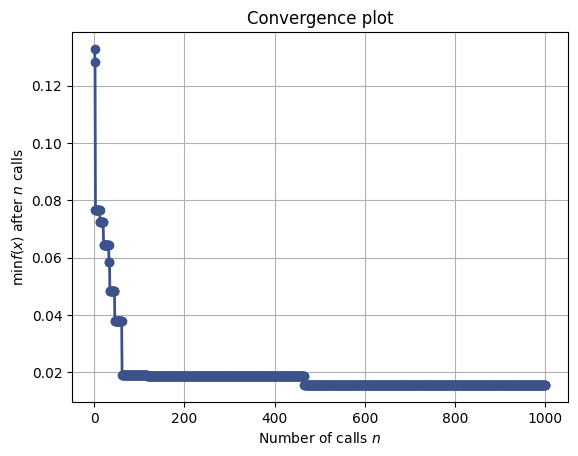

In [37]:
# Print the best hyperparameters and the corresponding objective value
best_params = result.x
best_objective_value = result.fun
print('Best hyperparameters: hyperparam1={}, hyperparam2={}'.format(*best_params))
print('Corresponding objective value: {}'.format(best_objective_value))

# Plot the convergence plot
plot_convergence(result)

In [38]:
best_params

[0.9992939819807838, 0.556979004410723]

In [46]:
hyps1 = (0.95,0.5)
hyps2 = (0.999,0.999)
hyps3 = (0.9,0.0067)
hyps4 = (0.96,0.86)
hyps5 = (0.7,0.99)
hyps6 = (0.96,0.99)
hyps7 = (0.92,0.99)

In [ ]:
avg_eta = (hyps1[0+hyps2ps1)

In [57]:
# Evaluate the performance of the best hyperparameters using the test set
best_reconstructed_image = get_samples(result.x[0], result.x[1], y, noise=1.,nsamples=1).unflatten(-1, ddrmds.src_shape)
best_mse = mean_squared_error(best_reconstructed_image.flatten().detach().cpu().numpy(), ddrm_noise.flatten().detach().cpu().numpy())
print('Best MSE:', best_mse)

0it [00:00, ?it/s]

Best MSE: 1.9880083e-06


In [58]:
best_reconstructed_image.shape

torch.Size([1, 3, 64, 64])

In [59]:
best_reconstructed_image.mean(1).shape

torch.Size([1, 64, 64])

In [60]:
best_reconstructed_image = best_reconstructed_image.mean(1)

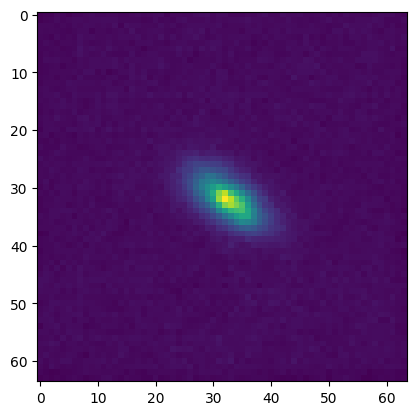

In [61]:
plt.imshow(best_reconstructed_image[0].detach().cpu().numpy())

In [62]:
vanilla_recon = get_samples(0.03, 0.85,
    y, noise=1., nsamples=1, 
).unflatten(-1, ddrmds.src_shape)

0it [00:00, ?it/s]

In [63]:
vanilla_mse = mean_squared_error(vanilla_recon.flatten().detach().cpu().numpy(), ddrm_noise.flatten().detach().cpu().numpy())
vanilla_mse

In [64]:
vanilla_recon = vanilla_recon.mean(1)

In [65]:
vanilla_recon.shape

In [66]:
plt.imshow(vanilla_recon[0].detach().cpu().numpy())

In [67]:
skela = get_samples(0.0, 0.8,
    y, noise=1., nsamples=1, 
).unflatten(-1, ddrmds.src_shape)

In [68]:
skela_mse = mean_squared_error(skela.flatten().detach().cpu().numpy(), ddrm_noise.flatten().detach().cpu().numpy())

In [69]:
print(skela_mse)

In [70]:
skela = skela.mean(1)
plt.imshow(skela[0].detach().cpu().numpy())

 # Playing with H matrix shapes

In [149]:
x = torch.randn(64,64,256,256)
x = x.flatten(-2).flatten(-3, -2) 
y = torch.randn(64,64).flatten(-2)
print(x.shape)
print(y.shape)

torch.Size([4096, 65536])
torch.Size([4096])


In [150]:
x = torch.cat(1 * (x/1,), dim=-1)
x.shape

torch.Size([4096, 65536])

In [151]:
U,S,V = torch.linalg.svd(x, full_matrices=False)

In [152]:
print(U.shape)
print(y.shape)
print(y.unsqueeze(-1).shape)

torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([4096, 1])


In [145]:
l = U.mT @ y.unsqueeze(-1)
l = l.squeeze(-1)
print(l.shape)

torch.Size([4096])


In [166]:
x = torch.randn(3,64,64,3,64,64)
x = x.flatten(-2).flatten(-4,-3).flatten(0,1).flatten(1,2)
x.shape

torch.Size([12288, 12288])

In [167]:
U,S,V = torch.linalg.svd(x, full_matrices=False)

In [168]:
print(U.shape)
print(S.shape)
print(V.shape)

torch.Size([12288, 12288])
torch.Size([12288])
torch.Size([12288, 12288])


In [41]:
b = torch.randn(16,3,4096)
b= b.flatten(-2)
b.shape

torch.Size([16, 12288])

In [1]:
%store -r lensing_Hb
print(lensing_Hb)


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [3]:
lensing_Hb.shape

torch.Size([64, 64, 256, 256])